In [1]:
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime

from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set('talk')
sns.set_style('darkgrid')

# Define measures

In [2]:
entropy_correction = 1/np.log(2)

def pedersen_index(u,v):
    return sum(np.abs(u - v))/2

def KL_divergence(u,v):
    return entropy(u,v)*entropy_correction

def survival_rate_edy_meirick(u,v,percentage=0.1):
    issues     = [ 1 if i > percentage else 0 for i in u ]
    old_issues = [ 1 if i > percentage else 0 for i in v ]

    n_dropping = 0
    for issue_is_present, issue_was_present in zip(issues,old_issues):
        if issue_was_present and not issue_is_present:
            n_dropping += 1
    try:
        drop_rate = n_dropping/sum(old_issues)
    except ZeroDivisionError:
        drop_rate = 0

    return drop_rate

# Diversity measures

def non_normalised_entropy(u):
    return entropy(u)*entropy_correction

def normalised_entropy(u):
    return non_normalised_entropy(u)/np.log2(len(u))

def eff_n_issues(u):
    return 2**(non_normalised_entropy(u))

def inverse_simpson(u):
    return 1.0/sum(i**2 for i in u)

# Testing

In [3]:
def make_random_agenda_0(L=10,T=10):
    idxs = [ np.random.choice(range(L),2,replace=False) for _ in range(T) ]
    x_old = np.random.rand(L)
    x_old /= sum(x_old)
    agenda_over_time = [x_old]

    for pair in idxs:
        x = x_old.copy()
        if (x[pair[0]]>=0.1) and (x[pair[1]]<=0.9):
            x[pair[0]]-=0.1
            x[pair[1]]+=0.1
        agenda_over_time += [x]
        x_old = x

    return np.array(agenda_over_time)

def next_point(x_old, stepsize=0.2):
    while True:
        x_new = x_old * np.exp( np.random.normal(0,stepsize) )
        metropolis_ratio = np.exp(-x_new) / np.exp(-x_old)
        hastings_ratio   = ( x_new / x_old )
        acceptance_probability = min( 1 , metropolis_ratio * hastings_ratio )
        uniform_random_number = np.random.rand()
        if acceptance_probability > uniform_random_number:
            break
    return x_new

def make_random_agenda(L=10,T=10,stepsize=0.2):
    x0 = np.array([ np.random.exponential() for _ in range(L) ])
    x0 /= sum(x0)
    agenda_over_time = [x0]

    for t in range(T-1):
        x  = np.array([ next_point(xi, stepsize=stepsize) for xi in x0 ])
        x /= sum(x)
        agenda_over_time += [x]
        x0 = x.copy()
    return np.array(agenda_over_time)

# Write something that will detect disagreement between measures

survival_10p = lambda u,v: survival_rate_edy_meirick(u,v,percentage=0.10)
survival_02p = lambda u,v: survival_rate_edy_meirick(u,v,percentage=0.02)

metrics = {'diversity' : [non_normalised_entropy, normalised_entropy,
                        eff_n_issues, inverse_simpson],
         'volatility': [pedersen_index, KL_divergence,
                        survival_10p, survival_02p]}

metricsnames = {'diversity' : ['entropy','norm_entropy','ENI','inverse_simpson'],
              'volatility': ['pedersen','KL','survival-10%','survival-2%']}


def apply_measures(agenda):
    # measure all

    allmetricsnames = metricsnames['diversity'] + metricsnames['volatility']

    measures = { key:[] for key in allmetricsnames }

    for t in range(1, agenda.shape[0]):

        for key,metric in zip(metricsnames['diversity'],metrics['diversity']):
            diversity = metric
            measures[key] += [ diversity(agenda[t]) ]

        for key,metric in zip(metricsnames['volatility'],metrics['volatility']):
            volatility = metric
            measures[key] += [ volatility(agenda[t],agenda[t-1]) ]

    return measures

# For comparison
from scipy.stats import pearsonr

In [4]:
agenda   = make_random_agenda(L=20, T=100)
measures = apply_measures(agenda)

In [5]:
metricsnames = {'diversity' : ['entropy','norm_entropy','ENI','inverse_simpson'],
               'volatility': ['pedersen','KL','survival-10%','survival-2%']}

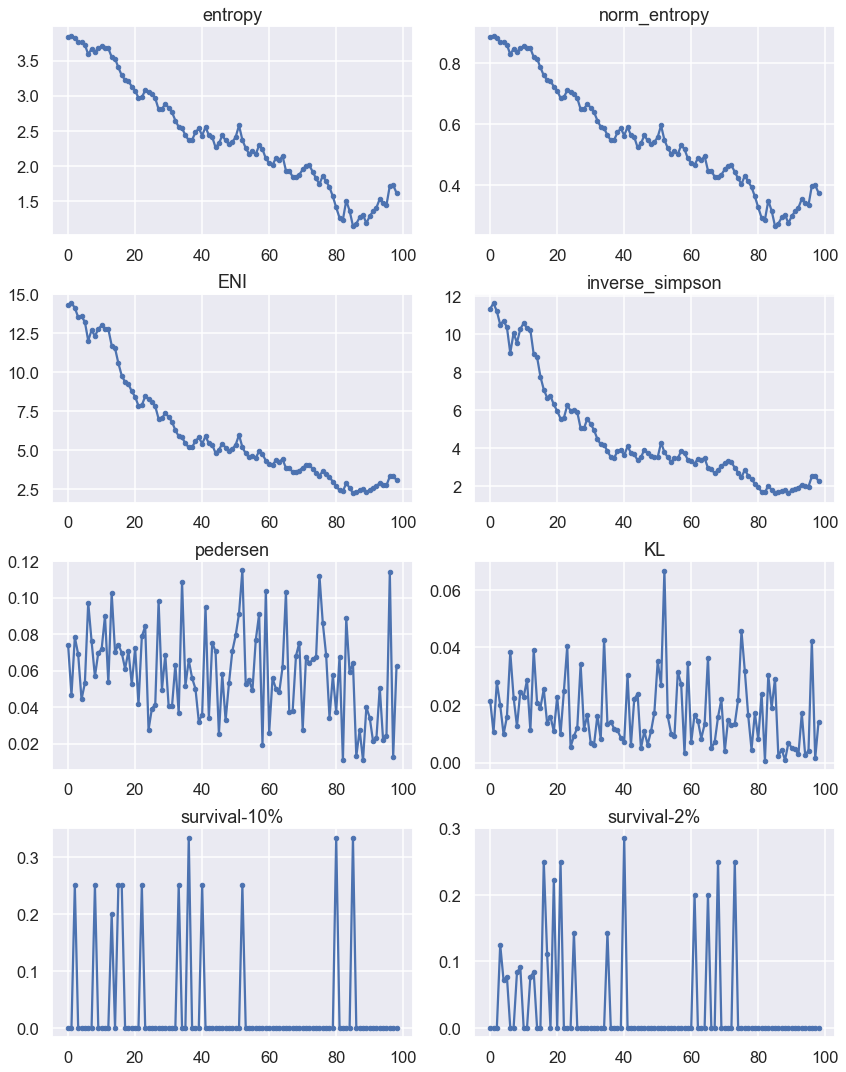

In [6]:
fig, axs = plt.subplots(4,2,figsize=(12,15))
axs = axs.flatten()

allkeys = metricsnames['diversity'] + metricsnames['volatility']

for key, ax in zip(allkeys,axs):
    ax.plot(measures[key],'.-')
    ax.set_title(key)

plt.tight_layout()
plt.show()

# Loading our actual data

In [7]:
newspapers = ['Spiegel', 'Times']
#period_names = ['week','month','quarter','year']
period_names = ['week']
agendas_data = {}

n_topics = 50

for newspaper in newspapers:
    for pn in period_names:
        infile = 'Null-models/data/aggregate_{}topics_per_{}_{}.csv'.format(n_topics,pn,
                                                                               newspaper)
        # Read
        df = pd.read_csv(infile, index_col=0)
        
        # Normalise rows
        df = df.div(df.sum(axis=1), axis=0)
        
        # Add to dictionary
        agendas_data[newspaper+'-'+pn] = df.sort_index()
        

In [8]:
dates = {key: agendas_data[key].index for key in agendas_data }

dates

{'Spiegel-week': Index(['1947-01', '1947-02', '1947-03', '1947-04', '1947-05', '1947-06',
        '1947-07', '1947-08', '1947-09', '1947-10',
        ...
        '2016-42', '2016-43', '2016-44', '2016-45', '2016-46', '2016-47',
        '2016-48', '2016-49', '2016-50', '2016-53'],
       dtype='object', length=3639),
 'Times-week': Index(['1947-01', '1947-02', '1947-03', '1947-04', '1947-05', '1947-06',
        '1947-07', '1947-08', '1947-09', '1947-10',
        ...
        '2012-43', '2012-44', '2012-45', '2012-46', '2012-47', '2012-48',
        '2012-49', '2012-50', '2012-51', '2012-52'],
       dtype='object', length=3239)}

# Applying these measures to our real data

In [9]:
measures = {key : apply_measures(agendas_data[key].values) for key in agendas_data.keys()}

In [10]:
dfs_measures = { key : pd.DataFrame(measures[key]) for key in measures }
dfs_measures['Spiegel-week'].head()

entropy  norm_entropy        ENI  inverse_simpson  pedersen        KL  \
0  5.504126      0.975242  45.384457        41.246927  0.039507  0.006600   
1  5.507255      0.975796  45.482975        41.659773  0.026125  0.002805   
2  5.504650      0.975335  45.400926        41.350771  0.030732  0.004533   
3  5.506866      0.975728  45.470721        41.533421  0.026703  0.004050   
4  5.514216      0.977030  45.702963        41.811551  0.031252  0.005077   

   survival-10%  survival-2%  
0           0.0     0.095238  
1           0.0     0.000000  
2           0.0     0.100000  
3           0.0     0.000000  
4           0.0     0.000000

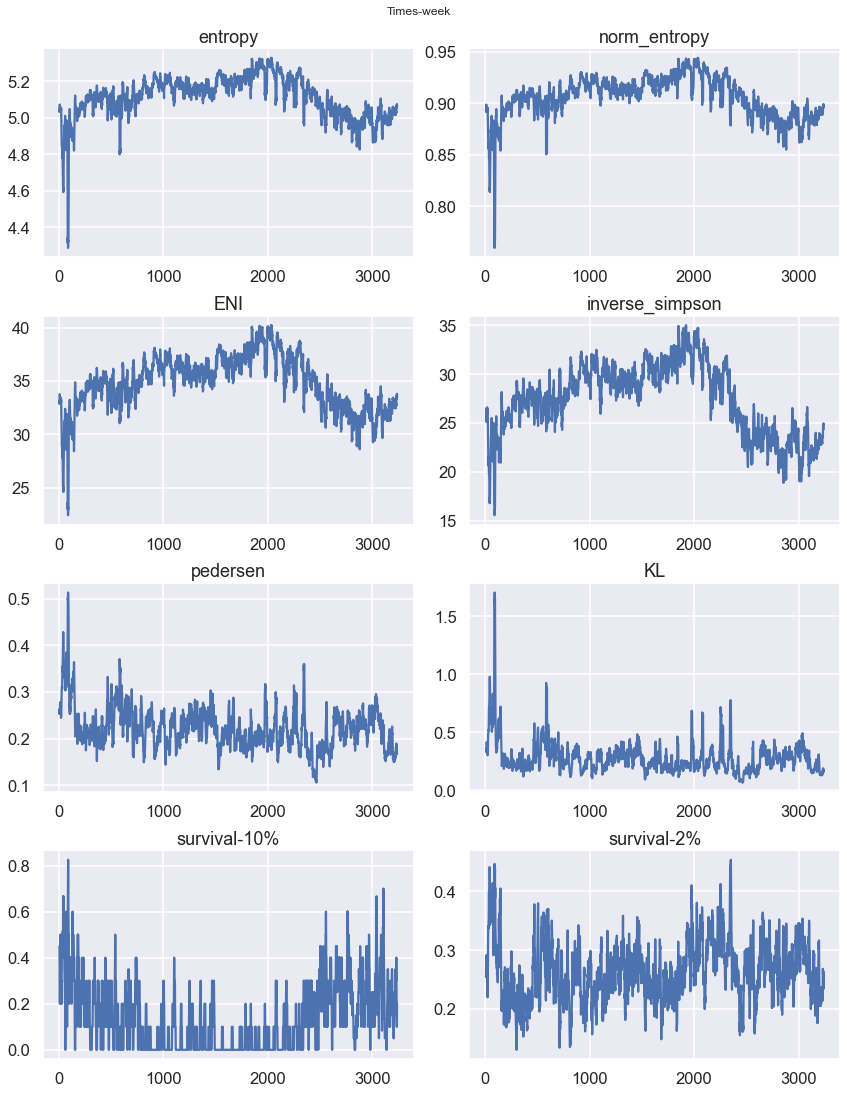

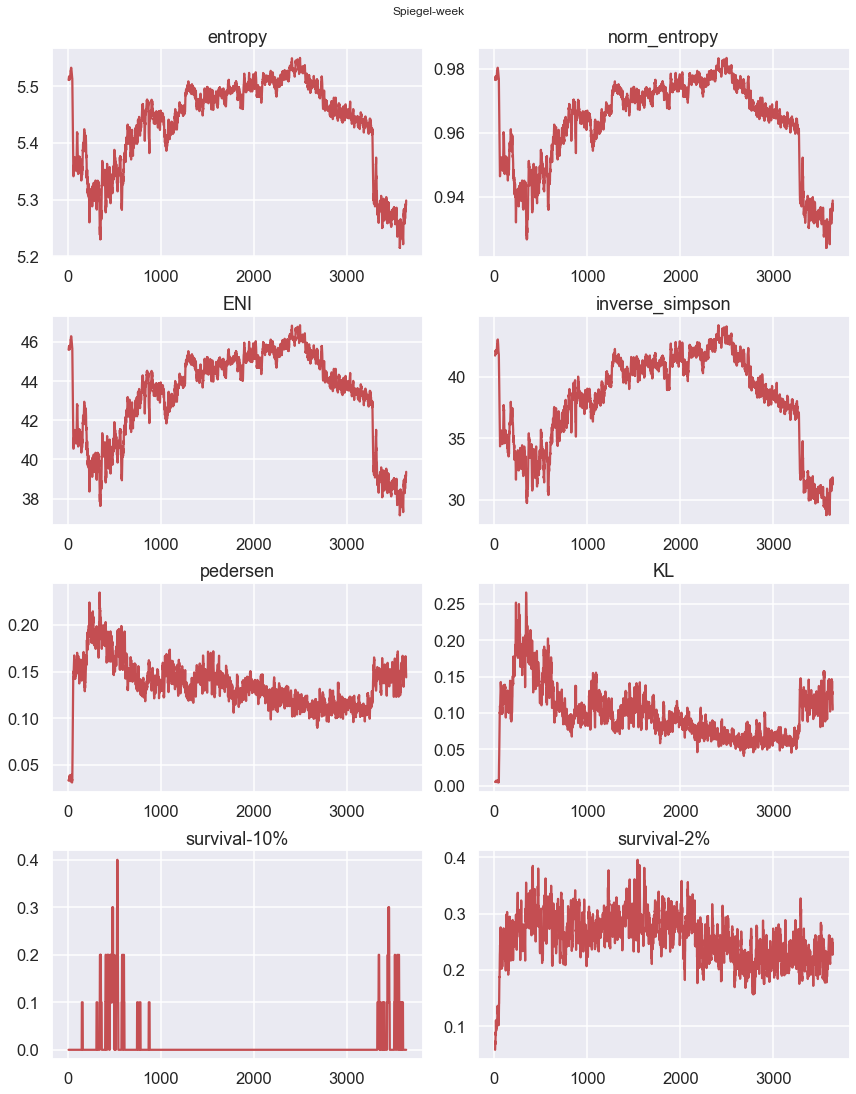

In [11]:
colors = ['b','r']

windowsize = 10

for df_key,c in zip(sorted(dfs_measures.keys())[::-1],colors):
    fig, axs = plt.subplots(4,2,figsize=(12,15))
    axs = axs.flatten()

    df = dfs_measures[df_key]

    for col, ax in zip(df.columns,axs):
        y = df[col].rolling(window=windowsize).mean()
        ax.plot(y,'-',c=c)
        ax.set_title(col)
        
    plt.suptitle(df_key, y=1.01)
    plt.tight_layout()
    plt.show()

In [12]:
len(y), len(dates['Spiegel-week'])

(3638, 3639)

In [13]:
def normalise(x):
    return (x-min(x))/(max(x)-min(x))

def standardise(x):
    return (x-np.mean(x))/(np.std(x))

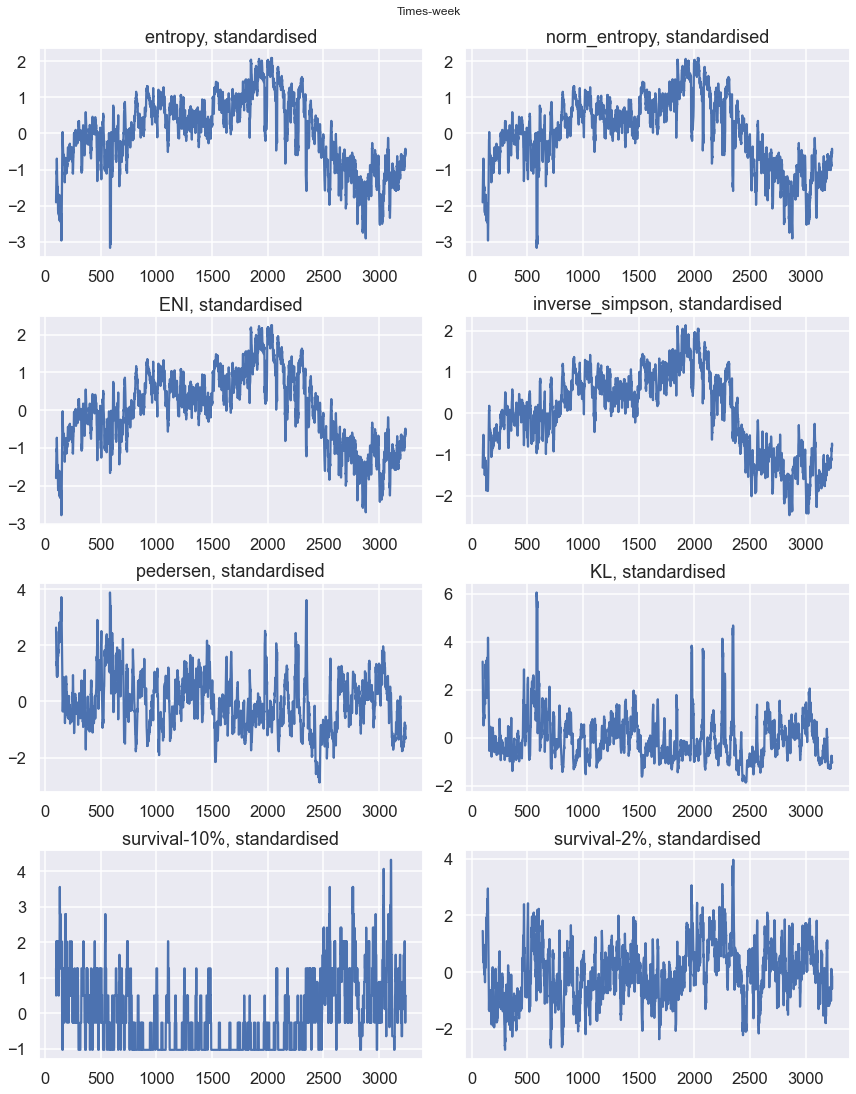

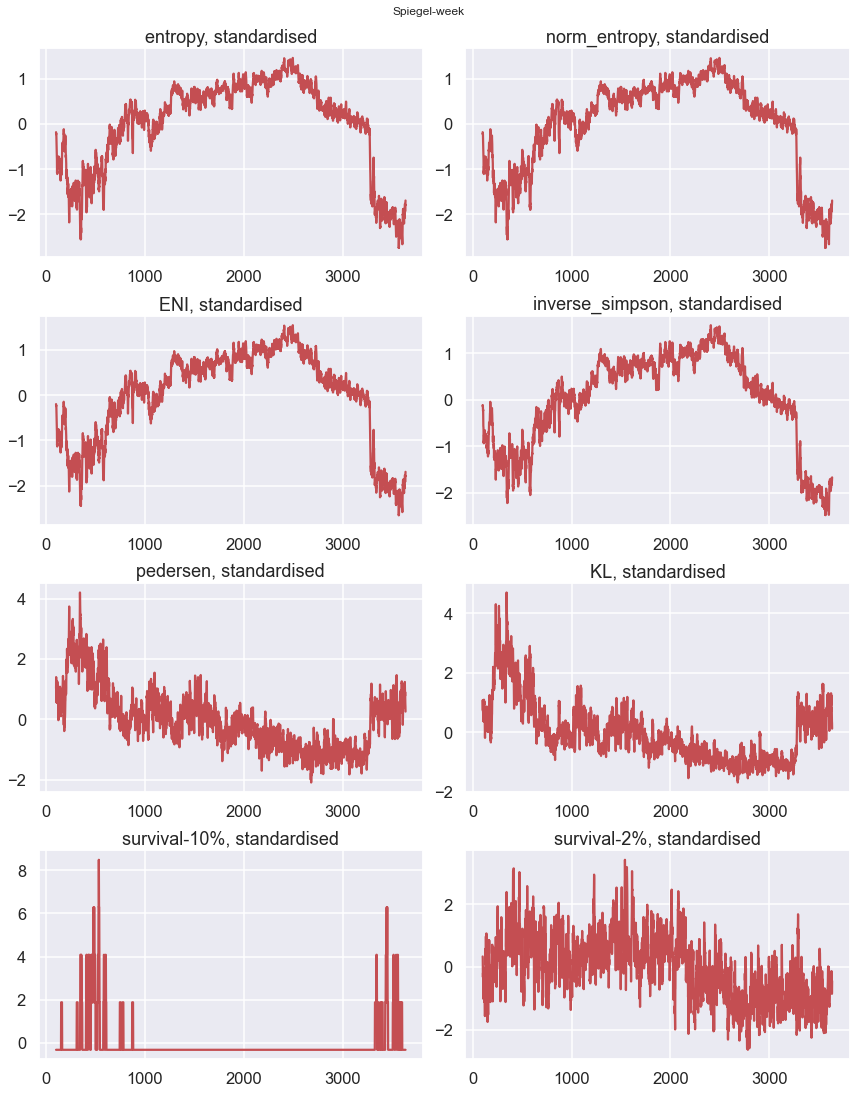

In [14]:
colors = ['b','r']

windowsize = 10

for df_key,c in zip(sorted(dfs_measures.keys())[::-1],colors):
    fig, axs = plt.subplots(4,2,figsize=(12,15))
    axs = axs.flatten()

    df = dfs_measures[df_key]

    for col, ax in zip(df.columns,axs):
        y = df[col].rolling(window=windowsize).mean()[100:]
        y = standardise(y)
        ax.plot(y,'-',c=c)
        ax.set_title(col+', standardised')

    plt.suptitle(df_key, y=1.01)
    plt.tight_layout()
    plt.show()

NameError: name 'adjusted_dates' is not defined

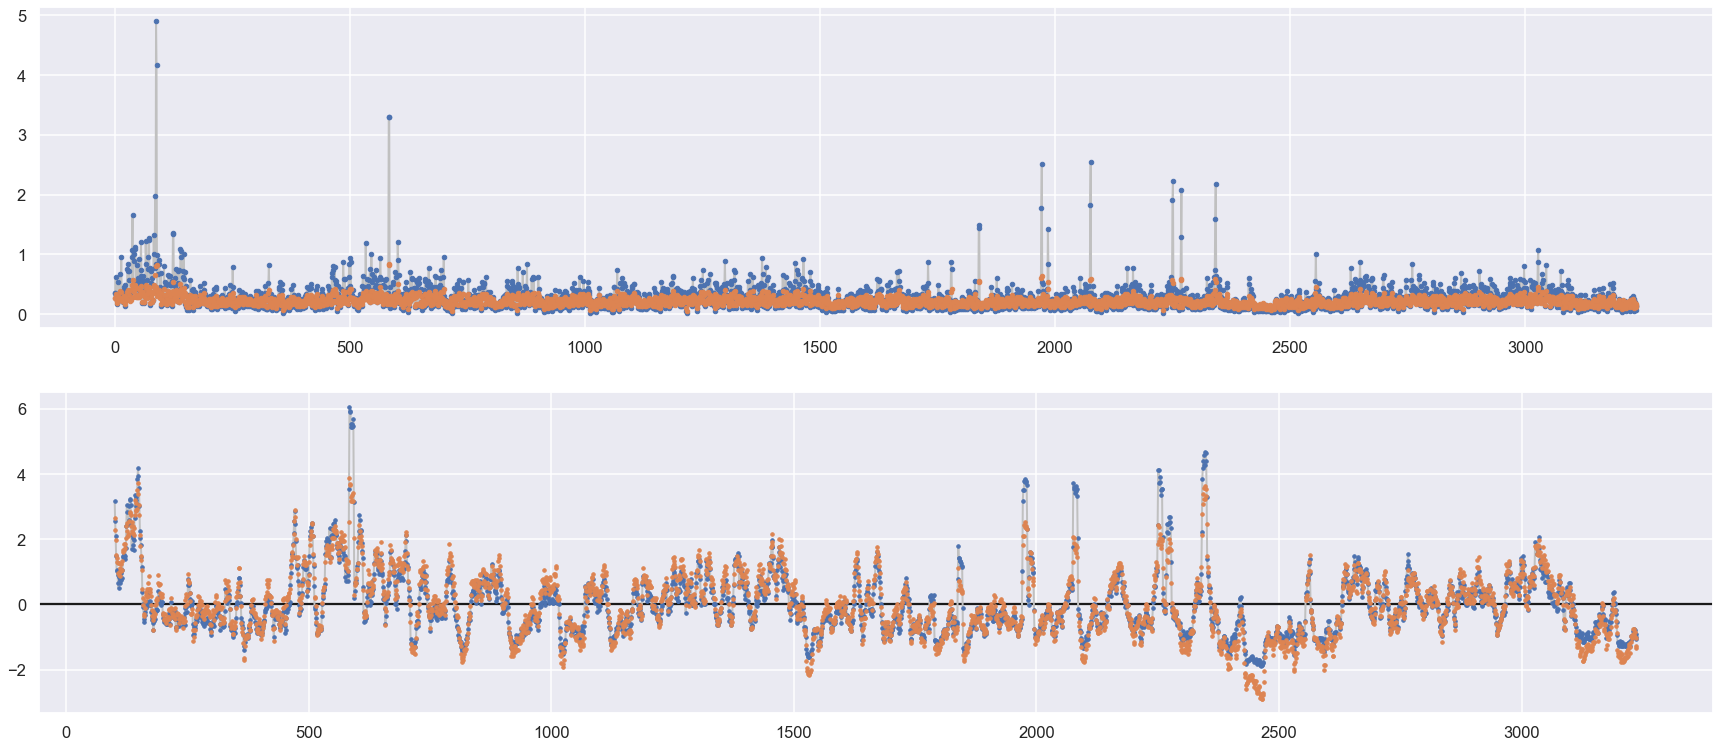

In [15]:
df = dfs_measures['Times-week']

col1 = 'pedersen'
col2 = 'KL'

windowsize = 10
x = df[col1]
y = df[col2]

x_window = x.rolling(window=windowsize).mean()[100:]  #[windowsize:]
y_window = y.rolling(window=windowsize).mean()[100:]  #[windowsize:]

xs = standardise(x_window)
ys = standardise(y_window)

###############

fig, axs = plt.subplots(2,1,figsize=(30,13))

ax = axs[0]
ax.plot(y, '-', c='silver', lw=2)
ax.plot(y, '.')
ax.plot(x, '.')

ax = axs[1]
ax.axhline(0, c='k')
ax.plot(ys, '-', c='silver', lw=2)
ax.plot(ys, '.', ms=7, label='ys')
ax.plot(xs, '.', ms=7, label='xs')

for ax in axs:   
    xticks = np.arange(0,len(x),500)
    ax.set_xticks(xticks)
    ax.set_xticklabels([ i[:-3] for i in adjusted_dates['Times-week'][xticks] ])


plt.legend()
plt.show()

In [ ]:
bins = np.linspace(-2,6,30)

plt.hist(ys, bins=bins, alpha=0.6)
plt.hist(xs, bins=bins, alpha=0.5)

plt.yscale('log')
plt.show()

NameError: name 'adjusted_dates' is not defined

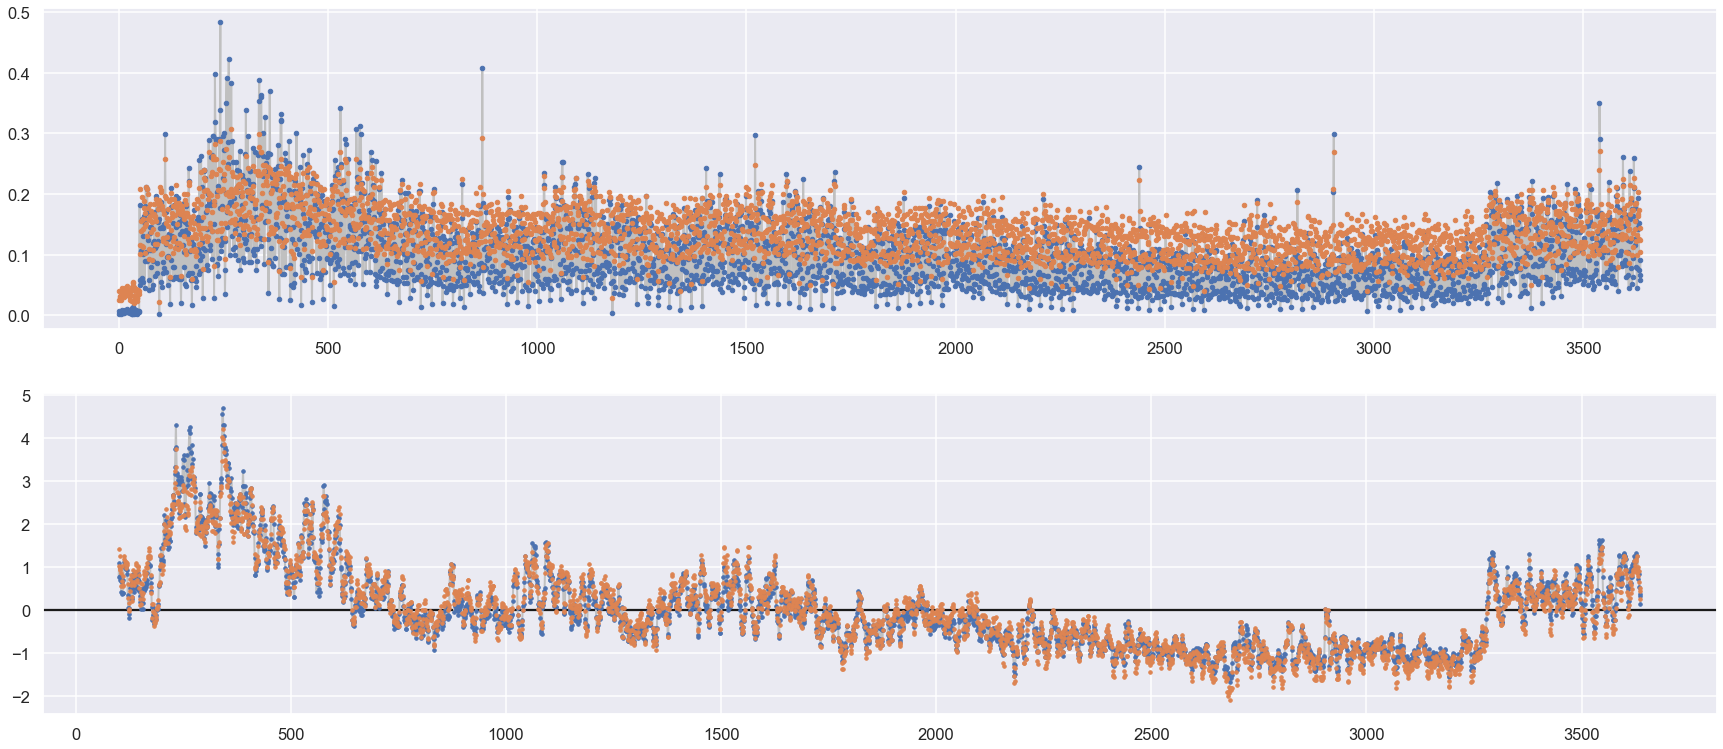

In [17]:
source = 'Spiegel-week'

df = dfs_measures[source]

col1 = 'pedersen'
col2 = 'KL'

windowsize = 10
x = df[col1]
y = df[col2]

x_window = x.rolling(window=windowsize).mean()[100:]  #[windowsize:]
y_window = y.rolling(window=windowsize).mean()[100:]  #[windowsize:]

xs = standardise(x_window)
ys = standardise(y_window)

###############

fig, axs = plt.subplots(2,1,figsize=(30,13))

ax = axs[0]
ax.plot(y, '-', c='silver', lw=2)
ax.plot(y, '.')
ax.plot(x, '.')

ax = axs[1]
ax.axhline(0, c='k')
ax.plot(ys, '-', c='silver', lw=2)
ax.plot(ys, '.', ms=7, label='ys')
ax.plot(xs, '.', ms=7, label='xs')

for ax in axs:   
    xticks = np.arange(0,len(x),500)
    ax.set_xticks(xticks)
    ax.set_xticklabels([ i[:-3] for i in adjusted_dates[source][xticks] ])


plt.legend()
plt.show()

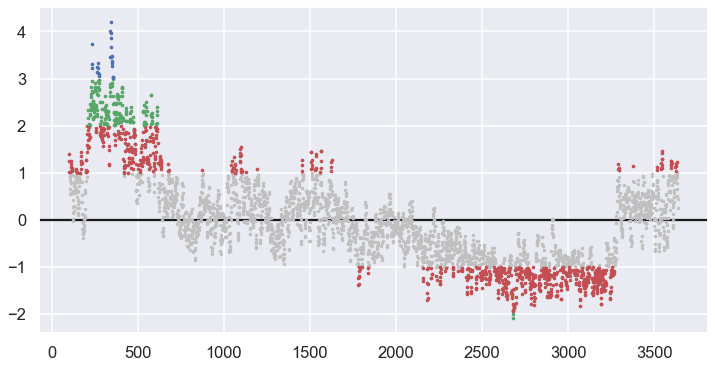

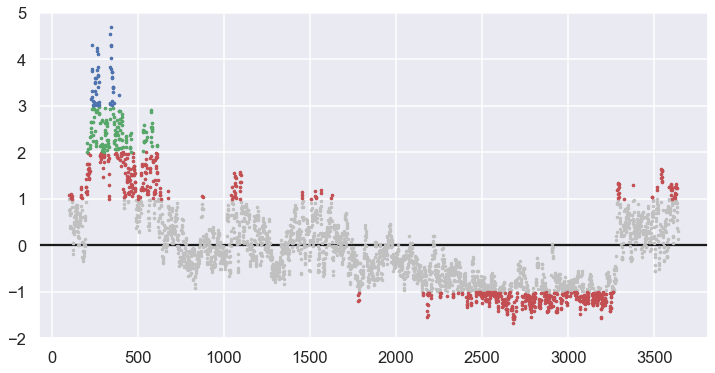

In [18]:
for z in [xs, ys]:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.axhline(0, c='k')
    ax.plot(z, '.', ms=5, c='silver')
    
    mask1 = (np.abs(z)>1) & (np.abs(z)<2)
    mask2 = (np.abs(z)>2) & (np.abs(z)<3)
    mask3 = (np.abs(z)>3) 
    cs = [ 'r','g','b']
    masks = [ mask1, mask2, mask3 ]
    for mask, c in zip(masks, cs):
        ax.plot(z[mask], '.', c=c, ms=5) 

    plt.show()

## Let's try to apply these rules to xs and ys

- Rule 1 Any single data point falls outside the 3σ-limit from the centerline

- Rule 2 Two out of three consecutive points fall beyond the 2σ-limit

- Rule 3 Four out of five consecutive points fall beyond the 1σ-limit 

- Rule 4 Eight consecutive points fall on the same side of the centerline

- https://en.wikipedia.org/wiki/Western_Electric_rules

In [19]:
from itertools import combinations
from functools import reduce

def apply_rule1(z):
    return (np.abs(z)>3)

def apply_rule2(z):
    absz = np.abs(z)
    output = []
    output += [ False, False ]
    for k1, k2, k3 in zip(absz[0:], absz[1:], absz[2:]):
        and_masks = [ (i>2 and j>2) for i,j in combinations([k1,k2,k3],2) ]
        test = reduce( lambda x,y:(x or y), and_masks )
        output += [test]
    return np.array(output) 

def apply_rule3(z):
    absz = np.abs(z)
    output = []
    output += [ False, False, False, False ]
    for k1, k2, k3, k4, k5 in zip(absz[0:], absz[1:], absz[2:], absz[3:], absz[4:]):
        and_masks = [ (i>1 and j>1 and l>1 and w>1) for i,j,l,w in combinations([k1,k2,k3,k4,k5],4) ]
        test = reduce( lambda x,y:(x or y), and_masks )
        output += [test]
    return np.array(output) 

def apply_rule4(z):
    output = []
    output += [ False ]*7
    for k1, k2, k3, k4, k5, k6, k7, k8 in zip(z[0:], z[1:], z[2:], z[3:], z[4:], z[5:], z[6:], z[7:]):
        if k8>0:
            test = reduce( lambda x,y:(x and y),[i>0 for i in [k1,k2,k3,k4,k5,k6,k7,k8]])
        else:
            test = reduce( lambda x,y:(x and y),[i<0 for i in [k1,k2,k3,k4,k5,k6,k7,k8]])
        output += [test]
    return np.array(output)

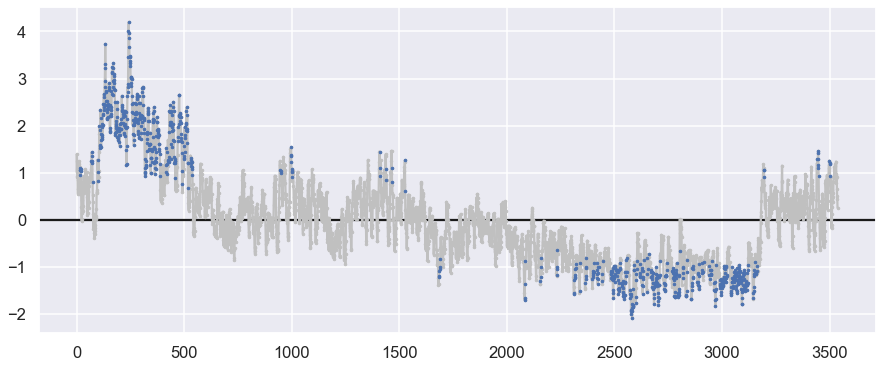

In [20]:
z = xs.values

fig, ax = plt.subplots(figsize=(15,6))
x = np.arange(len(z))
ax.axhline(0, c='k')

ax.plot(x, z, '.-', ms=5, c='silver')

#mask = apply_rule1( np.array(z) )
#ax.plot(x[mask], z[mask], '.', ms=5) 

#mask = apply_rule2( np.array(z) )
#ax.plot(x[mask], z[mask], '.', ms=5) 

mask = apply_rule3( np.array(z) )
ax.plot(x[mask], z[mask], '.', ms=5) 

#mask = apply_rule4( np.array(z) )
#ax.plot(x[mask], z[mask], '.', ms=5) 

plt.show()

In [21]:
# Now make this table for all KL and Pedersen
#
# This will allow us to see in which weeks Xs spikes and in which weeks Ys spikes,
# according to this gradual definition of spike.

In [22]:
dfs_with_rules = {}
windowsize = 10

for df_key in dfs_measures.keys():
    dfs_with_rules[df_key] = pd.DataFrame()
    
    for col in dfs_measures[df_key].columns:
        x = dfs_measures[df_key][col]
        x_window = x.rolling(window=windowsize).mean()[100:]  #[windowsize:]
        xs = standardise(x_window)
        z = xs.values
        dfs_with_rules[df_key][col+'_z'] = z        
        dfs_with_rules[df_key][col+'_rule1'] = apply_rule1(z)
        dfs_with_rules[df_key][col+'_rule2'] = apply_rule2(z)
        dfs_with_rules[df_key][col+'_rule3'] = apply_rule3(z)
        dfs_with_rules[df_key][col+'_rule4'] = apply_rule4(z)

In [23]:
dfs_with_rules['Spiegel-week'].columns

Index(['entropy_z', 'entropy_rule1', 'entropy_rule2', 'entropy_rule3',
       'entropy_rule4', 'norm_entropy_z', 'norm_entropy_rule1',
       'norm_entropy_rule2', 'norm_entropy_rule3', 'norm_entropy_rule4',
       'ENI_z', 'ENI_rule1', 'ENI_rule2', 'ENI_rule3', 'ENI_rule4',
       'inverse_simpson_z', 'inverse_simpson_rule1', 'inverse_simpson_rule2',
       'inverse_simpson_rule3', 'inverse_simpson_rule4', 'pedersen_z',
       'pedersen_rule1', 'pedersen_rule2', 'pedersen_rule3', 'pedersen_rule4',
       'KL_z', 'KL_rule1', 'KL_rule2', 'KL_rule3', 'KL_rule4',
       'survival-10%_z', 'survival-10%_rule1', 'survival-10%_rule2',
       'survival-10%_rule3', 'survival-10%_rule4', 'survival-2%_z',
       'survival-2%_rule1', 'survival-2%_rule2', 'survival-2%_rule3',
       'survival-2%_rule4'],
      dtype='object')

In [24]:
len(dfs_with_rules['Spiegel-week'])

3538

In [25]:
dfs_with_rules['Spiegel-week'].head(10)

entropy_z  entropy_rule1  entropy_rule2  entropy_rule3  entropy_rule4  \
0  -0.179197          False          False          False          False   
1  -0.224860          False          False          False          False   
2  -0.208443          False          False          False          False   
3  -0.233397          False          False          False          False   
4  -0.317401          False          False          False          False   
5  -0.308899          False          False          False          False   
6  -0.523103          False          False          False          False   
7  -0.673787          False          False          False           True   
8  -0.709305          False          False          False           True   
9  -0.773320          False          False          False           True   

   norm_entropy_z  norm_entropy_rule1  norm_entropy_rule2  norm_entropy_rule3  \
0       -0.179197               False               False               False   
1       -0.224860               False               False               False   
2       -0.208443               False               False               False   
3       -0.233397               False               False               False   
4       -0.317401               False               False               False   
5       -0.308899               False               False               False   
6       -0.523103               False               False               False   
7       -0.673787               False               False               False   
8       -0.709305               False               False               False   
9       -0.773320               False               False               False   

   norm_entropy_rule4  ...  survival-10%_z  survival-10%_rule1  \
0               False  ...       -0.317239               False   
1               False  ...       -0.317239               False   
2               False  ...       -0.317239               False   
3               False  ...       -0.317239               False   
4               False  ...       -0.317239               False   
5               False  ...       -0.317239               False   
6               False  ...       -0.317239               False   
7                True  ...       -0.317239               False   
8                True  ...       -0.317239               False   
9                True  ...       -0.317239               False   

   survival-10%_rule2  survival-10%_rule3  survival-10%_rule4  survival-2%_z  \
0               False               False               False       0.336217   
1               False               False               False       0.291093   
2               False               False               False      -0.018532   
3               False               False               False      -0.318170   
4               False               False               False      -0.185173   
5               False               False               False      -0.609869   
6               False               False               False      -0.633935   
7               False               False                True      -0.026813   
8               False               False                True      -0.327639   
9               False               False                True      -0.509502   

   survival-2%_rule1  survival-2%_rule2  survival-2%_rule3  survival-2%_rule4  
0              False              False              False              False  
1              False              False              False              False  
2              False              False              False              False  
3              False              False              False              False  
4              False              False              False              False  
5              False              False              False              False  
6              False              False              False              False  
7              False      

In [26]:
print( len(dfs_with_rules['Spiegel-week']), len(dates['Spiegel-week'][101:]) )
print( len(dfs_with_rules['Times-week']),   len(dates['Times-week'][101:]) )

3538 3538
3138 3138



Times-week - Rule number 2


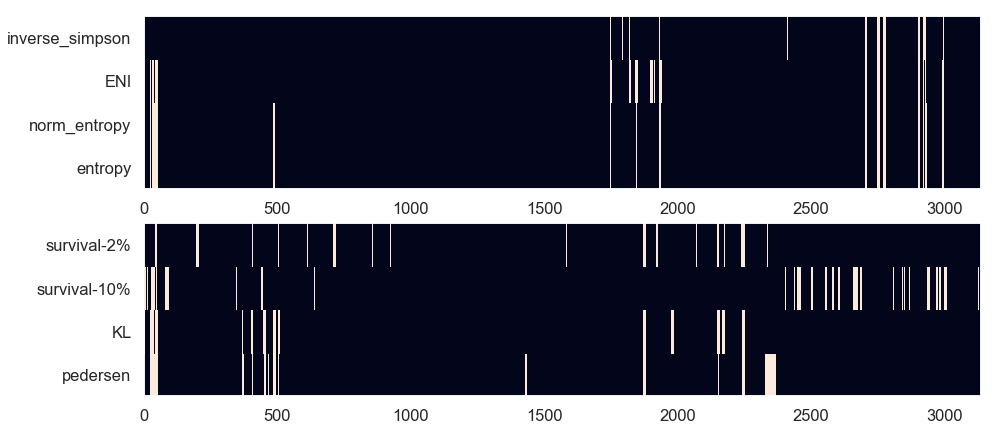

In [91]:
#source = 'Spiegel-week'
source = 'Times-week'

df = dfs_with_rules[source]

#for rule_number in range(1,5):
for rule_number in [2]:
    print()
    print(source,'- Rule number', rule_number)

    cols = [ col for col in df.columns if '_rule'+str(rule_number) in col ]

    M = df[cols].values.T

    fig, axs = plt.subplots(2,1,figsize=(15,7))
    ax = axs[0]
    ax.pcolor(M[:4])
    ax.set_yticks(np.arange(0.5,4.5))
    ax.set_yticklabels([ i[:-6] for i in cols[:4]])

    ax = axs[1]
    ax.pcolor(M[4:])
    ax.set_yticks(np.arange(0.5,4.5))
    ax.set_yticklabels([ i[:-6] for i in cols[4:]])

    plt.show()

Extract in which periods our method spikes and others don't,

and in which periods they spike and ours does not.

In [27]:
# Now find when our measure does something and others do nothing

sources = ['Times-week','Spiegel-week']
novelty_only_ours = { k:{ i:[] for i in range(1,4)} for k in sources }
novelty_not_ours  = { k:{ i:[] for i in range(1,4)} for k in sources }
    
for source in sources:

    df = dfs_with_rules[source]

    for i, r in df.iterrows():

        for rule_number in range(1,4):

            if r['KL_rule'+str(rule_number)] and not r['pedersen_rule'+str(rule_number)]:
                novelty_only_ours[source][rule_number] += [True]
            else:
                novelty_only_ours[source][rule_number] += [False]

            if not r['KL_rule'+str(rule_number)] and r['pedersen_rule'+str(rule_number)]:
                novelty_not_ours[source][rule_number] += [True]
            else:
                novelty_not_ours[source][rule_number] += [False]


In [28]:
adjusted_dates = { k:v[101:] for k,v in dates.items() }

In [29]:
print( len(novelty_not_ours['Spiegel-week'][1]), len(adjusted_dates['Spiegel-week']) )
print( len(novelty_not_ours['Times-week'][1]),   len(adjusted_dates['Times-week']) )

3538 3538
3138 3138


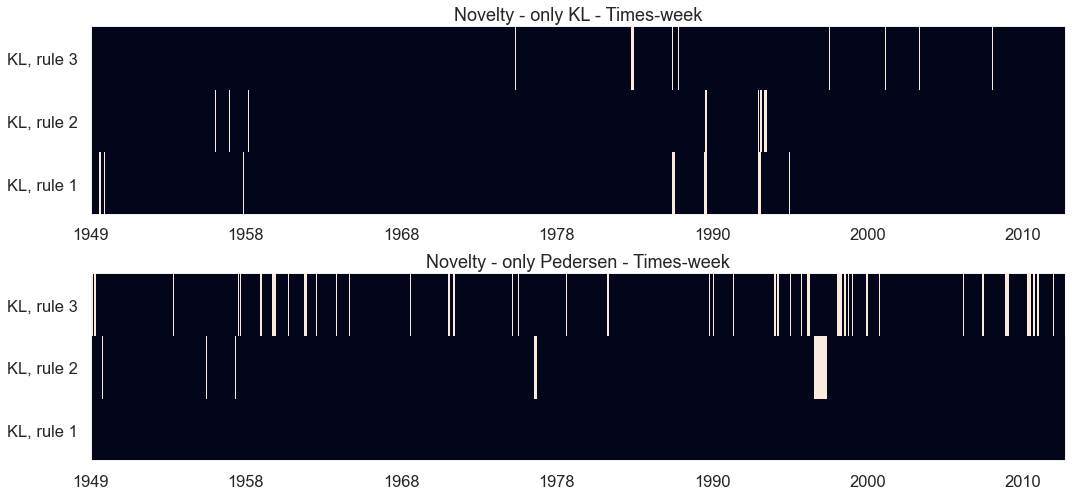

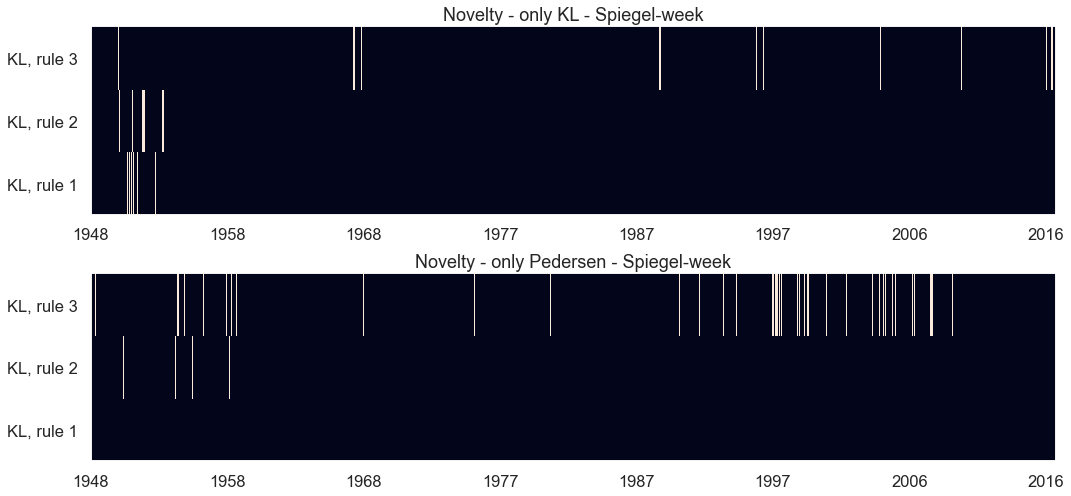

In [30]:
for source in sources:
    fig, axs = plt.subplots(2,1,figsize=(15,7))
    
    ax = axs[0]
    M = np.array([ i for i in novelty_only_ours[source].values()])
    ax.pcolor(M)
    ax.set_yticks(np.arange(0.5,3.5))
    ax.set_yticklabels([ 'KL, rule '+str(i) for i in range(1,5) ])
    ax.set_title('Novelty - only KL - '+ source)

    ax = axs[1]
    M = np.array([ i for i in novelty_not_ours[source].values()])
    ax.pcolor(M)
    ax.set_yticks(np.arange(0.5,3.5))
    ax.set_yticklabels([ 'KL, rule '+str(i) for i in range(1,5) ])
    ax.set_title('Novelty - only Pedersen - '+ source)    

    for ax in axs:
        xticks = np.arange(0,len(M.T),500)
        ax.set_xticks(xticks)
        ax.set_xticklabels([ i[:-3] for i in adjusted_dates[source][xticks] ])
    
    plt.tight_layout()
    plt.show()

So the interesting ones are Times / only KL / rule 1 and Times / only Pedersen / rule 2.

In [224]:
"""
for source in sources:
    print()
    print(source)
    for rule_number in range(1,3):
        print('Novelty - only ours - rule', rule_number)
        print( list(adjusted_dates[source][ novelty_only_ours[source][rule_number] ]))
        print()
        print('Novelty - not ours - rule', rule_number)
        print( list(adjusted_dates[source][ novelty_not_ours[source][rule_number] ]))
        print()
"""

print("\nTimes / only KL / rule 1\n")
for d in adjusted_dates['Times-week'][ novelty_only_ours['Times-week'][1] ]:
    print( datetime.strptime(d + '-1', "%Y-%W-%w").date() )

print("\nTimes / only Pedersen / rule 2\n")
for d in adjusted_dates['Times-week'][ novelty_not_ours['Times-week'][2] ]:
    print( datetime.strptime(d + '-1', "%Y-%W-%w").date() )


Times / only KL / rule 1

1949-01-10
1949-07-04
1949-08-08
1949-08-15
1949-08-22
1949-08-29
1949-11-14
1949-11-21
1949-11-28
1950-01-02
1958-07-21
1958-10-20
1987-02-16
1987-02-23
1987-03-02
1987-03-09
1987-03-16
1987-03-23
1987-03-30
1987-04-06
1987-04-13
1989-07-24
1989-07-31
1989-08-07
1989-08-14
1989-08-21
1989-08-28
1989-09-04
1989-09-11
1989-09-18
1993-07-12
1993-07-19
1993-07-26
1993-08-02
1993-08-09
1993-08-16
1993-08-23
1993-08-30
1993-09-06
1995-07-17
1995-09-18

Times / only Pedersen / rule 2

1949-06-27
1949-10-10
1949-10-17
1949-10-24
1956-04-09
1958-03-24
1958-03-31
1958-04-07
1958-04-14
1958-04-21
1961-01-02
1961-01-09
1977-03-28
1977-04-04
1977-04-11
1977-04-18
1977-04-25
1977-05-02
1977-05-09
1977-05-16
1997-04-07
1997-04-14
1997-04-21
1997-04-28
1997-05-05
1997-05-12
1997-05-19
1997-05-26
1997-06-02
1997-06-09
1997-06-16
1997-06-23
1997-06-30
1997-07-07
1997-07-14
1997-07-21
1997-07-28
1997-08-04
1997-08-11
1997-08-18
1997-08-25
1997-09-01
1997-09-08
1997-09-15
1997-

## Or, if we simply select the periods by hand:

In [ ]:
dates = agendas_data['Times-week'].index
x     = [ datetime.strptime(d + '-1', "%Y-%W-%w").date() for d in dates[1:] ]
y1     = dfs_measures['Times-week']['pedersen'].values
y2     = dfs_measures['Times-week']['KL'].values

In [601]:
print('pedersen_mean = {}\npedersen_std = {}'.format(y1.mean(), y1.std()))
print('KL_mean = {}\nKL_std = {}'.format(y2.mean(), y2.std()))

pedersen_mean = 0.22211449170794528
pedersen_std = 0.07504061303521482
KL_mean = 0.2819632410324907
KL_std = 0.24545868588136407


In [602]:
pedersen_mean = 0.22211449170794528
pedersen_std = 0.07504061303521482
KL_mean = 0.2819632410324907
KL_std = 0.24545868588136407

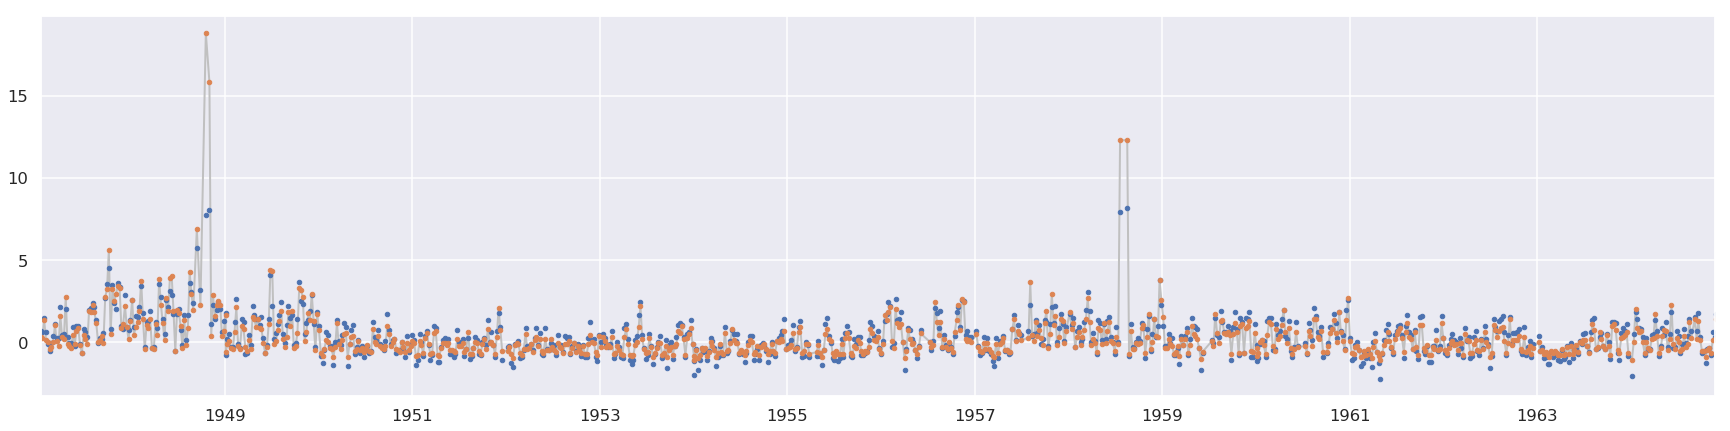

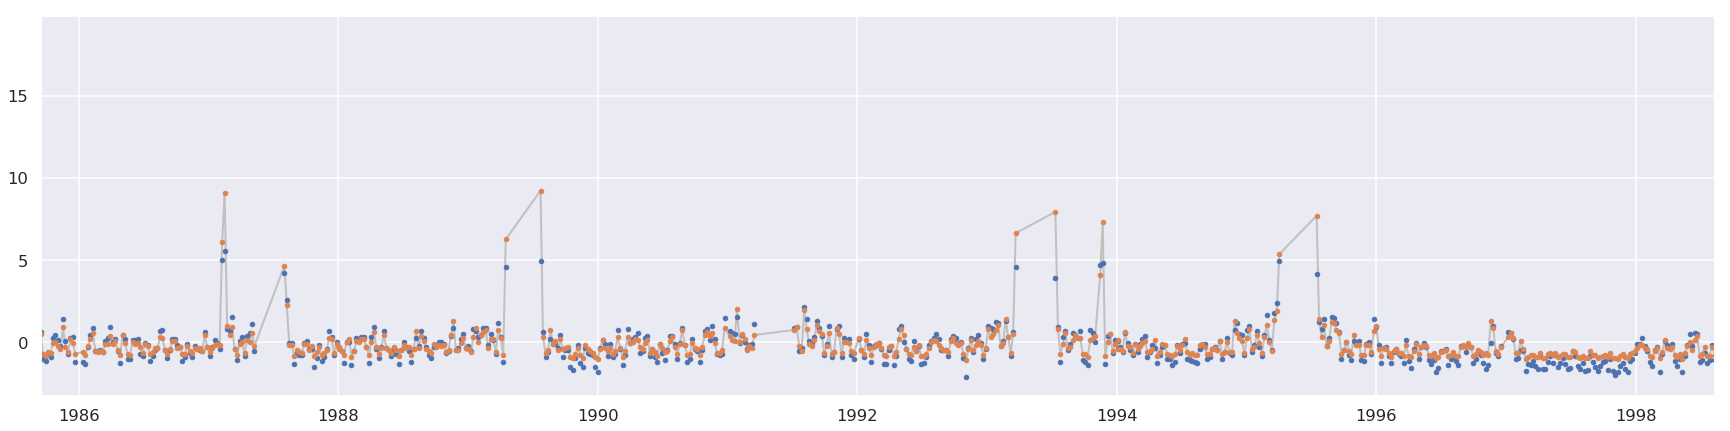

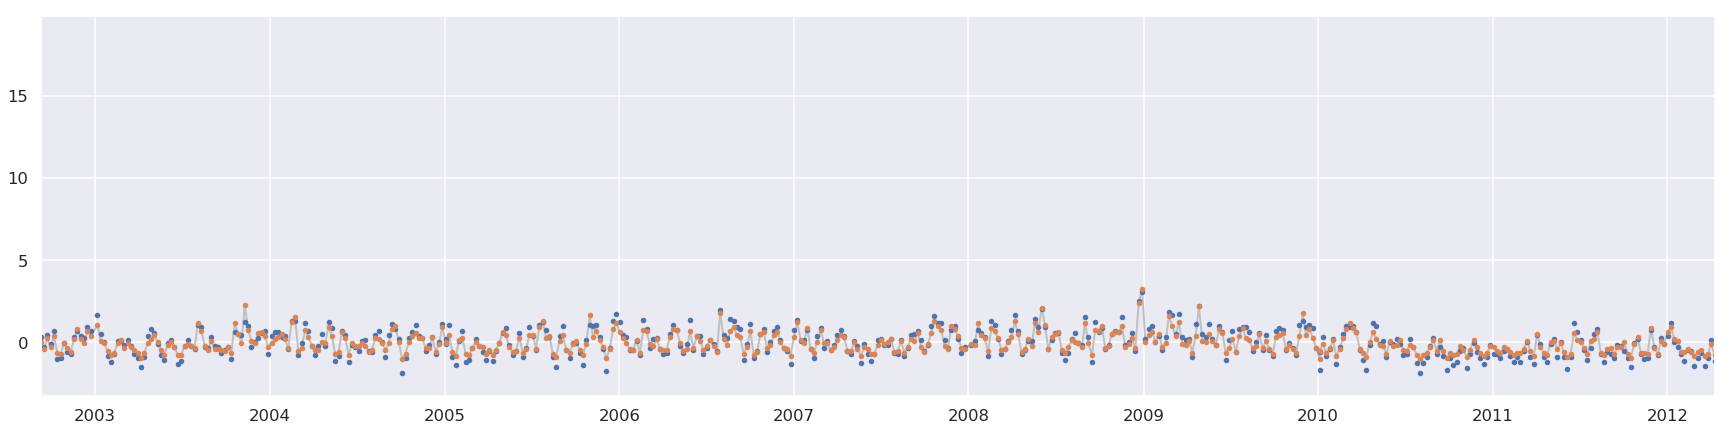

In [593]:
for xlim in [(0,900),(1900,2500),(2700,3200)]:

    fig, ax = plt.subplots(figsize=(30,7))

    ax.plot(x, standardise(y2), '-', c='silver', lw=2)
    ax.plot(x, standardise(y1), '.', label='pedersen')
    ax.plot(x, standardise(y2), '.', label='KL')

    ax.set_xlim(x[xlim[0]],x[xlim[1]])
    #ax.set_ylim(-4,4)

    plt.show()

In [467]:
relevant_weeks = dates[1:][ y2 > 1.7 ]
print(relevant_weeks, '\n')

relevant_dates = [ datetime.strptime(d + '-1', "%Y-%W-%w").date() for d in relevant_weeks ]

df = pd.DataFrame([ tuple(str(i).split('-')) for i in relevant_dates ],
                               columns=['year','month','day'])
del df['day']
df = df.drop_duplicates()
df = df.set_index(['year'])

for year in df.index.unique():
    print(year,':',df[df.index==year].month.values)

Index(['1948-37', '1948-42', '1948-44', '1958-29', '1958-33', '1987-06',
       '1987-07', '1989-16', '1989-30', '1993-12', '1993-28', '1993-47',
       '1995-29'],
      dtype='object') 

1948 : ['09' '10' '11']
1958 : ['07' '08']
1987 : ['02']
1989 : ['04' '07']
1993 : ['03' '07' '11']
1995 : ['07']


- Oct-Nov 1948
- Jul-Ago 1958
- Feb 1987
- Jul 1989
- Mar, Jul, Nov 1993
- Jul 1995

In [88]:
relevant_weeks = ['1948-37', '1948-42', '1948-44', '1958-29', '1958-33', '1987-06',
                  '1987-07', '1989-16', '1989-30', '1993-12', '1993-28', '1993-47','1995-29']

relevant_weeks

['1948-37',
 '1948-42',
 '1948-44',
 '1958-29',
 '1958-33',
 '1987-06',
 '1987-07',
 '1989-16',
 '1989-30',
 '1993-12',
 '1993-28',
 '1993-47',
 '1995-29']

## Next: what was happening to the agenda in those periods?

In [83]:
agendas_data['Times-week'].head()

0         1         2         3         4         5         6  \
1947-01  0.023123  0.209057  0.056527  0.043301  0.006891  0.009181  0.011227   
1947-02  0.053292  0.109531  0.031776  0.036818  0.011393  0.012941  0.027925   
1947-03  0.095907  0.080157  0.010331  0.019950  0.024170  0.019965  0.032930   
1947-04  0.119769  0.018321  0.028138  0.025599  0.015316  0.015893  0.030564   
1947-05  0.052991  0.012635  0.019639  0.028895  0.028518  0.015917  0.031060   

                7         8         9  ...        40        41        42  \
1947-01  0.001669  0.019802  0.003977  ...  0.010256  0.001507  0.006241   
1947-02  0.005839  0.066028  0.003660  ...  0.006961  0.002156  0.011506   
1947-03  0.007150  0.102207  0.001410  ...  0.006974  0.002599  0.003924   
1947-04  0.006457  0.047720  0.005078  ...  0.007142  0.004302  0.005064   
1947-05  0.009491  0.099665  0.002041  ...  0.005949  0.004985  0.003412   

               43        44        45        46        47        48        49  
1947-01  0.001611  0.014859  0.009279  0.024093  0.005570  0.010903  0.005690  
1947-02  0.003398  0.010714  0.020174  0.026277  0.022402  0.029926  0.005879  
1947-03  0.002740  0.017826  0.002612  0.047521  0.085528  0.029527  0.015967  
1947-04  0.008679  0.004556  0.039897  0.009222  0.024148  0.082094  0.003454  
1947-05  0.005792  0.015704  0.054910  0.032567  0.031596  0.071757  0.014979  

[5 rows x 50 columns]

In [ ]:
df = documents_per_topic[['Topic 1']].copy()
df['day'] = [ i[:10] for i in df.index ]
articles_per_day = df.groupby('day').count()
articles_per_day.columns=['n_articles']
articles_per_day.head()

In [503]:
def show_agenda_window(full_agenda, date, window=10, n_topics=12):

    idx_date = np.where( full_agenda.index == date )[0][0]
    agenda   = full_agenda.iloc[idx_date-window:idx_date+window]
    ENI      = dfs_measures['Times-week']['ENI'].iloc[idx_date-window:idx_date+window]
    KL       = dfs_measures['Times-week']['KL'].iloc[idx_date-window:idx_date+window]

    top_indices = agenda.sum(axis=0).sort_values().index[:n_topics]
    top_indices = [str(i) for i in range(50)]
    
    
    d = date
    date_of_interest = datetime.strptime(d + '-1', "%Y-%W-%w").date()#.strftime("%Y-%m-%d")

    # find closest date in articles per day
    corresponding_date = articles_per_day.index[0]
    mindelta = np.infty
    for day in articles_per_day.index:
        d = datetime.strptime(day, "%Y-%m-%d").date()
        delta = np.abs((d-date_of_interest).days)
        if delta < mindelta:
            mindelta = delta
            corresponding_date = day
    corresponding_index = np.where(articles_per_day.index==corresponding_date)[0][0]
    
    t = [ datetime.strptime(d + '-1', "%Y-%W-%w").date() for d in agenda.index ]

    start = pd.Timestamp(min(t))
    end   = pd.Timestamp(max(t))
    #ticks = pd.to_datetime( np.linspace(start.value, end.value, len(t) ) )
    ticks = t

    fig = plt.figure(figsize=(18,3))
    full_agenda.loc[date].plot.bar()
    plt.yscale('log')
    plt.show()      
    
    fig, ax = plt.subplots(figsize=(18,3))
    series_plot = articles_per_day['n_articles'].head(corresponding_index+window).tail(2*window+1)
    ax.plot(t[:-1], series_plot.values[2:], '.-')
    ax.set_xticks(ticks)
    ax.set_xticklabels([ i.strftime('%d %b %Y') for i in ticks ], rotation=90)
    ax.set_ylabel('number of articles')
    plt.show()         
    
    fig, ax = plt.subplots(figsize=(18,3))
    ax.plot(t, ENI, '.-')
    ax.set_ylabel('ENI (Diversity)')
    ax.set_xticks(ticks)
    ax.set_xticklabels([ i.strftime('%d %b %Y') for i in ticks ], rotation=90)
    plt.show()

    fig, ax = plt.subplots(figsize=(18,3))
    ax.plot(t, KL, '.-')
    ax.set_ylabel('KL (Novelty)')
    ax.set_xticks(ticks)
    ax.set_xticklabels([ i.strftime('%d %b %Y') for i in ticks ], rotation=90)
    plt.show()

    ticks = pd.to_datetime( np.linspace(start.value, end.value, 10) )
    
    fig, axs = plt.subplots(10,5,figsize=(22,27))
    axs = axs.flatten()
    
    for ax,idx in zip(axs,top_indices):
        ax.plot(t, agenda[idx], '.-', ms=7, lw=3)
        ax.set_title('Topic {}'.format(int(idx)+1))
        ticks = pd.to_datetime( np.linspace(start.value, end.value, 4) )
        ax.set_xticks(ticks)
        ax.set_xticklabels([ i.strftime('%d %b') for i in ticks ])
        #ax.set_yticks([])

    #ax.legend(bbox_to_anchor=(1.01, 0.85), ncol=1, fancybox=True, shadow=True)    
    
    plt.tight_layout()
    plt.show()

1948-09-13


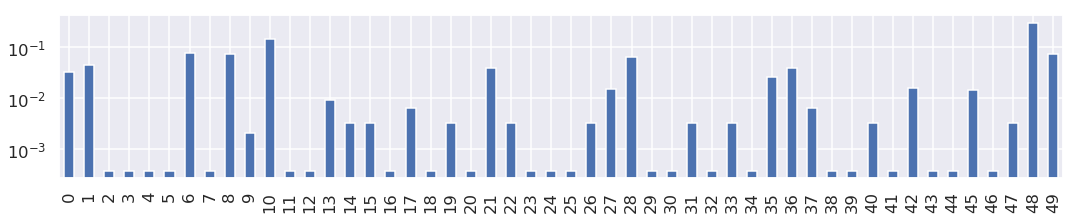

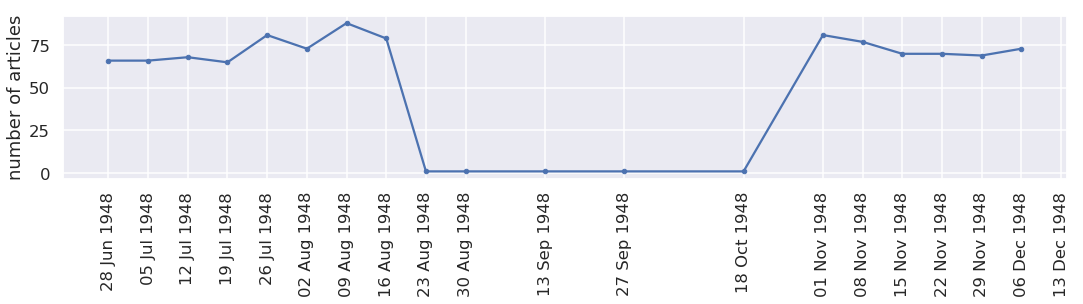

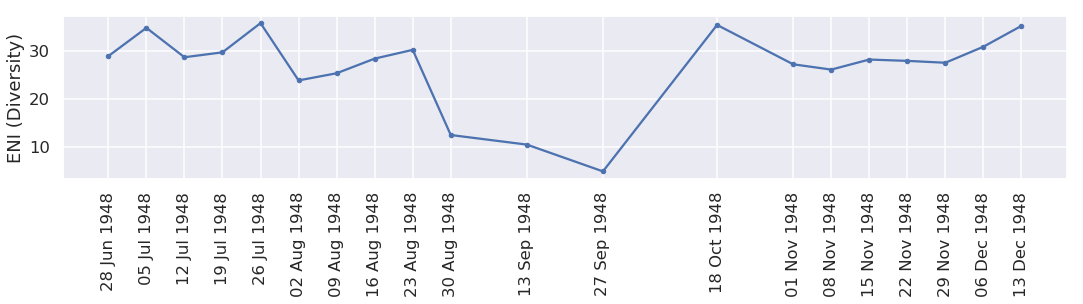

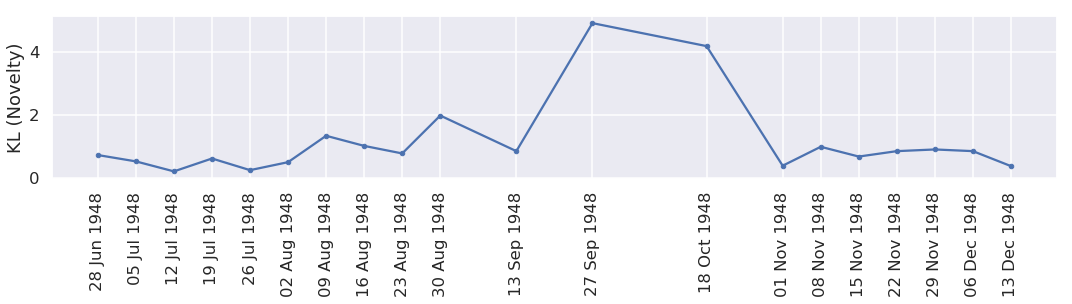

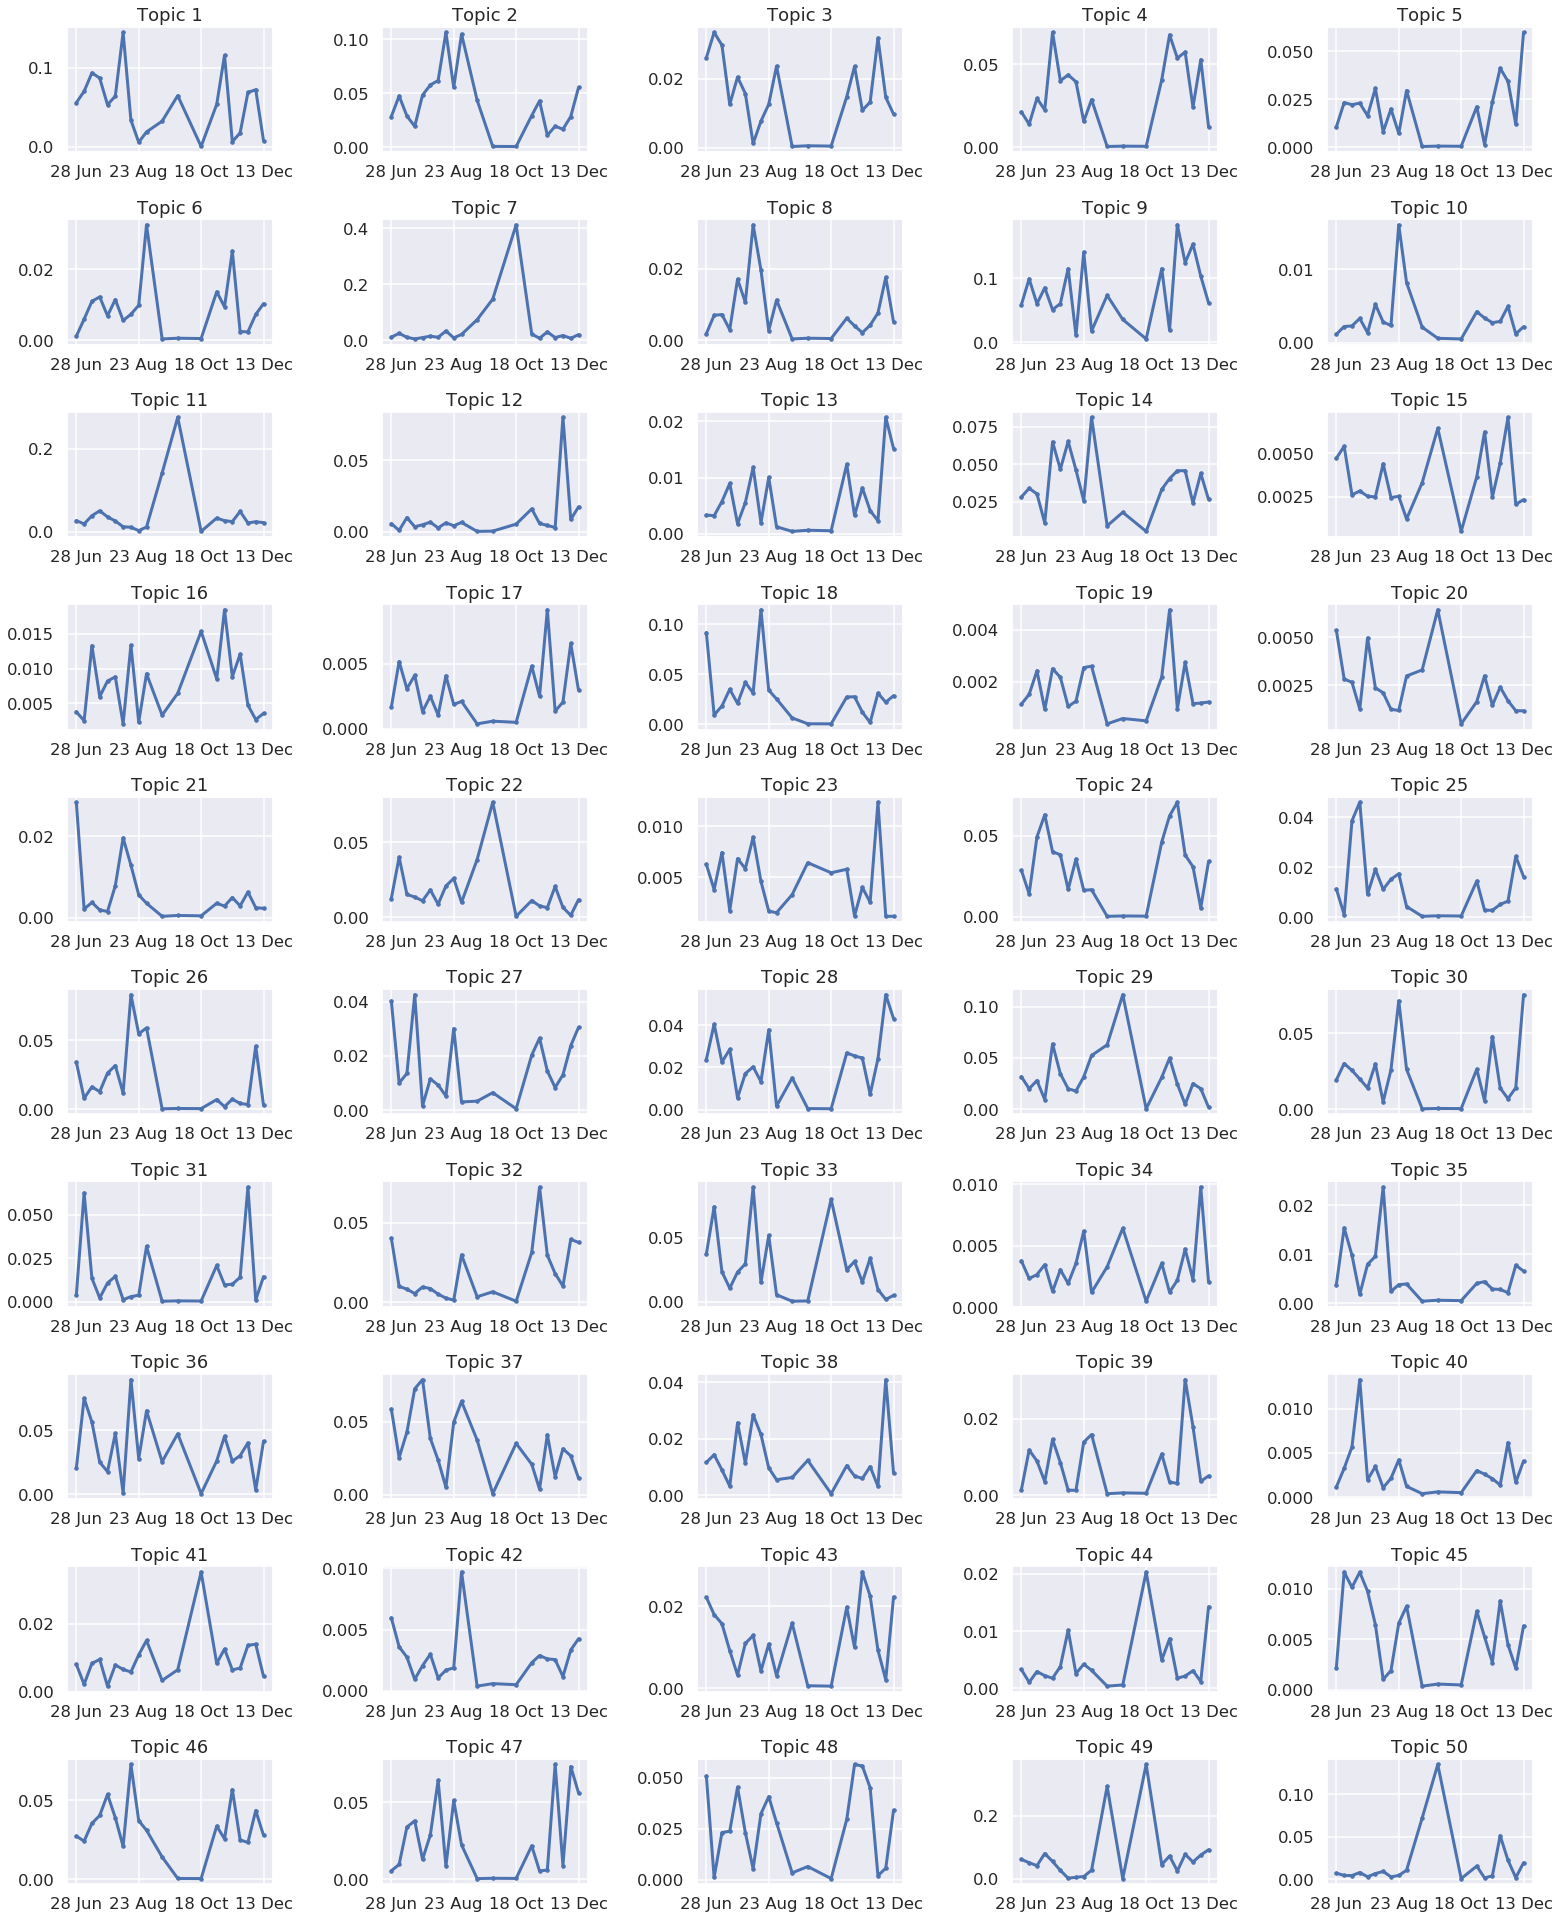

In [504]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[0]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [ ]:
infile = 'UK_media/times_data/document_topic_distributions_50topics.csv'

documents_per_topic = pd.read_csv(infile, index_col=0)

In [85]:
infile = 'UK_media/times_data/topic_word_distributions_50topics.csv'
words_per_topic = pd.read_csv(infile, index_col=0)

def examine_topic(n, words=15):
    return words_per_topic.loc['Topic {}'.format(n)].sort_values(ascending=False)[:words]

In [509]:
examine_topic(50)

government    0.029011
bill          0.022580
house         0.022427
minister      0.015043
lord          0.014377
lab           0.012244
opposition    0.011382
time          0.008010
asked         0.007642
commons       0.007617
secretary     0.006693
cheers        0.006641
amendment     0.006122
lords         0.006086
prime         0.005985
Name: Topic 49, dtype: float64

In [511]:
examine_topic(29)

water      0.017875
years      0.008233
land       0.007921
north      0.007199
miles      0.006788
good       0.006655
farmers    0.006612
sea        0.006340
south      0.006098
farm       0.005883
food       0.005830
weather    0.005787
island     0.005509
found      0.005483
river      0.005459
Name: Topic 29, dtype: float64

In [507]:
examine_topic(49)

government    0.029011
bill          0.022580
house         0.022427
minister      0.015043
lord          0.014377
lab           0.012244
opposition    0.011382
time          0.008010
asked         0.007642
commons       0.007617
secretary     0.006693
cheers        0.006641
amendment     0.006122
lords         0.006086
prime         0.005985
Name: Topic 49, dtype: float64

In [508]:
examine_topic(7)

local          0.028993
council        0.023913
building       0.019472
london         0.018171
city           0.015215
housing        0.014431
land           0.011580
houses         0.010295
planning       0.010266
development    0.009750
area           0.009509
town           0.009107
authorities    0.008944
people         0.008883
site           0.008139
Name: Topic 7, dtype: float64

## This event is:

Probably the Boeing strike of 1948, which ended in September 13 after almost five months when the Union members reluctantly went back to work.

______________

## Next:

In [406]:
print([ i for i in articles_per_day.index if '1958-08' in i] )
articles_per_day.loc['1958-07-09']

['1958-08-13', '1958-08-20', '1958-08-27']


n_articles    102
Name: 1958-07-09, dtype: int64

1958-07-21


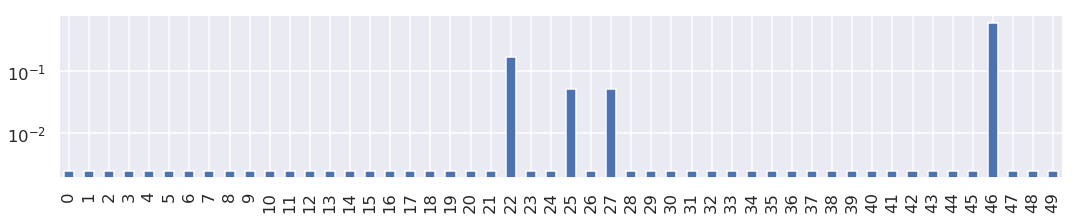

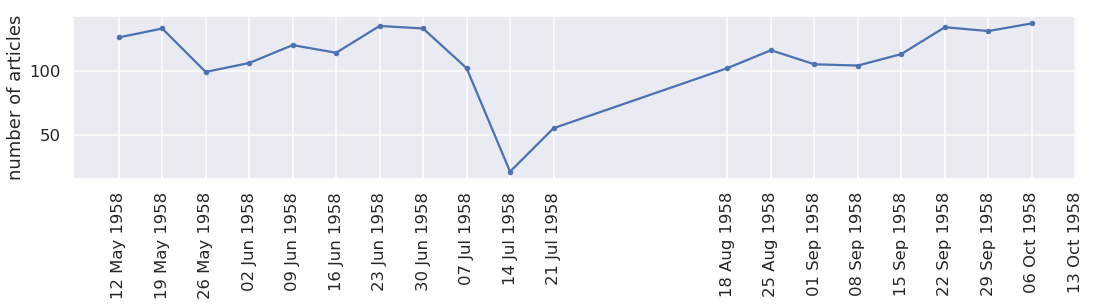

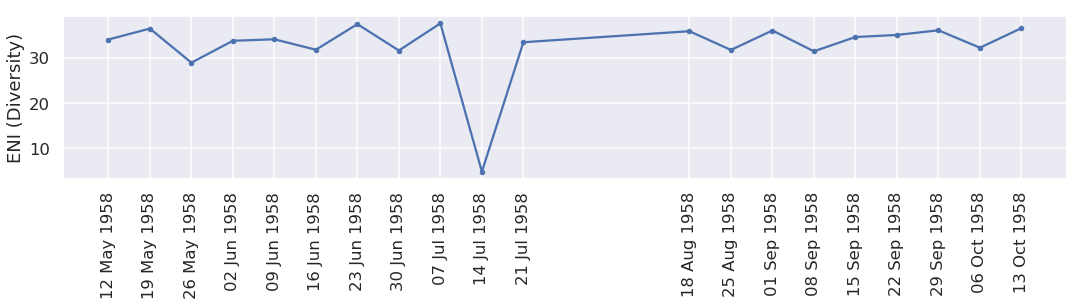

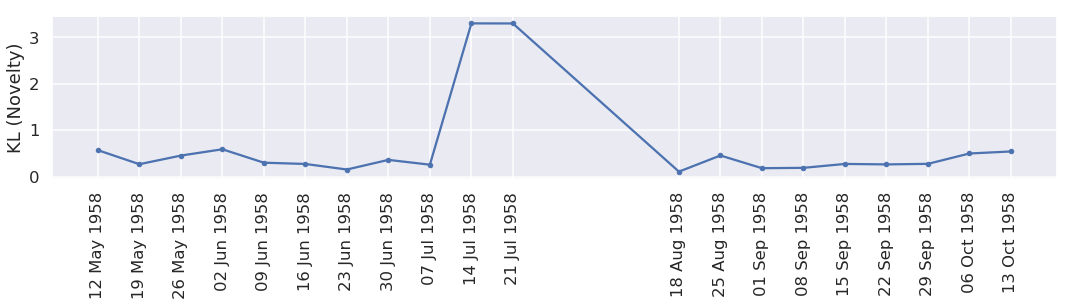

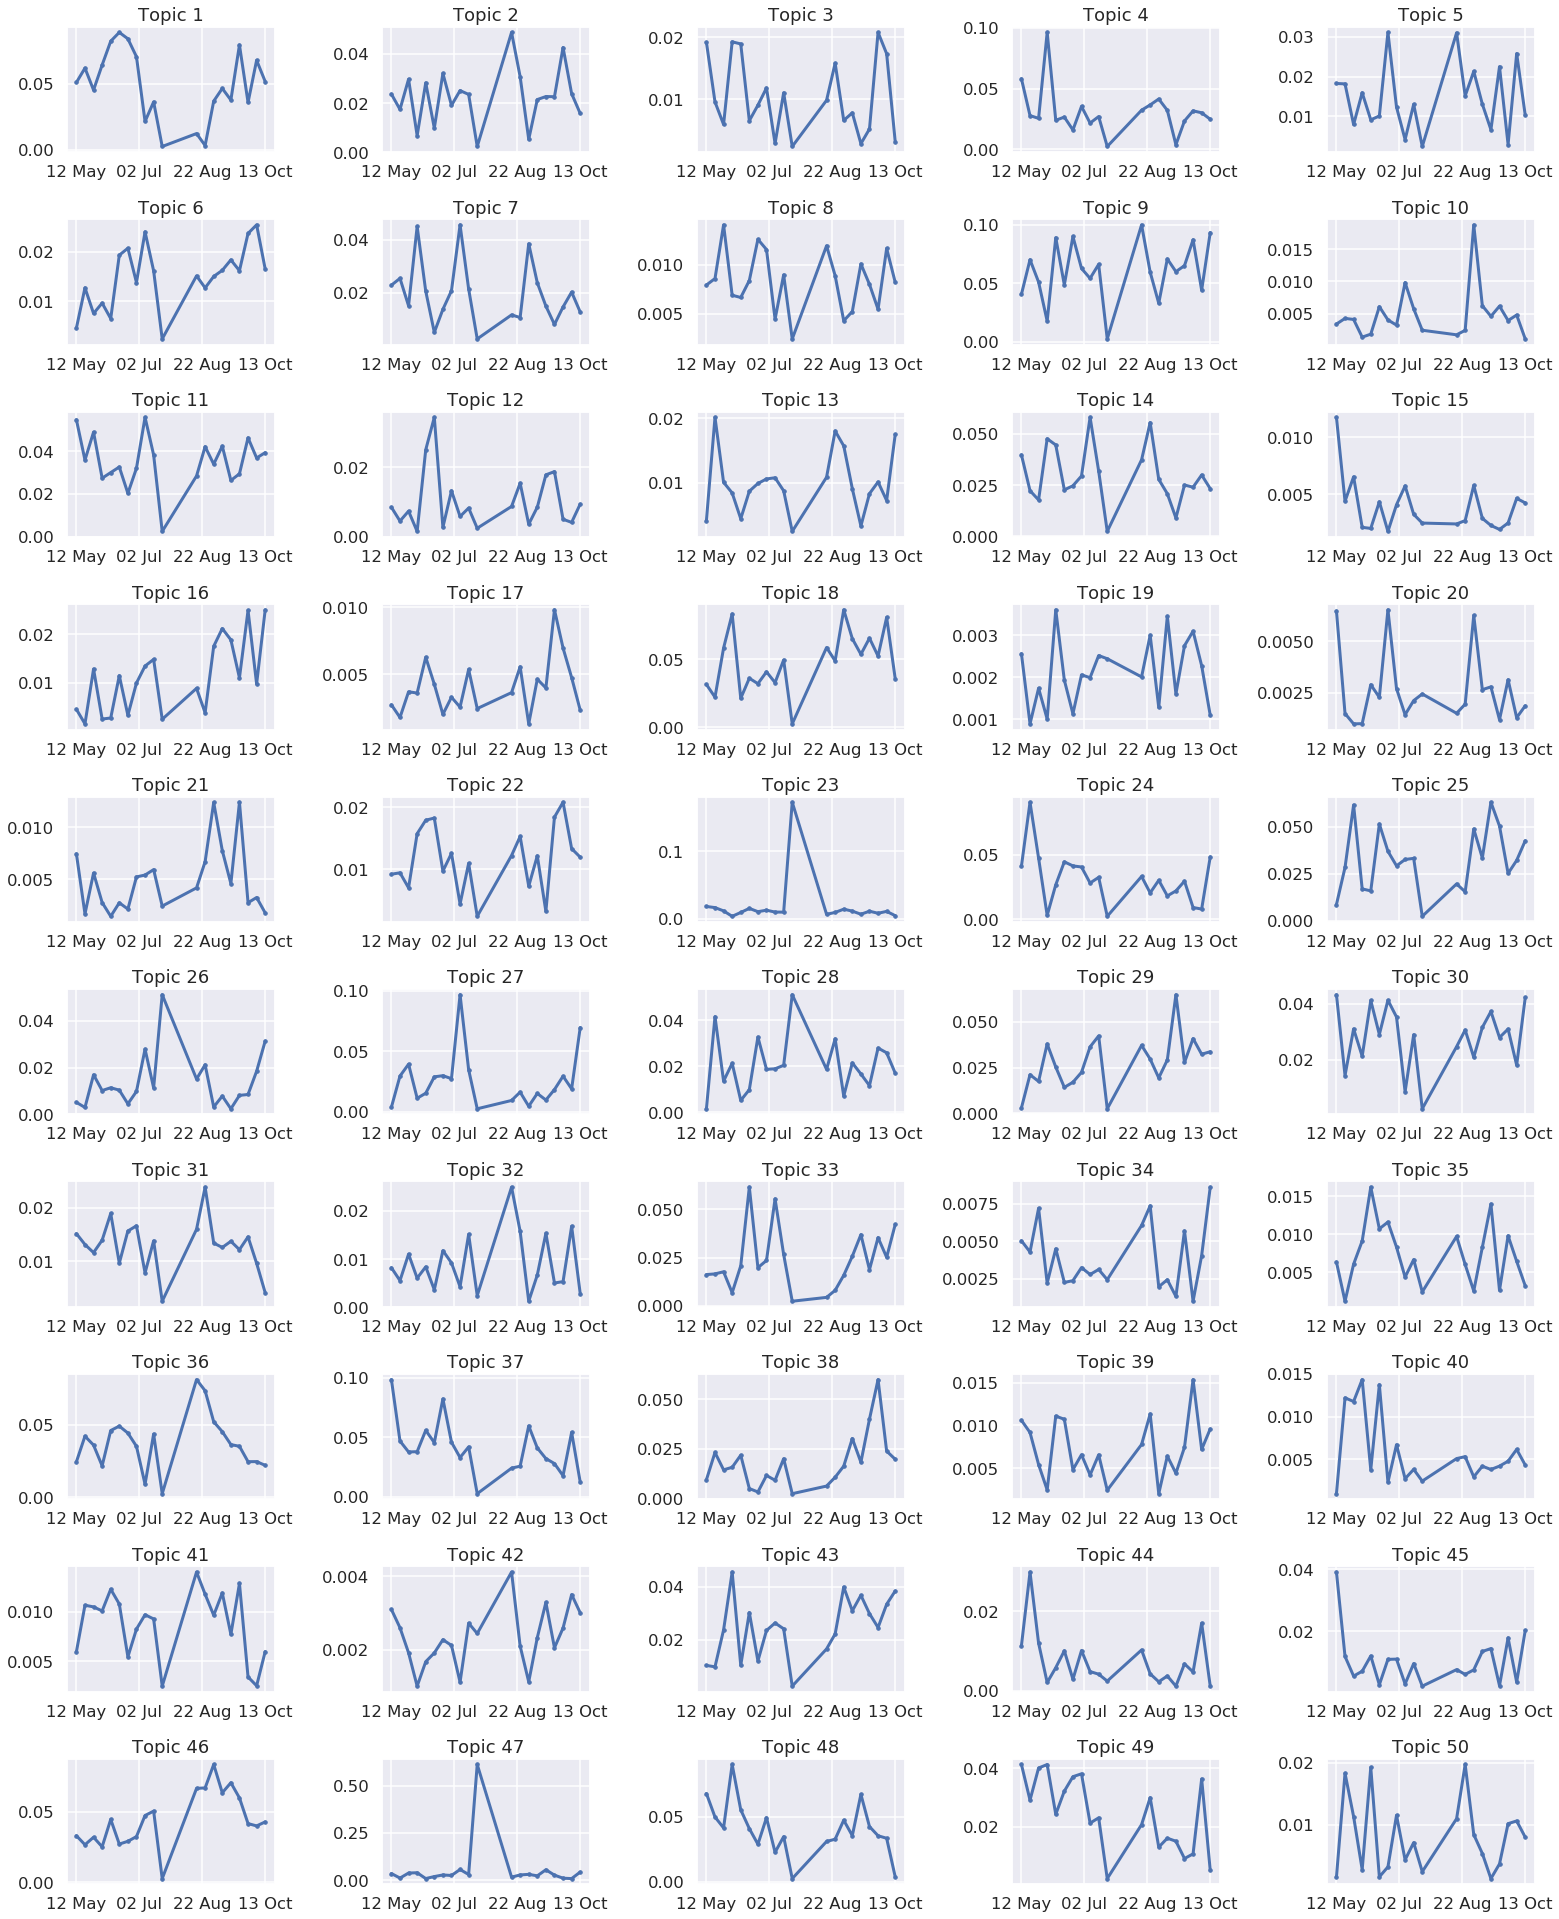

In [716]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[3]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [717]:
examine_topic(50)

television     0.036384
news           0.023357
bbc            0.022161
radio          0.020623
advertising    0.015373
times          0.014239
press          0.014064
media          0.012080
newspaper      0.011919
film           0.011633
newspapers     0.011401
programme      0.010875
daily          0.010184
paper          0.009124
editor         0.008657
Name: Topic 50, dtype: float64

In [718]:
examine_topic(22)

european     0.051197
french       0.046078
france       0.037111
europe       0.034449
britain      0.032520
british      0.023546
paris        0.020754
germany      0.017881
community    0.017430
italy        0.016458
japan        0.015866
countries    0.015510
japanese     0.013265
spain        0.012985
german       0.012903
Name: Topic 22, dtype: float64

1958-29


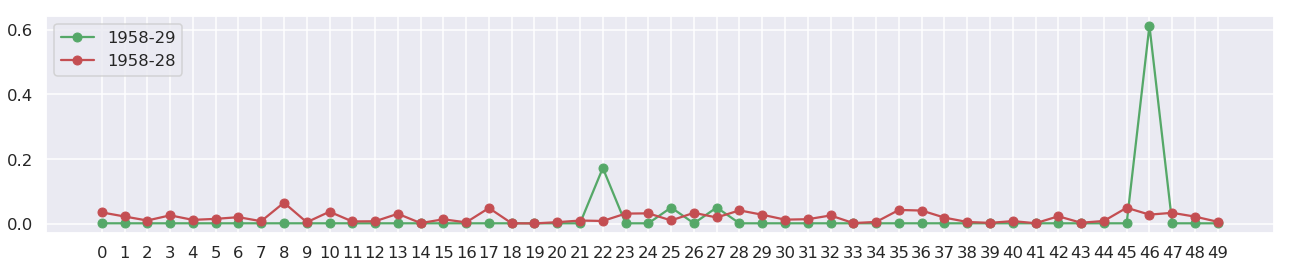

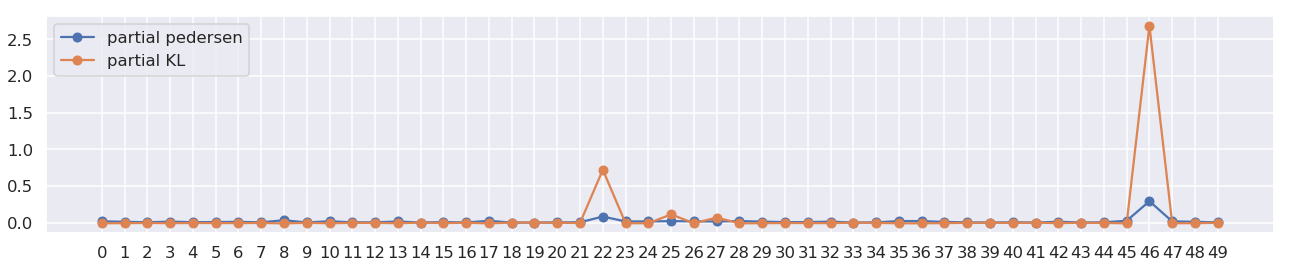

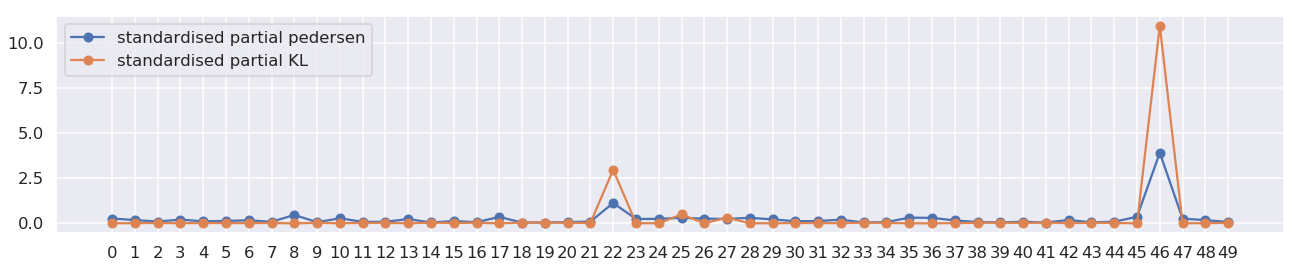

1958-28:
22    0.009687
46    0.029235
Name: 1958-28, dtype: float64 

1958-29:
22    0.173171
46    0.612195
Name: 1958-29, dtype: float64 

      KL(1958-28 -> 1958-29): 3.302952
pedersen(1958-28 -> 1958-29): 0.817358


In [719]:
print(date)
date    = '1958-29'
date_m1 = '1958-28'

u, v = full_agenda.loc[date], full_agenda.loc[date_m1]

partial_pedersen = np.abs(u - v)/2
partial_KL       = np.array([ p*np.log(p/q) for p,q in zip(u,v) ])*entropy_correction


fig, ax = plt.subplots(figsize=(22,4))
ax.plot(u, 'o-g', label=date)
ax.plot(v, 'o-r', label=date_m1)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(partial_pedersen, 'o-', label='partial pedersen')
ax.plot(partial_KL, 'o-', label='partial KL')
plt.legend()
plt.show()

s_partial_pedersen = (partial_pedersen-0)/pedersen_std
s_partial_KL       = (partial_KL-0)/KL_std

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(s_partial_pedersen, 'o-', label='standardised partial pedersen')
ax.plot(s_partial_KL, 'o-', label='standardised partial KL')
plt.legend()
plt.show()

print(date_m1+':')
print(v[[22, 46]],'\n')

print(date+':')
print(u[[22, 46]],'\n')

print('      KL({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_KL)))
print('pedersen({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_pedersen)))

**So on this date the two measures are very different because it was a SURPRISING jump.**

## And was it a surprising jump?

What do we see in the news?

1958-07-16
The 14 July Revolution, also known as the 1958 Iraqi coup d'état, which resulted in the overthrow of the Hashemite monarchy in Iraq. Many texts about troops being deployed and Arab nationalism.

But the actual jump is due to:
1. A very small number of articles OCR'ed on that day, for some reason, and 
2. this random piece about liner ship itineraries below.

In [653]:
def print_top_articles(date_str, n_topic, n_top_articles=5, plot=False):
    #date_str = datetime.strptime(date + '-1', "%Y-%W-%w").date().strftime('%Y-%m')
    print(date_str,'\n')

    idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
    df_filtered  = documents_per_topic.loc[idx_filtered]

    top_articles = df_filtered.sort_values('Topic {}'.format(n_topic), ascending=False).index[:n_top_articles]

    for article_id in top_articles:
        infile = 'UK_media/scraping_times/data/OCRtext/' + article_id

        with open(infile) as f:
            if plot:
                fig, ax = plt.subplots(figsize=(15,3))
                df_filtered.loc[article_id].plot.bar(ax=ax)
                plt.title(article_id)
                plt.show()
                
            print(article_id)            
            print('Topic {}: {:.6f}'.format(n_topic, df_filtered.loc[article_id]['Topic {}'.format(n_topic)]))
            print()
            s = f.read()
            print(s[272:], '\n')
            
def find_in_articles(date_str, query):
    print(date_str,'-',query,'\n')

    idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
    df_filtered  = documents_per_topic.loc[idx_filtered]

    for article_id in df_filtered.index:
        infile = 'UK_media/scraping_times/data/OCRtext/' + article_id

        with open(infile) as f:
            s = f.read()
            if query in s:
                print(article_id)
                print(s[272:], '\n')

In [482]:
idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
df_filtered  = documents_per_topic.loc[idx_filtered]

df_filtered[['Topic 46','Topic 22']].sort_values(['Topic 46','Topic 22'], ascending=False).head(10)

Topic 46  Topic 22
1958-07-16/218_GALE_CS285695185.txt  0.083673  0.002041
1958-07-16/210_GALE_CS302603990.txt  0.036996  0.000366
1958-07-16/213_GALE_CS253581530.txt  0.004762  0.004762
1958-07-16/197_GALE_CS286613206.txt  0.002941  0.091176
1958-07-16/202_GALE_CS269310704.txt  0.002439  0.002439
1958-07-16/216_GALE_CS286350064.txt  0.002273  0.161364
1958-07-16/212_GALE_CS118576838.txt  0.001754  0.001754
1958-07-16/206_GALE_CS117790406.txt  0.001493  0.001493
1958-07-16/217_GALE_CS285564113.txt  0.001389  0.029167
1958-07-16/214_GALE_CS303259350.txt  0.001163  0.001163

In [483]:
date_str = '1958-07-16'
#date_str = '1958-07'

print_top_articles(date_str, 46, n_top_articles=1)
#find_in_articles(date_str,'Commonwealth')

1958-07-16 

1958-07-16/218_GALE_CS285695185.txt
Topic 46: 0.083673

Movements Of Liners
MOVEMENTS OF LINERS
FROM LLOYLYS
FAIRSEA and JOHAN VAN OLDENBARNEVELT. both fm. Sydney. and MAASDANt fm N.Y. all due Sthmtn. 18. ARYADIA. tm. Motitreai. due'Ldn. II. SYLVANIA. fm. Montreal. due Greenock 18. and L'pool 19. QUEEN ELIZABETH. Cm. N.Y,* anfd. Sthnaog. 15. CARTHAGE, fmt. Hongktona for Ldn.. arrd, Colombo Roads 16. ROCKNAMPTON STAR. fm. Adelaide for Ldn.. Psid. Gibraltar 16. IVERNIA. for Mo,ntreal. left Sthitnn. 16. AMERICA. for N.Y.. left StbmIn. 16 ASIA. for Lda.. left Mointreal 13.
DURBAN CASTLE. fm Ldn.. aed. Port Elizabeth 15. PRETORIA CASTLE. tm. Sthtlmn. for Durban. left Las Palmtas 15. COLUMBIA STAR. tmn. Van. couver foe L'veol. rrd. Everett 15. CANADIAN STA. lt.L~po8 ard.Columbita River 14. EMPIRE STAR. Cfm. Lvdn- ad. CDunedIn 16. EMPRESS OF ENGLAND *m. MonUtreal aced L'voo 16. STAF. FORDSI{RE. fm. Rangoon; for Ldn.. cpsad. Gibealtar 15. TOWNS CmS LdE.LrnM arrd nAdto' ade5 I CAPE

________________

## Next:

In [489]:
relevant_weeks

['1948-37',
 '1948-42',
 '1948-44',
 '1958-29',
 '1958-33',
 '1987-06',
 '1987-07',
 '1989-16',
 '1989-30',
 '1993-12',
 '1993-28',
 '1993-47',
 '1995-29']

1987-02-09


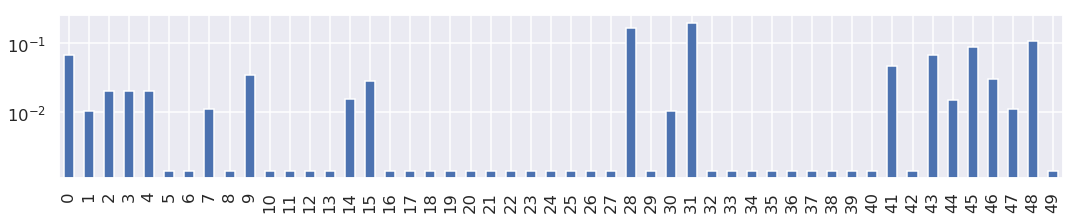

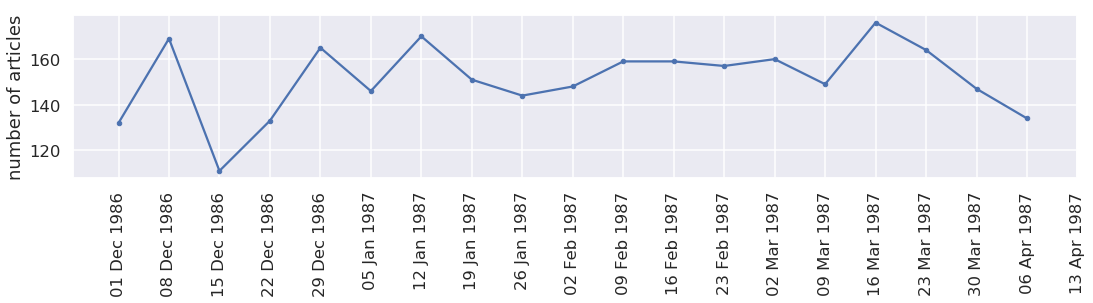

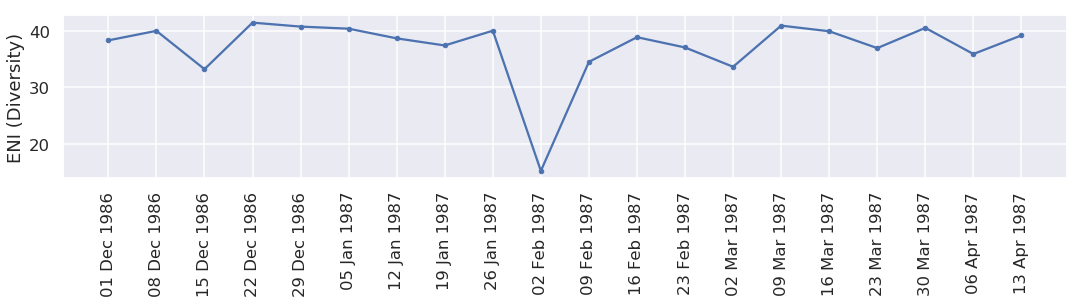

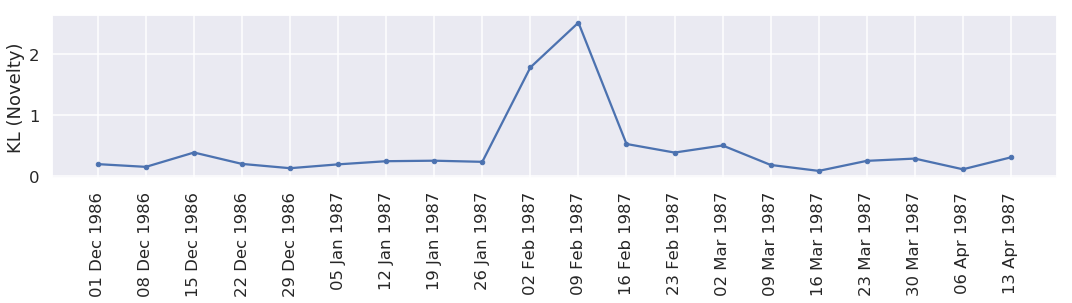

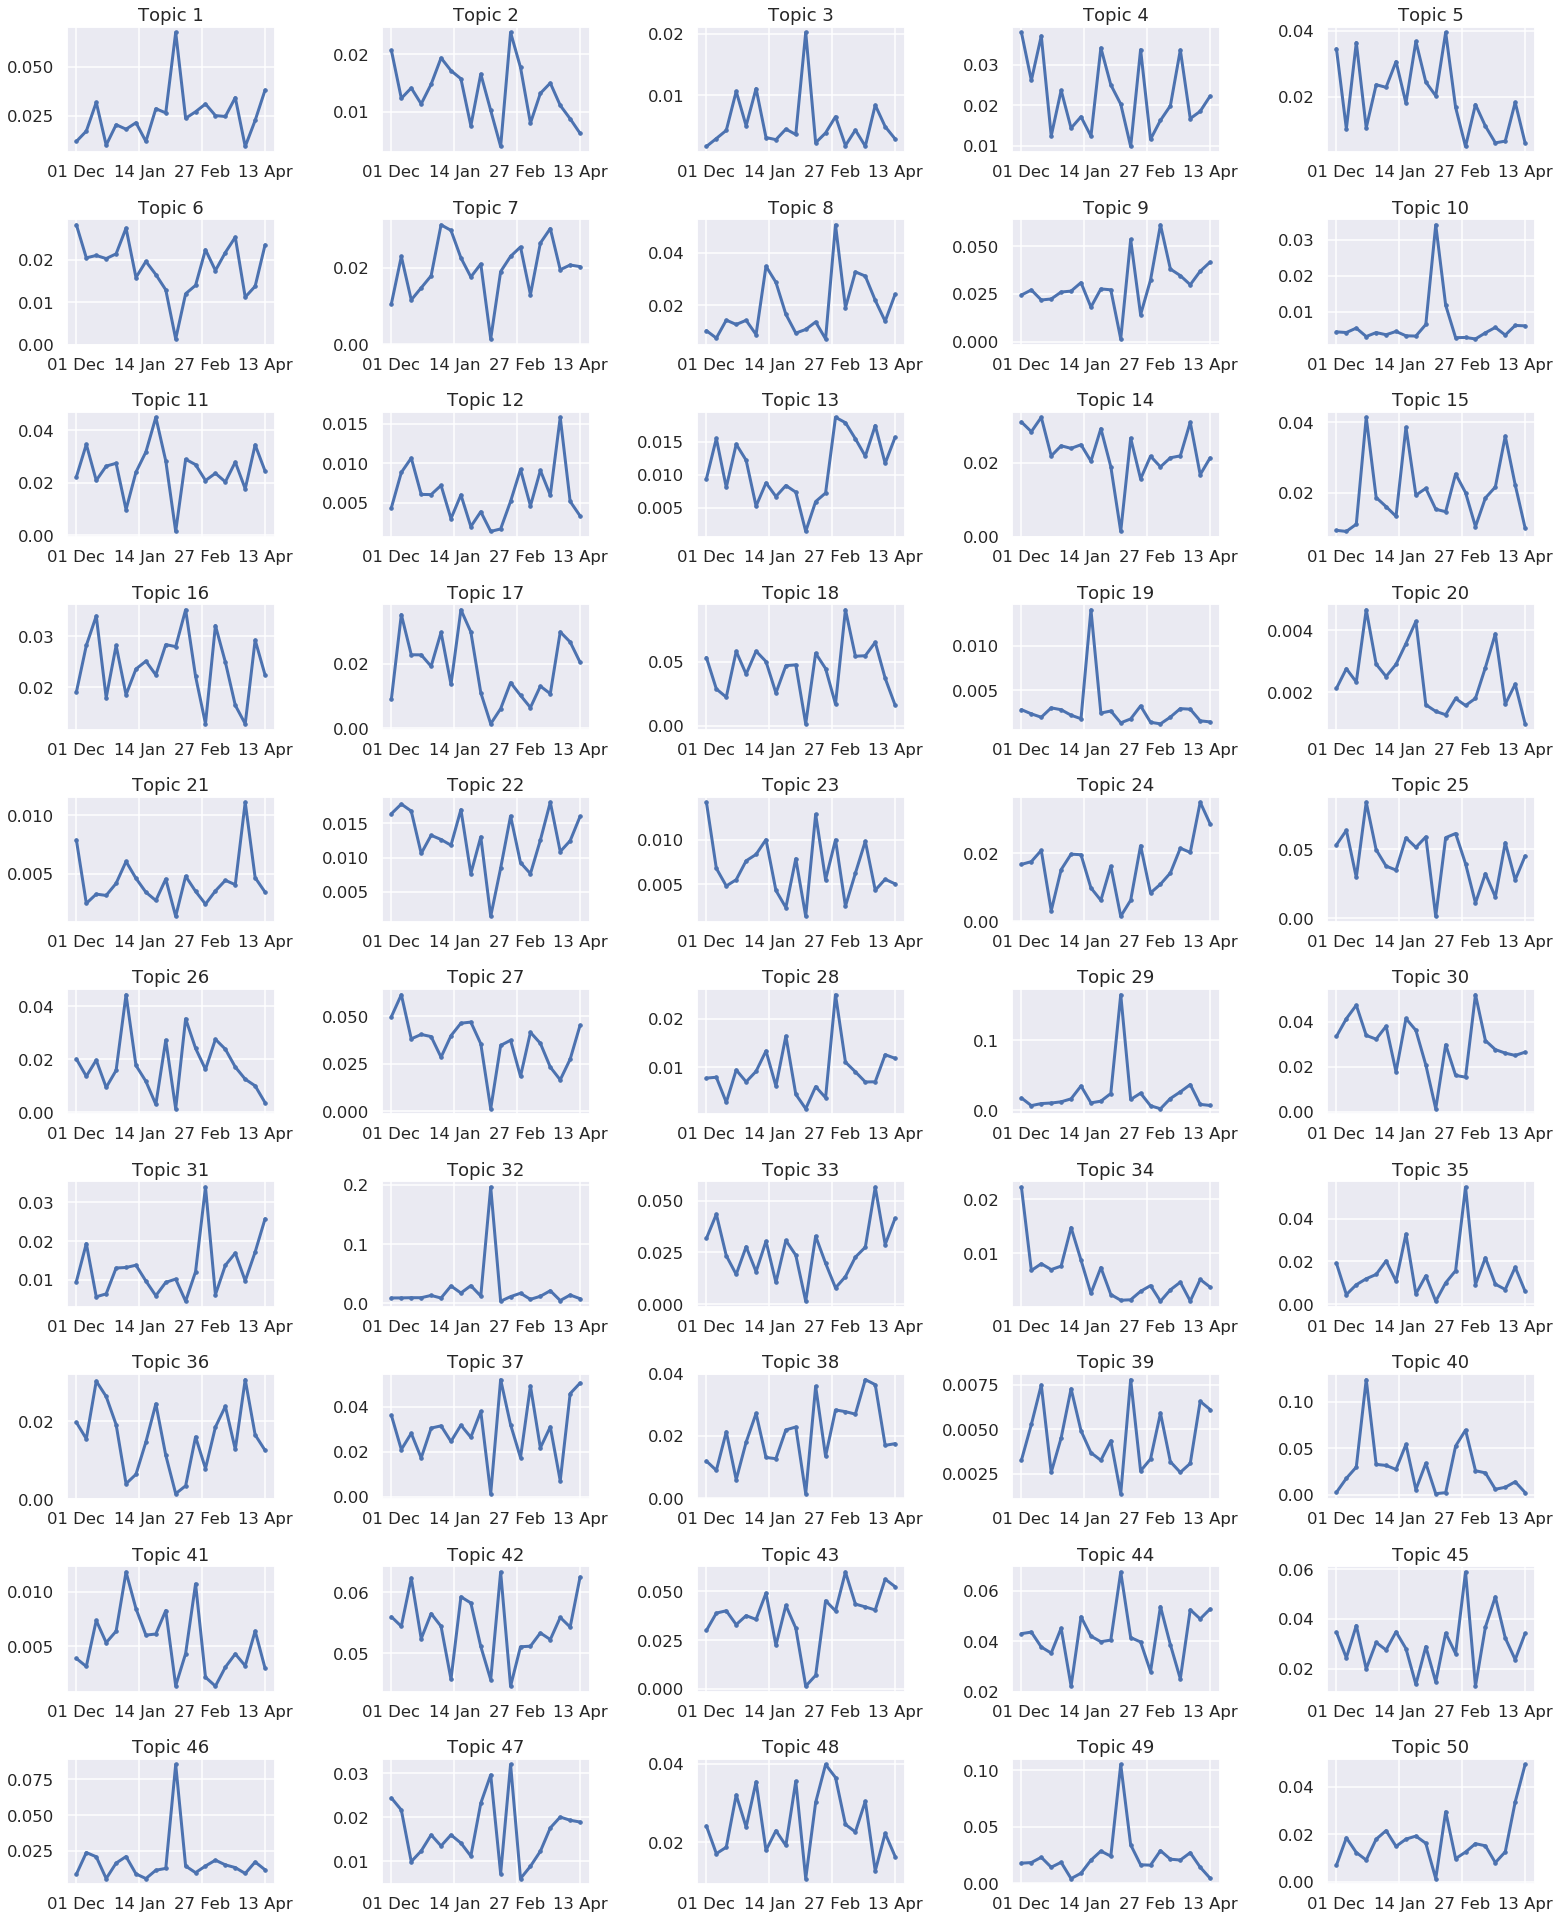

In [543]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[5]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [643]:
topics = [29,32] # ,49,46,10]

for topic in topics:
    print(examine_topic(topic), '\n')

water      0.017875
years      0.008233
land       0.007921
north      0.007199
miles      0.006788
good       0.006655
farmers    0.006612
sea        0.006340
south      0.006098
farm       0.005883
food       0.005830
weather    0.005787
island     0.005509
found      0.005483
river      0.005459
Name: Topic 29, dtype: float64 

cent         0.073389
prices       0.015164
increase     0.013270
rise         0.013134
figures      0.013118
rate         0.011549
growth       0.011111
inflation    0.010069
price        0.009285
average      0.008090
economic     0.007565
economy      0.007514
months       0.007370
rates        0.007169
quarter      0.006946
Name: Topic 32, dtype: float64 



In [544]:
print(date)

1987-06


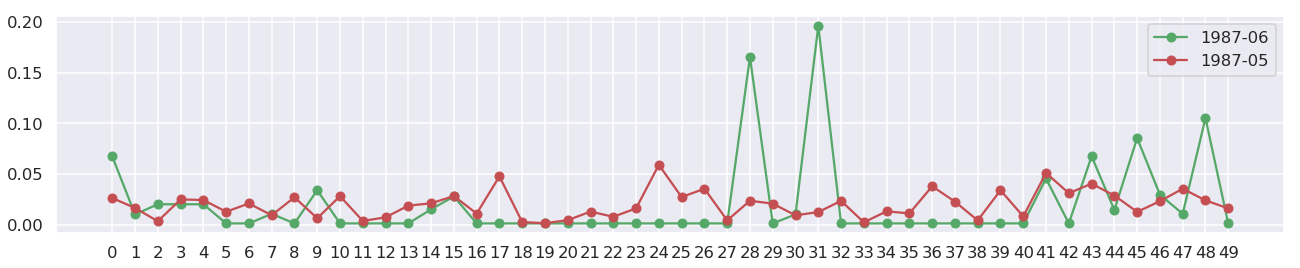

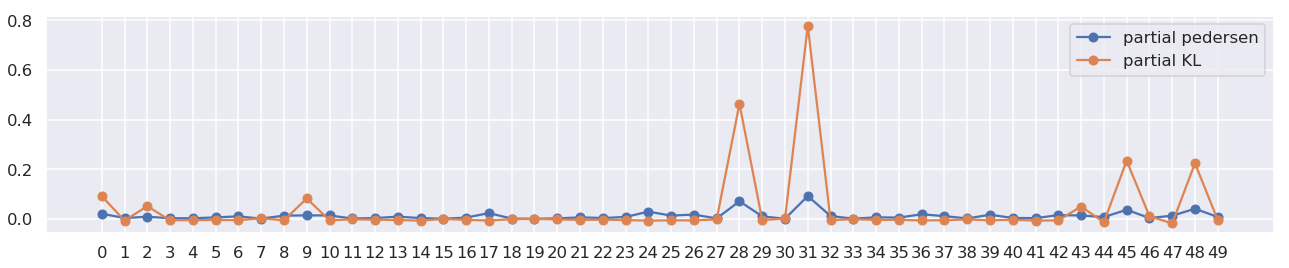

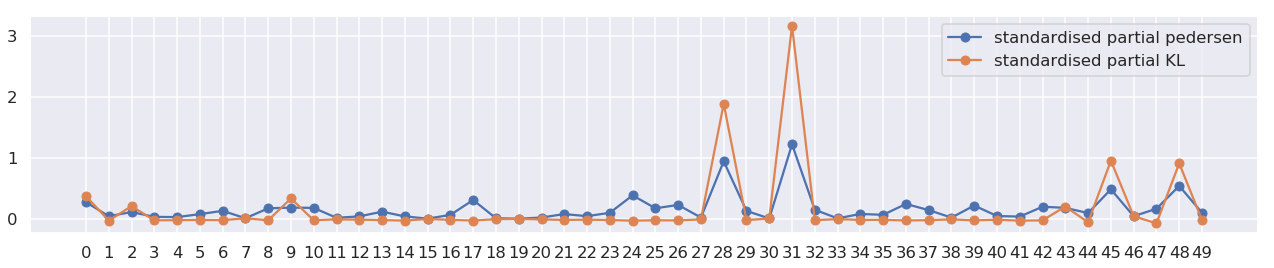

1987-05:
28    0.023696
31    0.012536
Name: 1987-05, dtype: float64 

1987-06:
28    0.165353
31    0.196076
Name: 1987-06, dtype: float64 

      KL(1987-05 -> 1987-06): 1.780573
pedersen(1987-05 -> 1987-06): 0.599946


In [610]:
date    = '1987-06'
date_m1 = '1987-05'

u, v = full_agenda.loc[date], full_agenda.loc[date_m1]

partial_pedersen = np.abs(u - v)/2
partial_KL       = np.array([ p*np.log(p/q) for p,q in zip(u,v) ])*entropy_correction

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(u, 'o-g', label=date)
ax.plot(v, 'o-r', label=date_m1)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(partial_pedersen, 'o-', label='partial pedersen')
ax.plot(partial_KL, 'o-', label='partial KL')
plt.legend()
plt.show()

s_partial_pedersen = (partial_pedersen-0)/pedersen_std
s_partial_KL       = (partial_KL-0)/KL_std

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(s_partial_pedersen, 'o-', label='standardised partial pedersen')
ax.plot(s_partial_KL, 'o-', label='standardised partial KL')
plt.legend()
plt.show()

print(date_m1+':')
print(v[[28, 31]],'\n')

print(date+':')
print(u[[28, 31]],'\n')

print('      KL({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_KL)))
print('pedersen({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_pedersen)))

In [645]:
# find closest date in articles per day

d = date

date_of_interest = datetime.strptime(d + '-1', "%Y-%W-%w").date()#.strftime("%Y-%m-%d")

corresponding_date = articles_per_day.index[0]
mindelta = np.infty
for day in articles_per_day.index:
    d = datetime.strptime(day, "%Y-%m-%d").date()
    delta = np.abs((d-date_of_interest).days)
    if delta < mindelta:
        mindelta = delta
        corresponding_date = day

date_str = corresponding_date
#date_str = corresponding_date[:-3]

idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
df_filtered  = documents_per_topic.loc[idx_filtered]

topics = ['Topic 32','Topic 29']

df_filtered[topics].sort_values(topics, ascending=False).head()

Topic 32  Topic 29
1987-02-11/018_GALE_IF0503097796.txt  0.536872  0.000559
1987-02-11/051_GALE_IF0503097591.txt  0.390265  0.177876
1987-02-11/290_GALE_CS403148945.txt   0.300658  0.004605
1987-02-11/060_GALE_IF0503097083.txt  0.204687  0.001563
1987-02-11/111_GALE_CS252940433.txt   0.111017  0.000847
1987-02-11/007_GALE_IF0503097030.txt  0.101439  0.000719
1987-02-11/128_GALE_IF0501755276.txt  0.096545  0.000182
1987-02-11/075_GALE_IF0503097098.txt  0.093077  0.008462
1987-02-11/038_GALE_IF0503097061.txt  0.084186  0.000465
1987-02-11/109_GALE_IF0501755263.txt  0.081384  0.021718

1987-02-11 



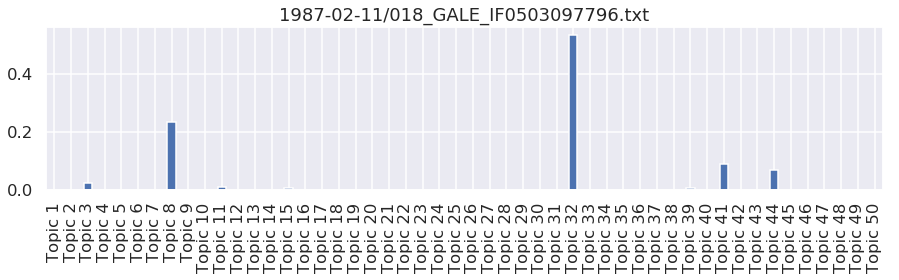

1987-02-11/018_GALE_IF0503097796.txt
Topic 32: 0.536872

Two sides of a glinting public borrowing coin
Two sides of a glinting public borrowing coin
P rices in the gilt-edged market, let alone equities, are now predicated on City hopes that there will be an election in May which the Tories will win. Dealers and analysts are therefore, for the moment , prepared to suspend unease over economic indicators, including monetary targets, the balance of trade and the headlong rise of consumer credit. In such a paradoxical atmosphere , a healthy financial in - dicator is doubly welcome. Buoyant tax revenues from spending and profits are providing just that. The apparent sharp downtrend in the likely public sector borrowing require - ment for 1986-87 , which caused City forecasters to cut their estimates after the release of the December figures, was fully confirmed in the January figures yesterday. Although the surplus was slightly lower than a year ago, this was due to changes in the pattern o

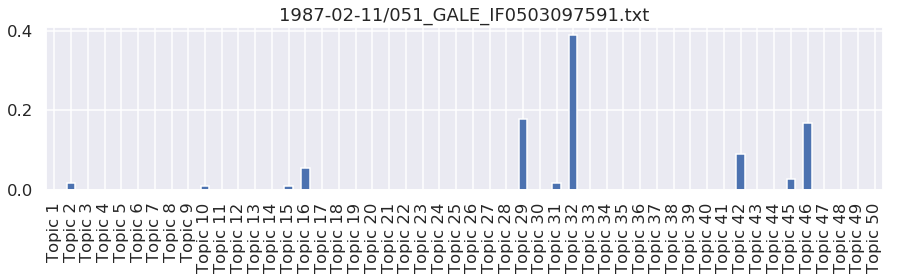

1987-02-11/051_GALE_IF0503097591.txt
Topic 32: 0.390265

14 m more mouths to feed in a year
14m more mouths to feed in a year
Despite its well-publicized birth control policy, China admitted yesterday that its total population reached 1.06 billion in 1986, a total of some 14 million more than the year before . The new figures, released by the State Statistical Bureau and reported by the New China News Agency, were the result of "relaxed control over family planning" , according to an unnamed official. As the most populous nation on earth with a fifth of the world's people, China has a policy of limiting most couples to one child. The policy is enforced strictly in the large east-coast cities, but is more lax in the countryside and among many of China's 55 identified minor - ity groups. The goal of the policy is to limit the country's total
population to 1.2 billion by the year 2000. To achieve that goal, central government planners have tried to limit the national net growth rate (birt

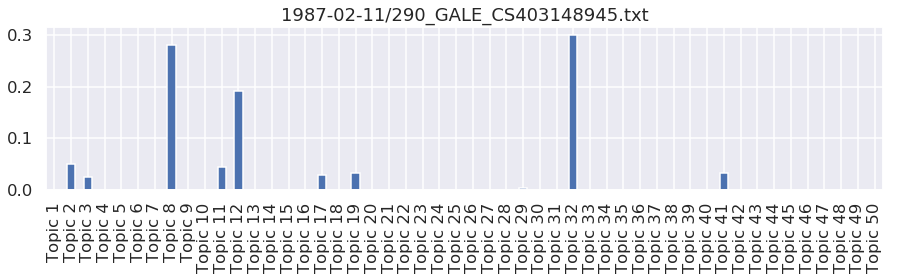

1987-02-11/290_GALE_CS403148945.txt
Topic 32: 0.300658

British public plays safe and grows steadily wealthier
British- publiclays s-afe and
grows stily wealthier
Peter Falush
on the neglected area of personal assets
The daily ripples of the Stock Exchange, foreign exchange or money markets seem to cause economic analysts to neglect one of the steady currents that run deep in our economy: the process .of wealth creation.
The Central Statistical Office and Bank of England publish data. on personal sector balance sheets, the most reliable yard- stick qf wealth creation, only once a'year. but since it comes out unannounced, on page 152 of Financial Statistics, it seldom draws comment even from our most alert market watchers.
This neglect is all the more remarkable because these fig- ures not only help to quantify the increase in our financial and physical assets but also provide valuable pointers to the future developments of the capital markets and the financial services sector.
The pers

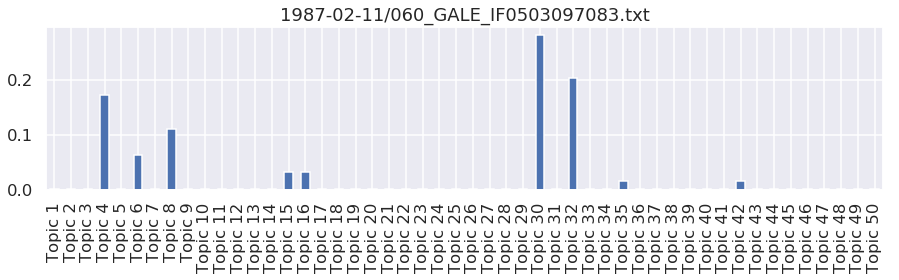

1987-02-11/060_GALE_IF0503097083.txt
Topic 32: 0.204687

Pentagon cuts security clearance of 1,600,000
Pentagon cuts security clearance of 1,600,000
The Pentagon has severely reduced the number of personnel with access to secret information after a spate of spy cases. Since the clamp - down began in June, 1985, more than 1,600,000 people have lost security clearances, a 39 per cent reduction . "Top secret" clearances have dropped by 241,000, equivalent to 40 per cent. There are now 1,255,000 fewer people with "secret" clear - ance , a reduction of 39 per cent , and those with "confidential" clearance, the lowest security rating is down by 96,500. 32 per cent.
About 2,500,000 depar t - men t of defence personnel still have security clearance , as do a further 868,000 contractors . Mr Robert Sims, the Penta - gon spokesman, said the de - fence department was also trying to reduce the number of documents that are given a security classification. "It is more difficult to protect those docu

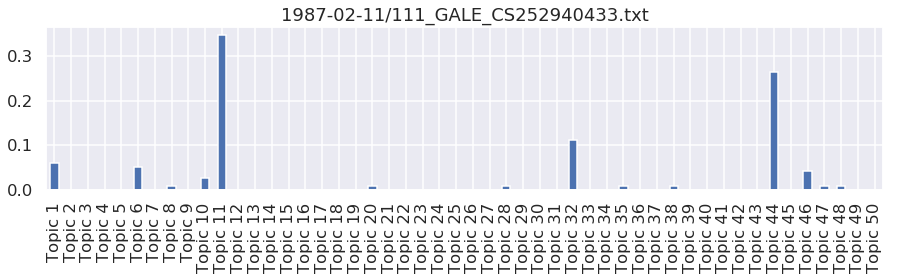

1987-02-11/111_GALE_CS252940433.txt
Topic 32: 0.111017

Mrs Thatcher abroad
Mrs Thatcher abroad
From Mr Michael Bailep
Sir. The Prime Minister's assertion in her interview with The Standara (which you quoted extensively in Thte Times, April II) that "I can't find jobs for everyone and no government can . . .- is hardly consistent with the views she expressed publicly in the mid 70s.
Even then she ignored the tradition of not criticizing the country abroad. Indeed, even though unemployment in Britain was a mere 800.000. Mrs Thatcher told the National Press Club in Washington, in 1975:
We have. to a more intense degree than many other countries. a combination of rising prices. failing output and iiewllort:zeni [my italics]. And we have a sense of losing our way. The problem is not a technical one. It is one of the life and death of the national spirit. We are in the midst of a struggle for human dignity.
Ten years later we are still in the midst of that struggle: but, with four million j

In [655]:
print_top_articles(date_str, 32, n_top_articles=5, plot=True)

**1987-02-11**

China admits that its population is over 1 billion

Greenwich by-election of February 1987.

____________

## Next:

In [489]:
relevant_weeks

['1948-37',
 '1948-42',
 '1948-44',
 '1958-29',
 '1958-33',
 '1987-06',
 '1987-07',
 '1989-16',
 '1989-30',
 '1993-12',
 '1993-28',
 '1993-47',
 '1995-29']

1989-04-17


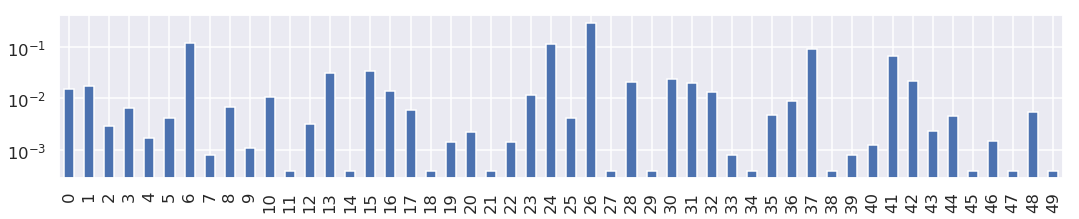

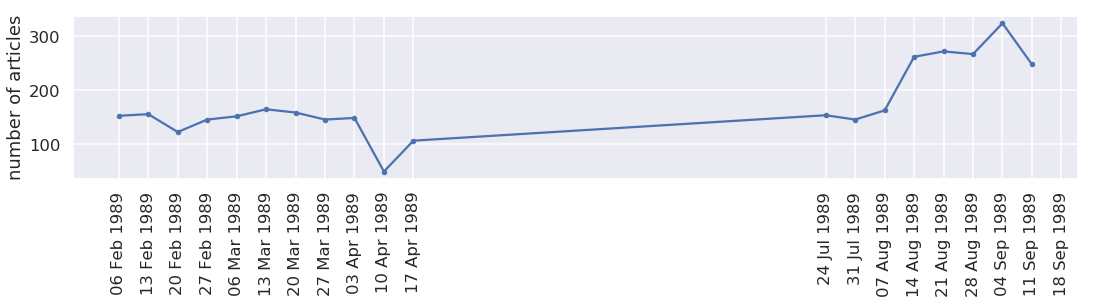

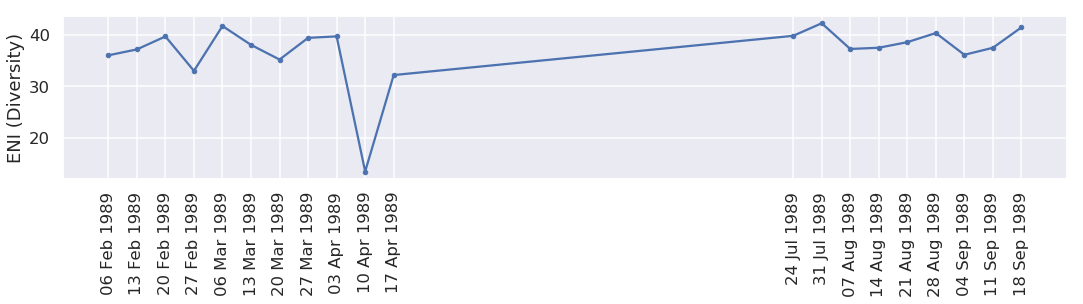

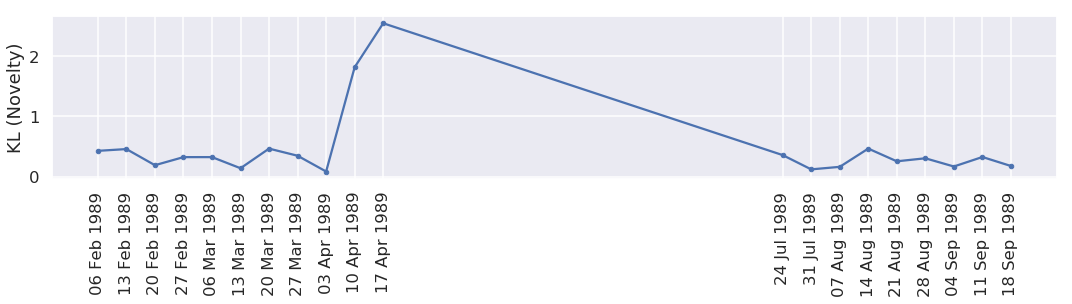

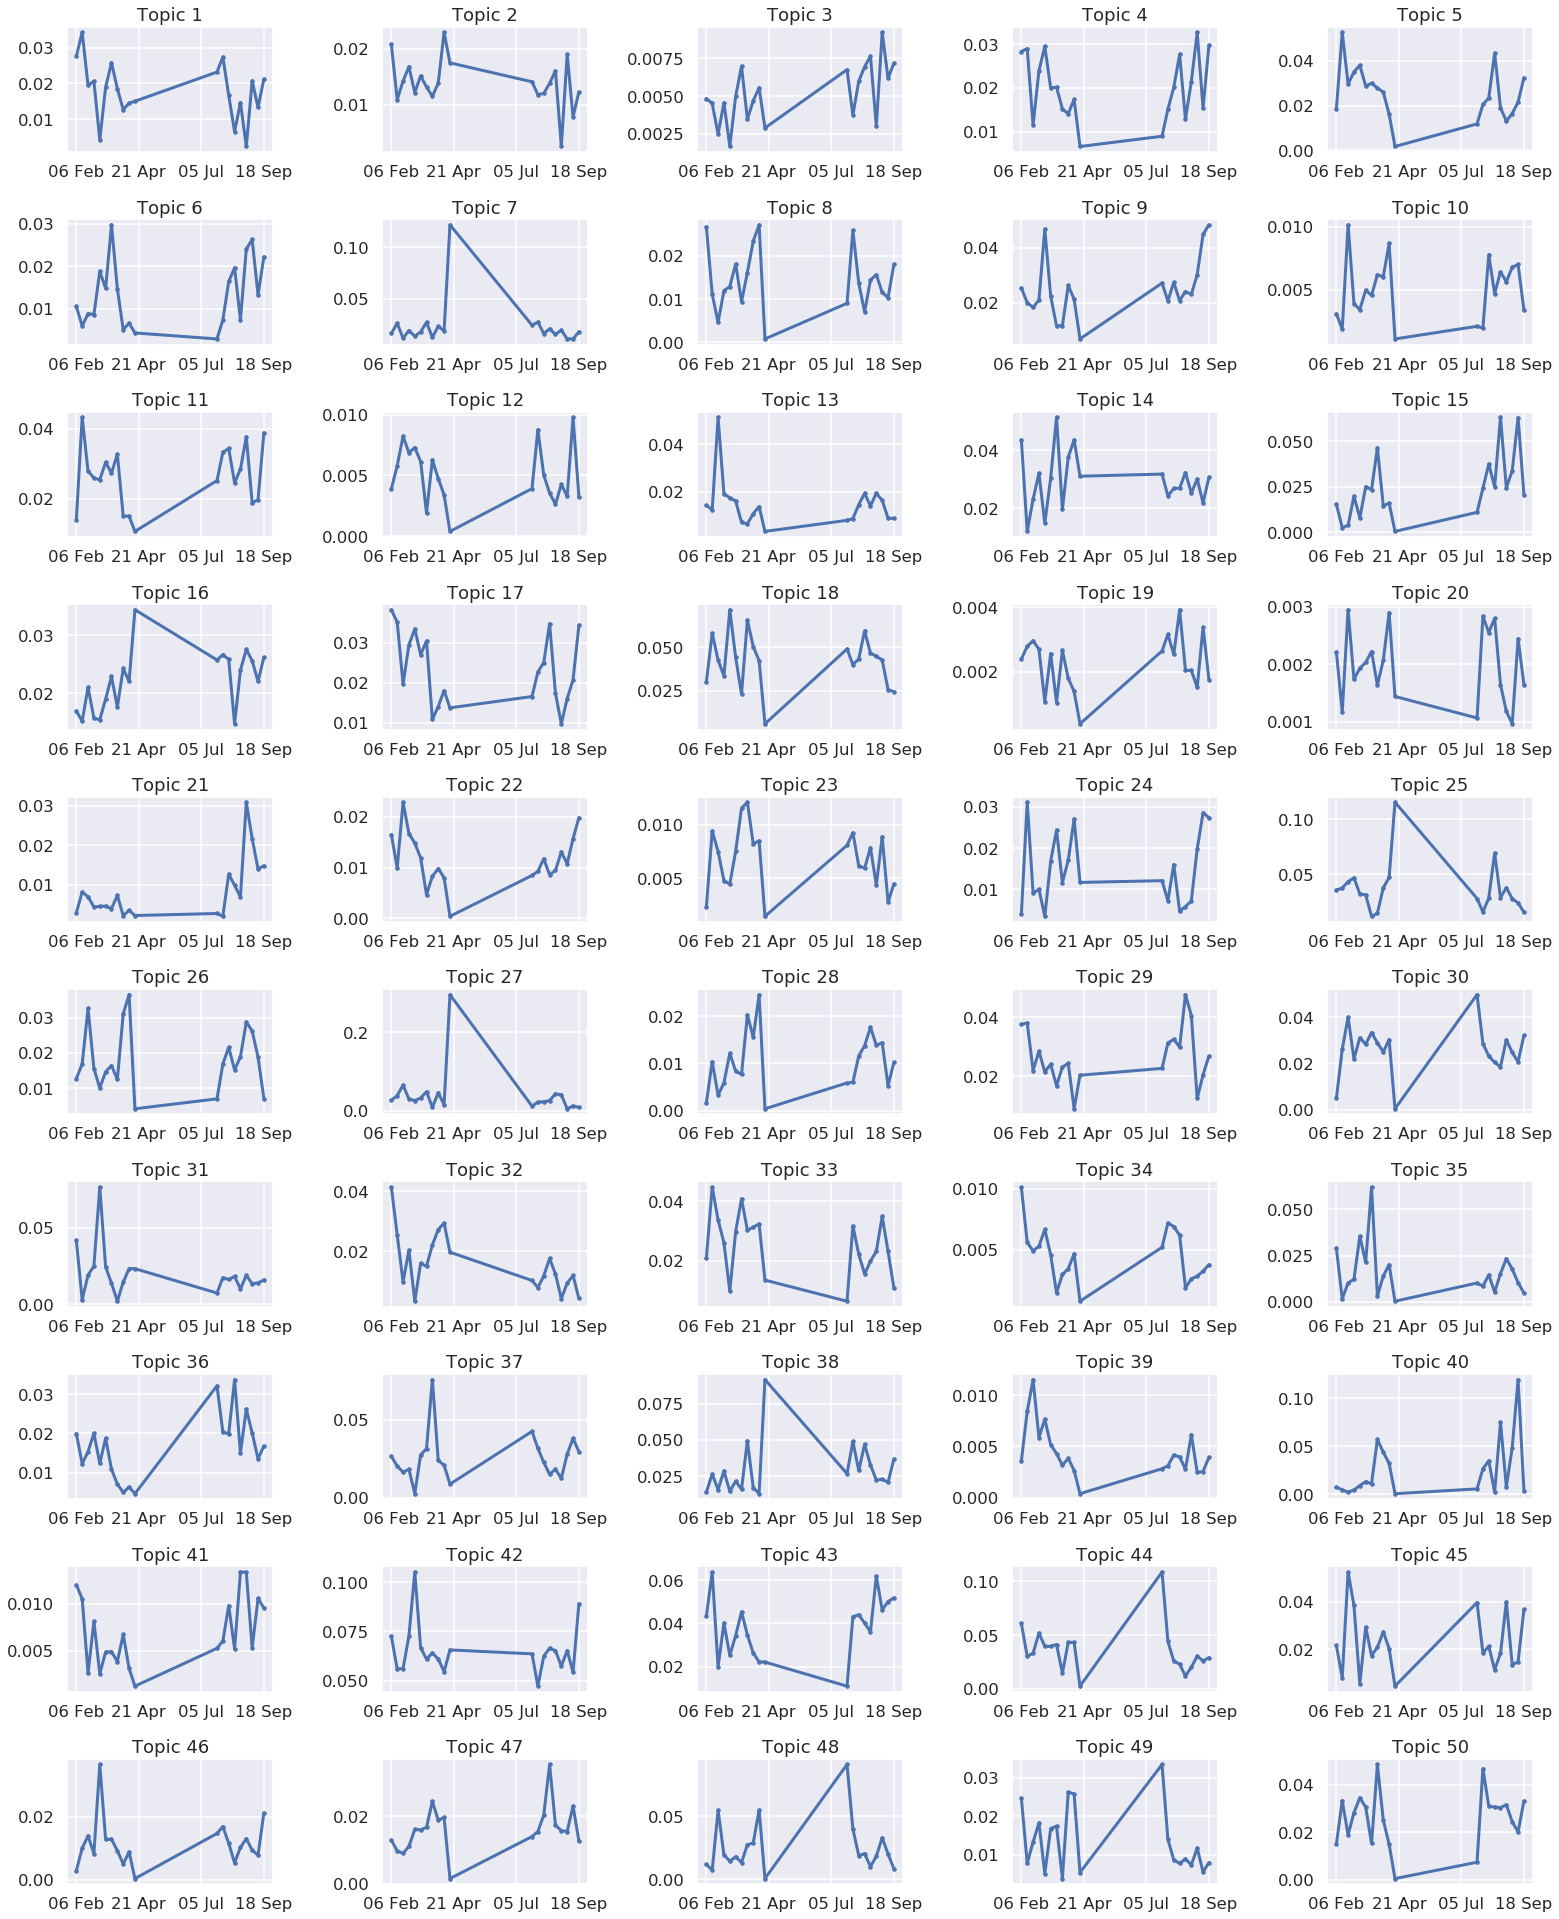

In [686]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[7]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [687]:
topics = [27,7,25]

for topic in topics:
    print(examine_topic(topic), '\n')

court       0.034152
justice     0.021582
lord        0.018704
act         0.016609
case        0.016132
appeal      0.016123
law         0.014877
section     0.011719
order       0.011126
judge       0.008823
legal       0.008313
judgment    0.007915
decision    0.006533
right       0.006305
lordship    0.006197
Name: Topic 27, dtype: float64 

local          0.028993
council        0.023913
building       0.019472
london         0.018171
city           0.015215
housing        0.014431
land           0.011580
houses         0.010295
planning       0.010266
development    0.009750
area           0.009509
town           0.009107
authorities    0.008944
people         0.008883
site           0.008139
Name: Topic 7, dtype: float64 

police       0.027762
court        0.026962
trial        0.015484
prison       0.014190
aged         0.013719
told         0.012421
yesterday    0.011118
case         0.011048
evidence     0.010293
years        0.009925
criminal     0.009688
guilty       0.009

In [688]:
print(date)

1989-16


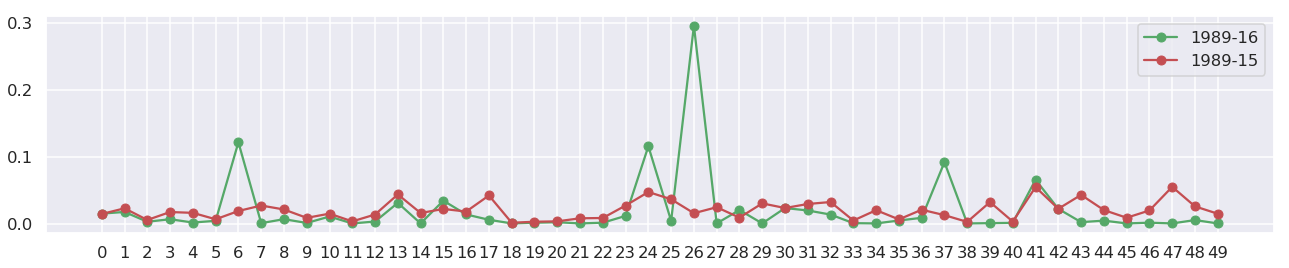

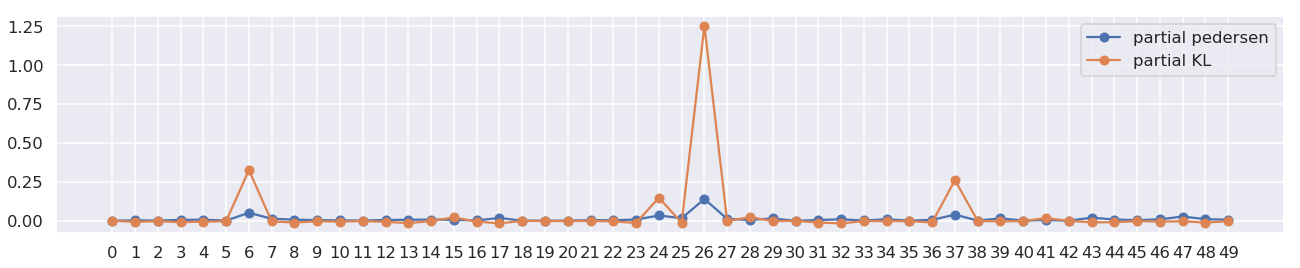

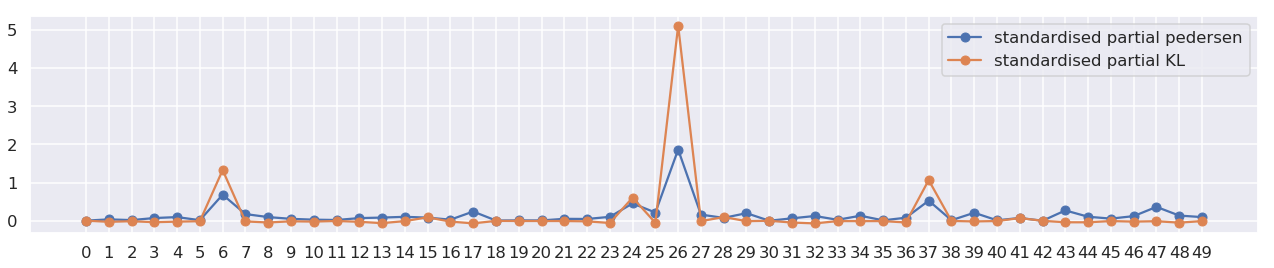

1989-15:
26    0.015614
6     0.018921
37    0.012742
Name: 1989-15, dtype: float64 

1989-16:
26    0.295569
6     0.121538
37    0.091794
Name: 1989-16, dtype: float64 

      KL(1989-15 -> 1989-16): 1.818858
pedersen(1989-15 -> 1989-16): 0.565148


In [689]:
date    = '1989-16'
date_m1 = '1989-15'

u, v = full_agenda.loc[date], full_agenda.loc[date_m1]

partial_pedersen = np.abs(u - v)/2
partial_KL       = np.array([ p*np.log(p/q) for p,q in zip(u,v) ])*entropy_correction

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(u, 'o-g', label=date)
ax.plot(v, 'o-r', label=date_m1)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(partial_pedersen, 'o-', label='partial pedersen')
ax.plot(partial_KL, 'o-', label='partial KL')
plt.legend()
plt.show()

s_partial_pedersen = (partial_pedersen-0)/pedersen_std
s_partial_KL       = (partial_KL-0)/KL_std

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(s_partial_pedersen, 'o-', label='standardised partial pedersen')
ax.plot(s_partial_KL, 'o-', label='standardised partial KL')
plt.legend()
plt.show()

print(date_m1+':')
print(v[[26, 6, 37]],'\n')

print(date+':')
print(u[[26, 6, 37]],'\n')

print('      KL({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_KL)))
print('pedersen({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_pedersen)))

In [690]:
# find closest date in articles per day

d = date

date_of_interest = datetime.strptime(d + '-1', "%Y-%W-%w").date()#.strftime("%Y-%m-%d")

corresponding_date = articles_per_day.index[0]
mindelta = np.infty
for day in articles_per_day.index:
    d = datetime.strptime(day, "%Y-%m-%d").date()
    delta = np.abs((d-date_of_interest).days)
    if delta < mindelta:
        mindelta = delta
        corresponding_date = day

date_str = corresponding_date
#date_str = corresponding_date[:-3]

idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
df_filtered  = documents_per_topic.loc[idx_filtered]

topics = ['Topic {}'.format(i) for i in [27,7,36] ]

df_filtered[topics].sort_values(topics, ascending=False).head(10)

Topic 27   Topic 7  Topic 36
1989-04-19/321_GALE_IF0500378343.txt  0.727907  0.000332  0.000332
1989-04-19/325_GALE_IF0501713768.txt  0.713934  0.000820  0.017213
1989-04-19/303_GALE_IF0502291400.txt  0.697340  0.000532  0.000532
1989-04-19/324_GALE_IF0501713767.txt  0.438173  0.000234  0.000234
1989-04-19/326_GALE_IF0500378348.txt  0.422162  0.184324  0.022162
1989-04-19/322_GALE_IF0500378344.txt  0.325131  0.000524  0.000524
1989-04-19/282_GALE_IF0501844149.txt  0.119643  0.000595  0.000595
1989-04-19/288_GALE_IF0503387462.txt  0.030000  0.015714  0.001429
1989-04-19/314_GALE_IF0502291409.txt  0.028671  0.007692  0.000699
1989-04-19/304_GALE_IF0501844173.txt  0.022917  0.002083  0.002083

1989-04-19 



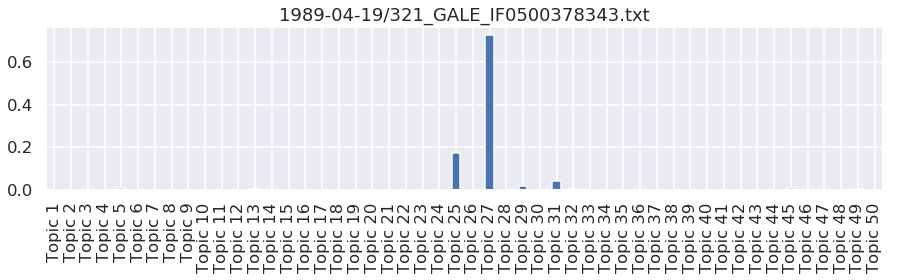

1989-04-19/321_GALE_IF0500378343.txt
Topic 27: 0.727907

Penalties should be shown on charge
Queen^s Bench Divisional Court ;-^-:- ;; IaWB^i^; Apiil4 ' 9^.?- ;• ' / Queen's Bench Divisional Court
Penalties should be shown on charge
Regina v Waltham Forest Justices, Ex parte Barton Before Lord Justice Woolf and Mr Justice Saville [Judgment April 17] Where a person had been charged with failure to provide a specimen bf breath under sec - ti on 8(7) of the Road Traffic Act 1972, as substituted in Schedule 8 to the Transport Act 1981, it was preferable for the alter - native disqualification penalties in Schedule 4 to the 1972 Act to be indicated in the summons . Lord Justice Woolf so held in the Queen's Bench Divisional Court when allowing an applica - tio n for judicial review brought by Thomas Barton and granting an order of cerliorari quashing
the 12-month disqualification and licence endorsement im - posed on him by Waltham Forest Justices on August 1, 1988. The relief sought was for 

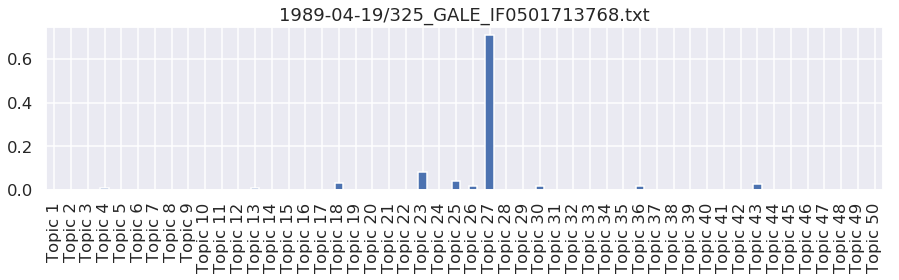

1989-04-19/325_GALE_IF0501713768.txt
Topic 27: 0.713934

Following code no defence
Following code no defence
Marsh v Chief Constable of Avon and Somerset It was a question of fact in each case whether there had been a breach of condition of a firearms certificate and even if an owner of a firearm followed the voluntary code of practice issued by the British Shooting Sports Council he could still be guilty of an offence under the Firearms Act 1968. The Queen's Bench Di - visional Court (Lord Justice May and Mr Justice Roch) so held on May 6 in dismissing an appeal by way of case stated by Christopher David Marsh from Bristol Crown Court (Judge Fanner and justices), who had dismissed his appeal
from the Avon North Justices who had convicted him of an offence under section 1 of the 1968 Act. LORD JUSTICE MAY said the relevant condition in the instant case was: "The fire - arms and ammunition to which this certificate relates must at all times when not in actual use be kept in a secure pla

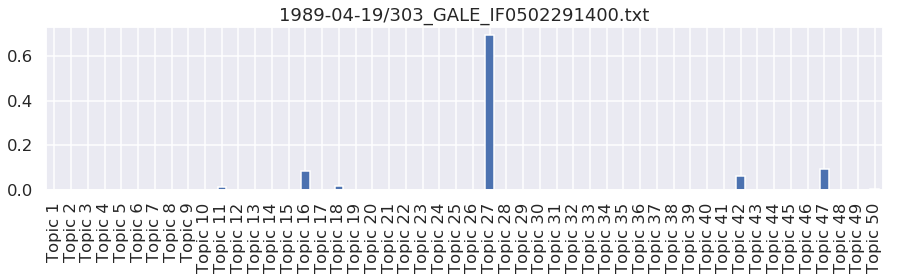

1989-04-19/303_GALE_IF0502291400.txt
Topic 27: 0.697340

Affidavits must be in words of witnesses not lawyers
Affidavits must be in words of witnesses not lawyers
Alex Lawrie Factors Ltd v Morgan and Others Before Lord Justice Brooke and Lord Justice Robert Walker [Judgment July 5] The purpose of an affidavit, or a statement of truth, was for a wi t - ness to say, in her own words, what the relevant evidence was. It was not to be used by the lawyer who settled it as a vehicle for com - plex legal argument to which the witness herself would not be readi - ly able to speak if cross-examined on it . The Court of Appeal so stated in allowing the appeal of the second defendant, Mrs Pamela Morgan, against the decision of Mr Justice Douglas Brown in the Queen's Bench Division on June 9,1998 to uphold the summary judgment granted by Master Hodgson to the plaintiff, Alex Lawrie Factors Ltd, on May 7,1998 in an action seeking payment under a deed of indemni - ty . Mr Miles Croally for Mrs Mor - 

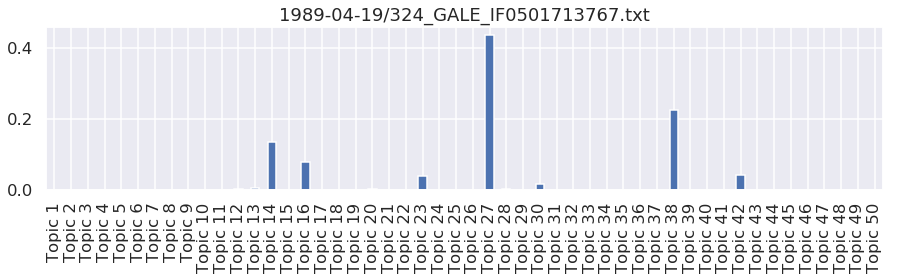

1989-04-19/324_GALE_IF0501713767.txt
Topic 27: 0.438173

Council has discretion to state special educational needs
Law Report May 13 1987
Council has discretion to state special educational needs
Regina v Hereford and Worcester County Council and Another, Ex parte Lashford Before Lord Justice Dillon, Lord Justice Stephen Brown and Lord Justice Nicholls [Judgment May 12] A local education authority was not obliged to make and maintain a statement under section 7 of the Education Act 1981 in respect of every child with special educational needs for whom it was responsible, but had a discretion whether or not to do so. The Cour t of Appeal so stated dismissing an appeal by
Shelley Jo Lashford, (by her mother and next friend Bar - bara Jane Lashford) from a decision of the Queen's Bench Divisional Court (The Times, November 10, 1986) dismiss - ing her application for judicial review. The matter concerned the decision of the Hereford and Worcester County Council not to make a statement unde

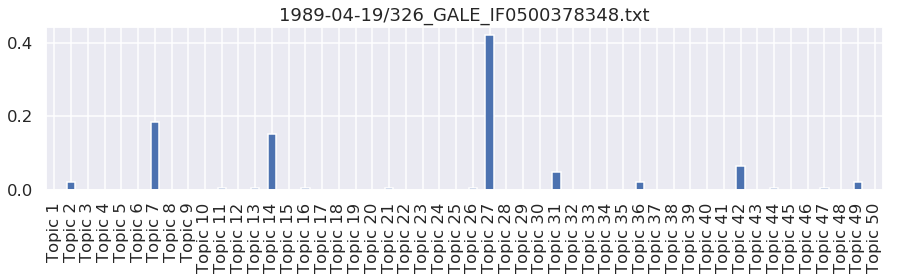

1989-04-19/326_GALE_IF0500378348.txt
Topic 27: 0.422162

Taxis for wheelchair passengers
Taxis for wheelchair passengers
Regina v Manchester City Council, Ex parte McHugh and Another Before Mr Justice Simon Brown [Judgment April 17] A licensing authority was en - titled to make it a condition of the issue of new licences for taxis that they must be adapted to provide a facility for the proper transportation of wheel - chai r bound passengers and in so doing to make it a condition for new applicants without requiring the provision of such a facility by existing licence holders. Mr Justice Simon Brown so held in the Queen 's Bench Division when dismissing the applications of Mr Anthony McHugh and Mr Leslie Reid for an order of ceniorari quashing a decision of Manchester City Council requiring that the ve - hicles of all applicants for new hackney carriage licences be specially adapted to carry wheel - chair bound disbled passengers, oh the ground that it was ultra vires the council's pow

In [691]:
print_top_articles(date_str, 27, n_top_articles=5, plot=True)

Apr 1989

15 April – 94 people are killed in the Hillsborough disaster during the FA Cup semi-final at the Hillsborough Stadium in Sheffield during the FA Cup semi-final between Nottingham Forest FC and Liverpool F.C. Around 300 others have been hospitalized. Several of those injured are in a serious condition and there are fears that the death toll (already the worst of any sporting disaster in Britain) could rise even higher.

Denis Howell, a former Labour sports minister, urges for the FA Cup final to go ahead this season despite consideration by the Football Association for it to be cancelled due to the Hillsborough disaster.

Home Secretary Douglas Hurd announces plans to make all-seater stadiums compulsory for all Football League First Division clubs to reduce the risk of a repeat of the Hillsborough tragedy.

The Hillsborough disaster claims its 95th victim when 14-year-old Lee Nicol dies in hospital as a result of his injuries. He had been visited in hospital by Diana, Princess of Wales, hours before he died.

____________

## Next:

In [489]:
relevant_weeks

['1948-37',
 '1948-42',
 '1948-44',
 '1958-29',
 '1958-33',
 '1987-06',
 '1987-07',
 '1989-16',
 '1989-30',
 '1993-12',
 '1993-28',
 '1993-47',
 '1995-29']

1993-03-22


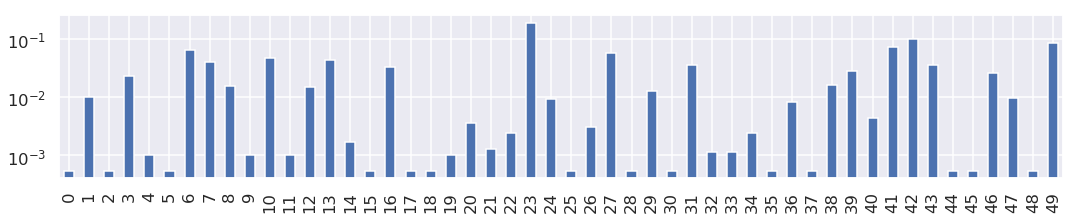

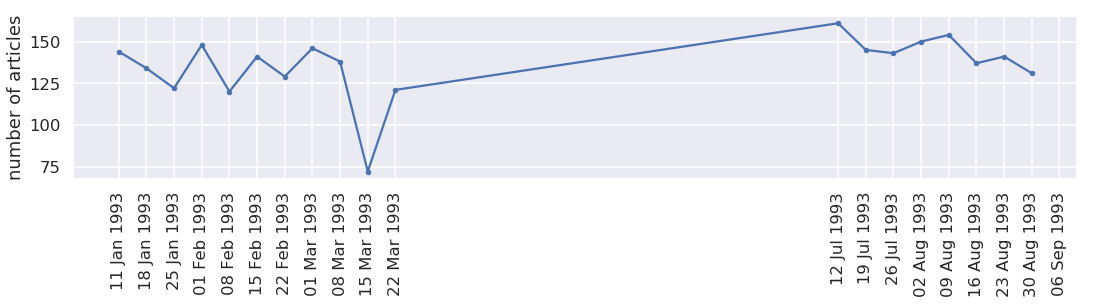

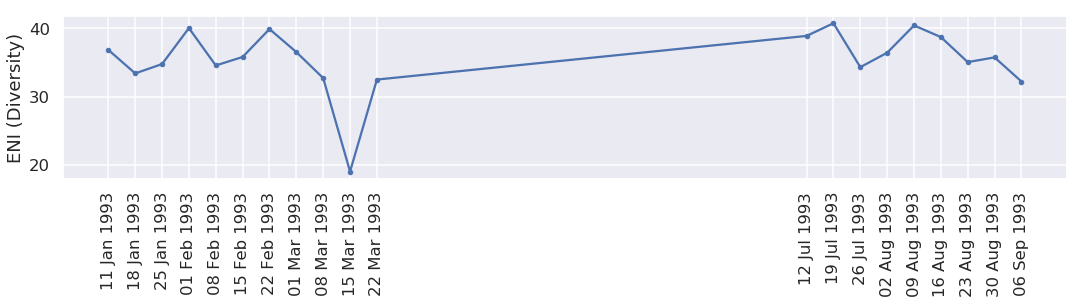

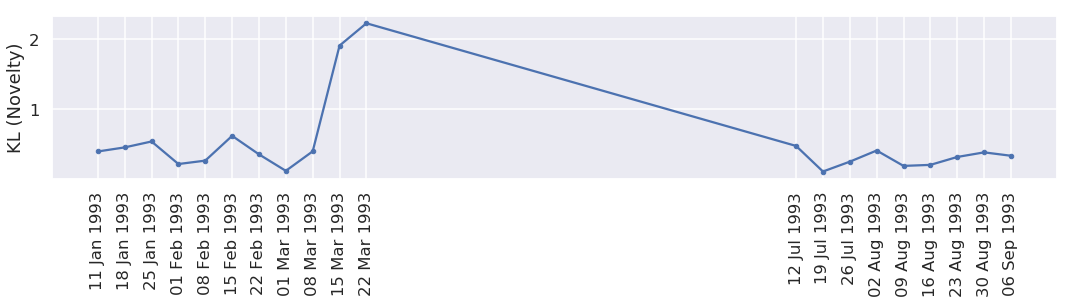

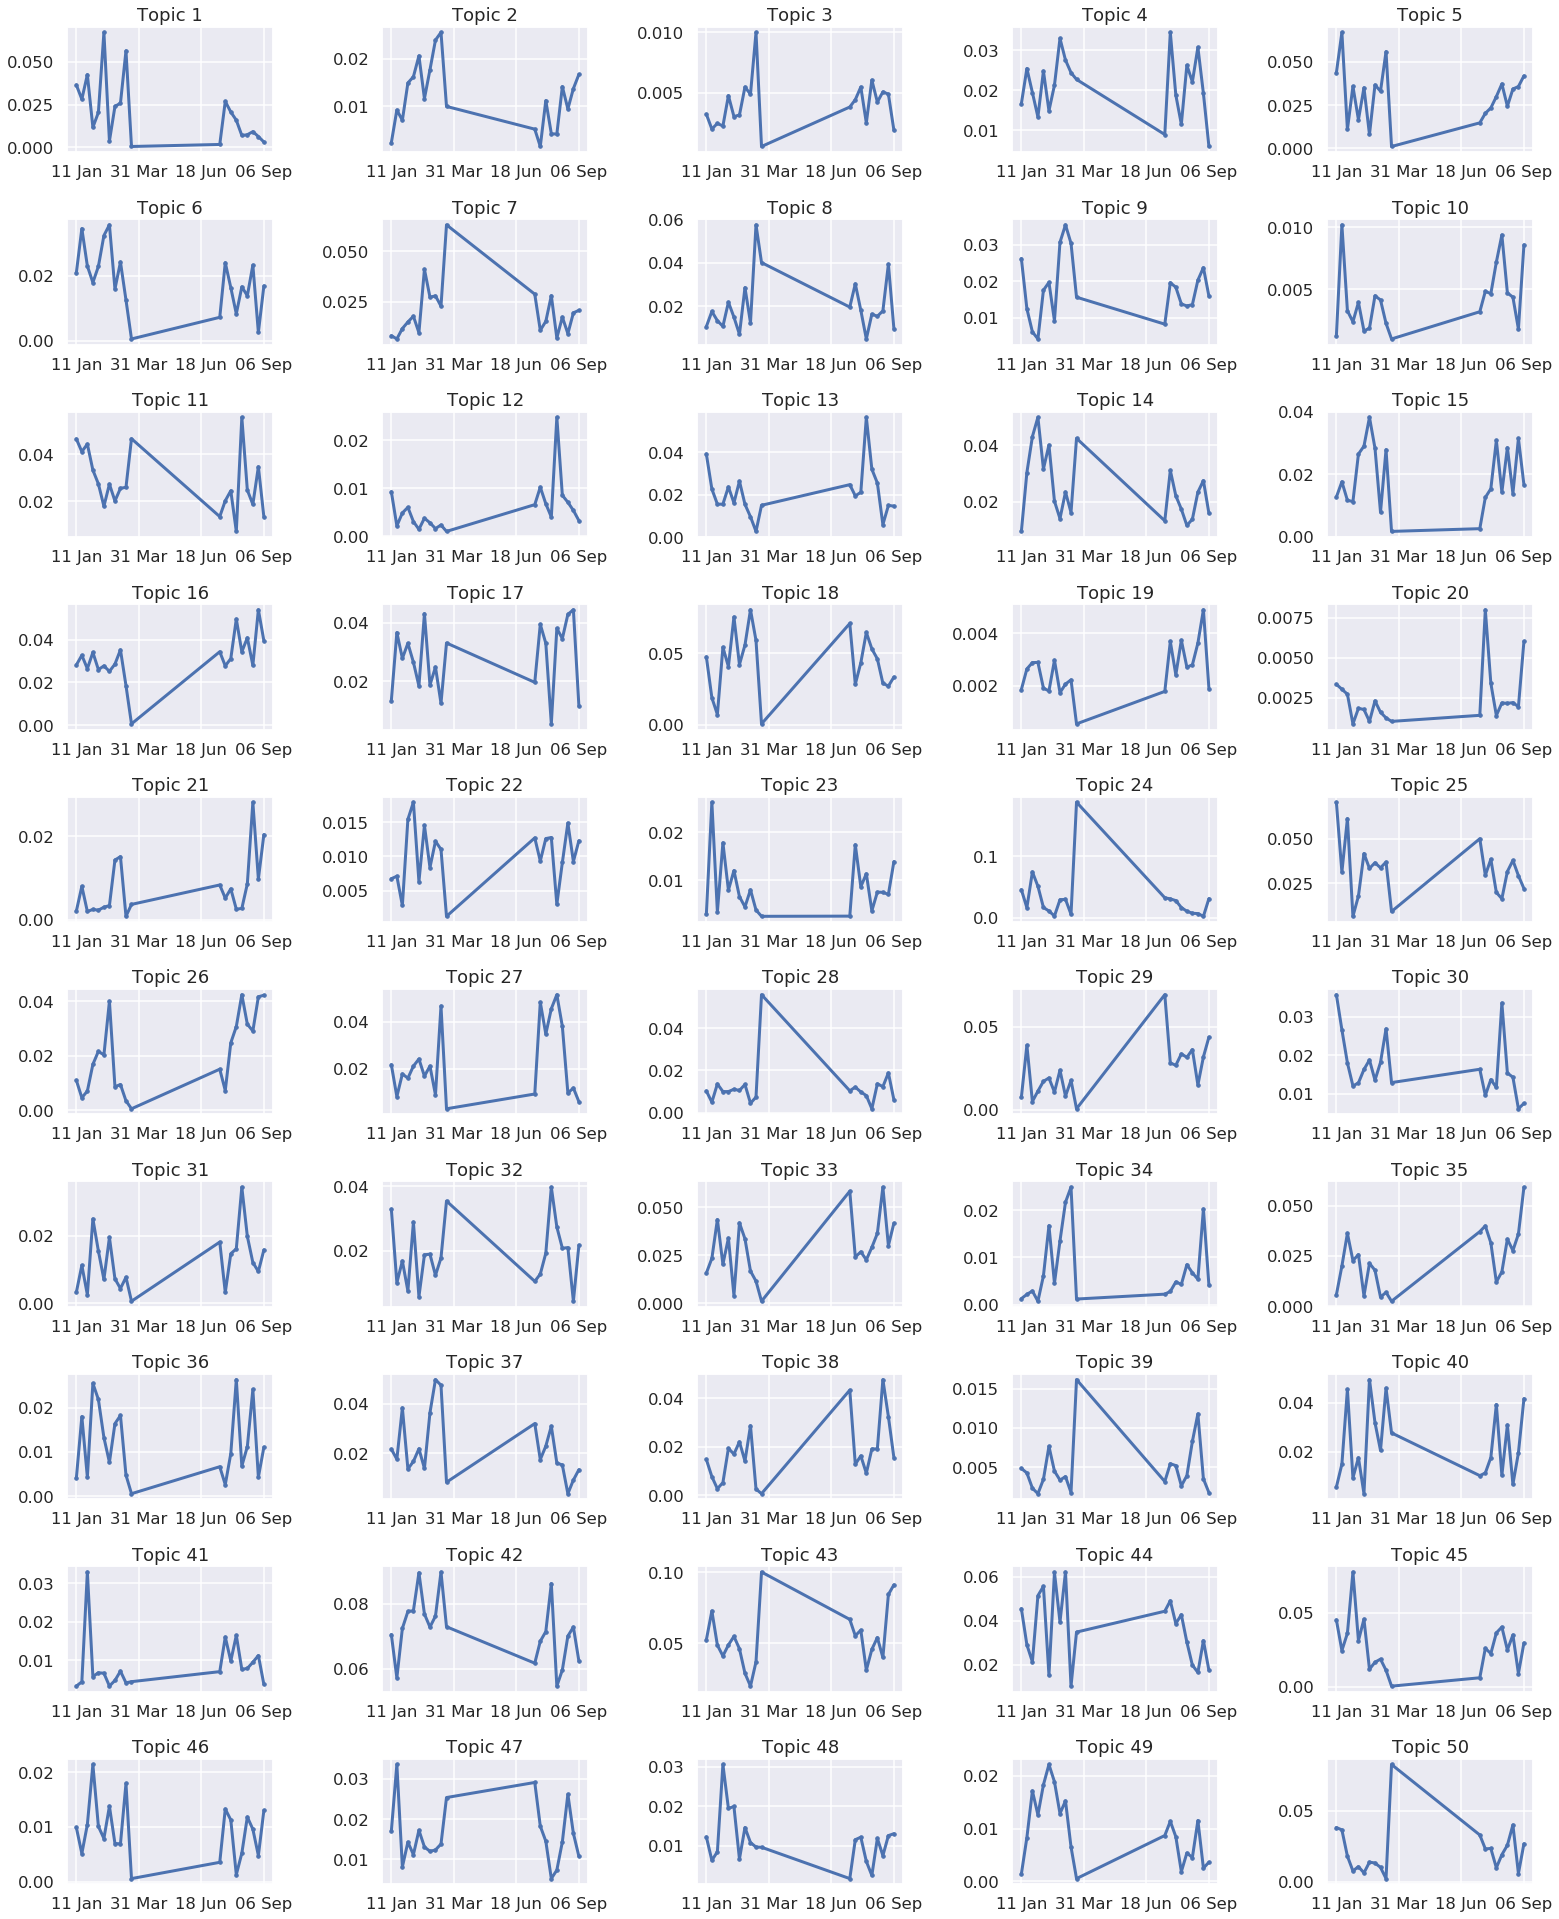

In [692]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[9]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [701]:
topics = [24,50,43]

for topic in topics:
    print(examine_topic(topic), '\n')

royal        0.042990
queen        0.038869
palace       0.018227
duke         0.017782
princess     0.017270
prince       0.016895
london       0.013727
received     0.011715
lord         0.011445
edinburgh    0.011156
king         0.010986
house        0.010713
lady         0.010702
majesty      0.009905
sir          0.009023
Name: Topic 24, dtype: float64 

television     0.036384
news           0.023357
bbc            0.022161
radio          0.020623
advertising    0.015373
times          0.014239
press          0.014064
media          0.012080
newspaper      0.011919
film           0.011633
newspapers     0.011401
programme      0.010875
daily          0.010184
paper          0.009124
editor         0.008657
Name: Topic 50, dtype: float64 

like      0.014268
people    0.012495
says      0.011017
time      0.010958
know      0.008285
think     0.007927
man       0.006897
way       0.006826
years     0.006715
day       0.006283
life      0.006148
going     0.006105
good      0.0058

In [695]:
print(date)

1993-12


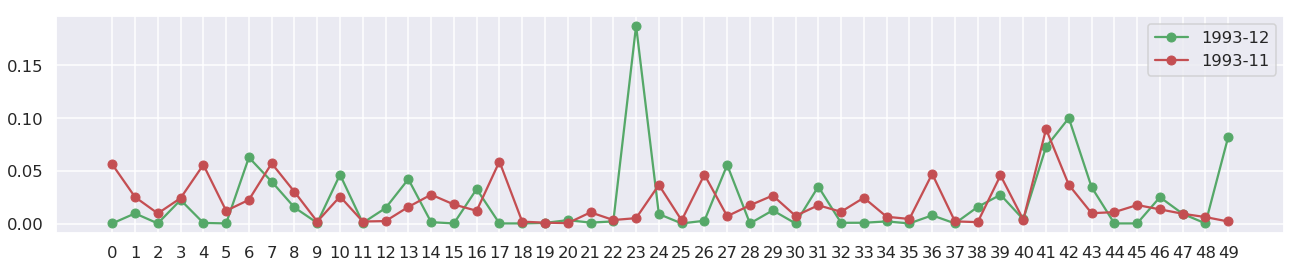

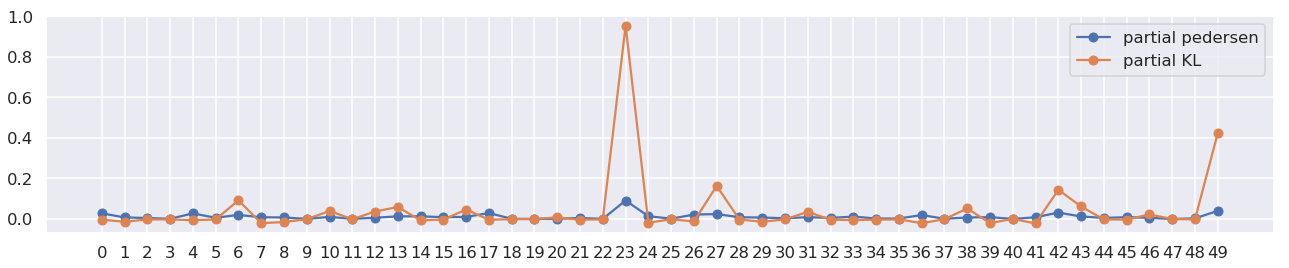

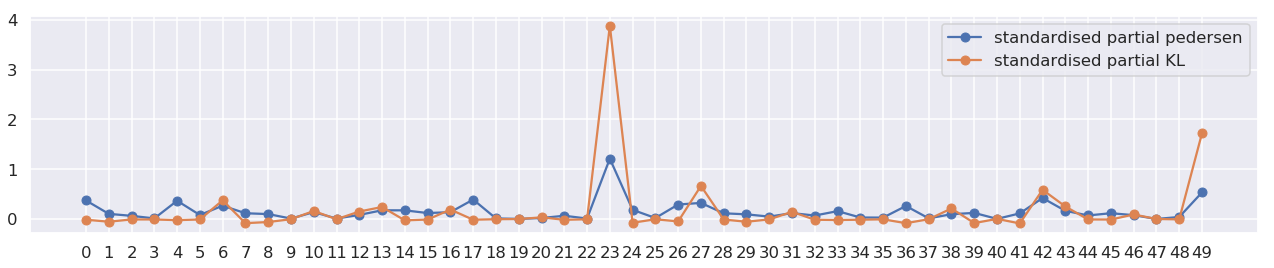

1993-11:
23    0.005526
49    0.002361
Name: 1993-11, dtype: float64 

1993-12:
23    0.187502
49    0.082509
Name: 1993-12, dtype: float64 

      KL(1993-11 -> 1993-12): 1.912115
pedersen(1993-11 -> 1993-12): 0.565074


In [704]:
date    = '1993-12'
date_m1 = '1993-11'

u, v = full_agenda.loc[date], full_agenda.loc[date_m1]

partial_pedersen = np.abs(u - v)/2
partial_KL       = np.array([ p*np.log(p/q) for p,q in zip(u,v) ])*entropy_correction

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(u, 'o-g', label=date)
ax.plot(v, 'o-r', label=date_m1)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(partial_pedersen, 'o-', label='partial pedersen')
ax.plot(partial_KL, 'o-', label='partial KL')
plt.legend()
plt.show()

s_partial_pedersen = (partial_pedersen-0)/pedersen_std
s_partial_KL       = (partial_KL-0)/KL_std

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(s_partial_pedersen, 'o-', label='standardised partial pedersen')
ax.plot(s_partial_KL, 'o-', label='standardised partial KL')
plt.legend()
plt.show()

topics = [24,50]

print(date_m1+':')
print(v[[i-1 for i in topics]],'\n')

print(date+':')
print(u[[i-1 for i in topics]],'\n')

print('      KL({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_KL)))
print('pedersen({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_pedersen)))

In [709]:
# find closest date in articles per day

d = date

date_of_interest = datetime.strptime(d + '-1', "%Y-%W-%w").date()#.strftime("%Y-%m-%d")

corresponding_date = articles_per_day.index[0]
mindelta = np.infty
for day in articles_per_day.index:
    d = datetime.strptime(day, "%Y-%m-%d").date()
    delta = np.abs((d-date_of_interest).days)
    if delta < mindelta:
        mindelta = delta
        corresponding_date = day

date_str = corresponding_date
#date_str = corresponding_date[:-3]

idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
df_filtered  = documents_per_topic.loc[idx_filtered]

topics = [24,50]
topics = ['Topic {}'.format(i) for i in topics ]

df_filtered[topics].sort_values(topics, ascending=False).head()

Topic 24  Topic 50
1993-03-24/136_GALE_IF0500609462.txt  0.935093  0.000311
1993-03-24/290_GALE_IF0501844276.txt  0.814964  0.000238
1993-03-24/333_GALE_IF0501844282.txt  0.748101  0.001266
1993-03-24/305_GALE_IF0501844278.txt  0.181000  0.001000
1993-03-24/207_GALE_IF0500378363.txt  0.070297  0.000990

1993-03-24 



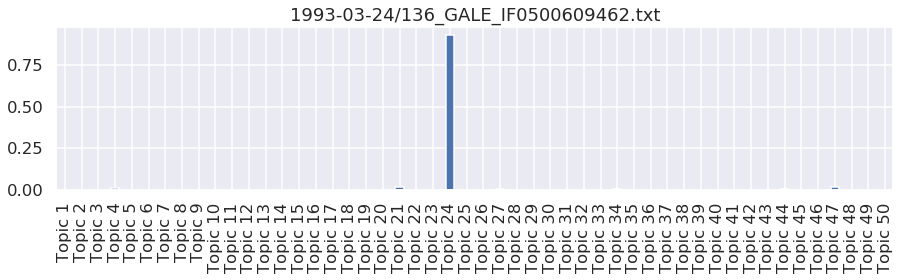

1993-03-24/136_GALE_IF0500609462.txt
Topic 24: 0.935093

Court Circular
COURT CIRCULAR
BUCKINGHAM PALACE March 23: His Excellency Mr John Philip Mascarenhas was received in audience by The Queen and presented the Letters of Recall of his predecessor and his own Letters of Commission as High Commissioner for the Republic of Seychelles in London. Mrs Mascarenhas was also re - ceived by Her Majesty. The Deputy Permanent Under - secretary of State for Foreign and Commonwealth Affairs (Sir John Coles) was present and the House - hold iri Waiting were in attendance . His Excellency Mr Ghazi Al - Rayes and Mrs Al-Rayes were received in farewell audience by The Queen and took leave upon His Excellency relinquishing his appointment as Ambassador Extraordinary and Plenipotentiary of the State of Kuwait to the Court of St James's and upon retiring as Doyen of the Diplomatic Corps. Her Majesty invested His Ex - cellency with the Insignia of an Honorary Knight Grand Cross of the Royal Victorian Ord

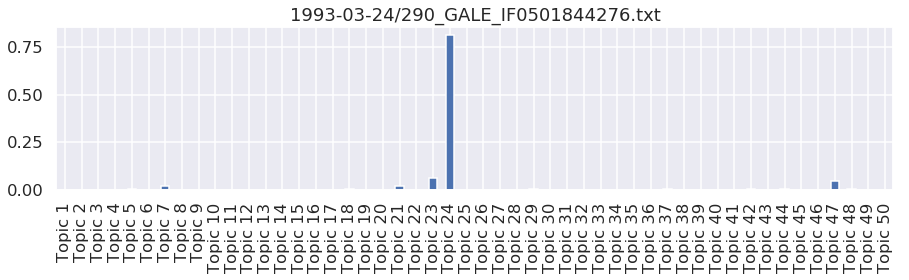

1993-03-24/290_GALE_IF0501844276.txt
Topic 24: 0.814964

Court Circular
COURT CIRCULAR
BUCKINGHAM PALACE March 12: The Queen held an Investiture at Buckingham Palace this morning. The Right Hop John Major, MP (Prime Minister and First Lord of the Treasury) had an audience of Her Majesty this evening. The Duchess of York today visited Wiltshire to meet families of servicemen presently involved in the Gulf. Her Royal Highness visited Larkhill Garrison and RAF Upayon . Miss Lucy Manners and Captain Alexander Baillie - Hamil ton were in attendance. The Prince Edward this evening attended a gala performance of "The Cora is Green" at the Greenwich Theatre, Crooms Hill, London, SE10 . Mrs Richard Warburton was in attendance. The Princess Royal this morning visited Newcastle upon
Tyne and was received by Her Majesty's Lord-lieutenant for Tyne and Wear (Sir Ralph Carr - EUison ). Her Royal Highness, Patron, National Association of Victims Support Schemes, visited the Crown Court Victim/Witness 

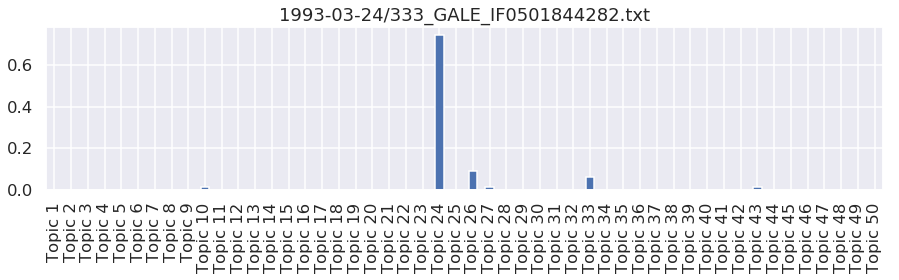

1993-03-24/333_GALE_IF0501844282.txt
Topic 24: 0.748101

Today's royal engagements
Today's royal engagements
The Prince of Wales, as Patron of the National Training Awards 1991, will attend the launch of this year's awards, at the Brewery, Chiswell Street, The Princess of Wales, as Patron of the British Lung Foundation, will visit British Telecom's London headquarters, Newgate Street, at 10.30. The Princess Royal , as President of the British Olympic Assocation, will attend the National Olympic Committee meeting at 1 Wandsworth Plain, SW18, at 11.00; as Patron of the Jersey Wildlife Preservation Trust, will attend the launch of "Save Animals from Extinc - t ion " at the Natural History Mnseum at 2.30; and, as Presi - dent of the Royal Yachting Association , will attend a recep - tion for commodores of RYA clubs and the annual meeting at the Inn on the Park Hotel at 3.45. The Duchess of Kent will attend a concert given by the choir of King's College, Cambridge, at the RN College, Greenw

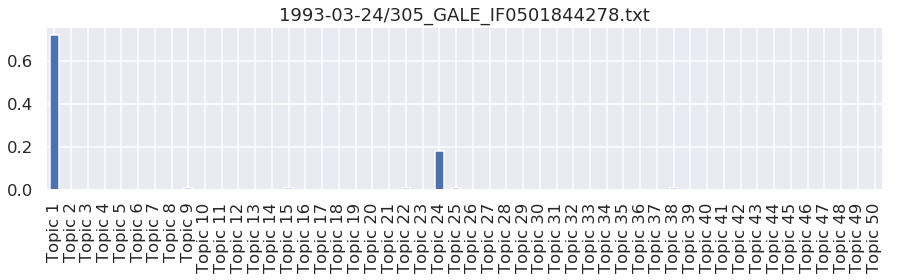

1993-03-24/305_GALE_IF0501844278.txt
Topic 24: 0.181000

Dinners
Dinners
Carmen's Company The Princess Royal attended the annual livery dinner of the Carmen's Company held last night at the Mansion House. The Lord Mayor and Lady Mayoress, accompanied by the Sheriffs and their ladies, were present Sir Robert Reid, Master, presided, assisted by Mr E.R. Britt and Mr K.E. Parry, Wardens. The Lord Mayor, Mr G. A. Long and Mr Roger Free - man , Minister of State for Transport also spoke. Pipeline Industries Guild Lord Crickhowell, Chairman of the National Rivers Authority, and Mr Peter Joslin, Chief Constable of Warwickshire, wer e the guests of honour at the annual dinner of the Pipeline Industries Guild held last night at Grosvenor House. Mr R. Evans, president, presided and Mr R.C. Smith, chairman, also spoke . Foundation for Science and Technology and Smallpeice Trust Lord Butterworth, Chairman of the Foundation for Science and Technology, presided at a joint lecture and dinner discussio

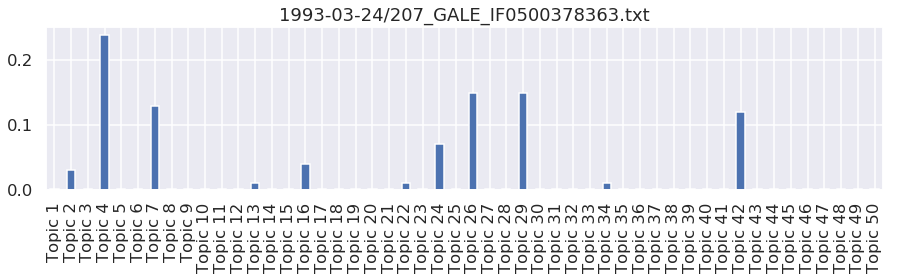

1993-03-24/207_GALE_IF0500378363.txt
Topic 24: 0.070297

Military links with the civilians
Military links %ith the civilians
f '* he third largest garrison 1 town in Britain, C ol - JL Chester , with its Roman past, is also the oldest. The geography of the to'wri, - . allow - in g easy access to the seaports of Britain and Europe, made it a valuable military base, not only for the Romans, but also for the Danes and the Round - heads . Today it is the head - quarters of the Army's Eas t - ern District - whose respon - sibili ty covers 11 counties from the River Thames to the River Humber — and it is home to the :19tb Infantry Brigade . The distant sound of bag -
p i p es and the imposing Vi c - torian . build - ings which make up much of the garrison are a constant reminder to Colchester that 5. 0CM) of its population are in - uni - fonn fTM ;ahd many more lo -
cal people are employed by the military. The relationship between soldier and civilian extends well beyond employment, how -
ev

In [711]:
print_top_articles(date_str, 24, n_top_articles=5, plot=True)

____________

## Next:

In [489]:
relevant_weeks

['1948-37',
 '1948-42',
 '1948-44',
 '1958-29',
 '1958-33',
 '1987-06',
 '1987-07',
 '1989-16',
 '1989-30',
 '1993-12',
 '1993-28',
 '1993-47',
 '1995-29']

In [ ]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[7]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [ ]:
topics = [29,32]

for topic in topics:
    print(examine_topic(topic), '\n')

In [ ]:
print(date)

In [ ]:
date    = '1987-06'
date_m1 = '1987-05'

u, v = full_agenda.loc[date], full_agenda.loc[date_m1]

partial_pedersen = np.abs(u - v)/2
partial_KL       = np.array([ p*np.log(p/q) for p,q in zip(u,v) ])*entropy_correction

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(u, 'o-g', label=date)
ax.plot(v, 'o-r', label=date_m1)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(partial_pedersen, 'o-', label='partial pedersen')
ax.plot(partial_KL, 'o-', label='partial KL')
plt.legend()
plt.show()

s_partial_pedersen = (partial_pedersen-0)/pedersen_std
s_partial_KL       = (partial_KL-0)/KL_std

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(s_partial_pedersen, 'o-', label='standardised partial pedersen')
ax.plot(s_partial_KL, 'o-', label='standardised partial KL')
plt.legend()
plt.show()

print(date_m1+':')
print(v[[28, 31]],'\n')

print(date+':')
print(u[[28, 31]],'\n')

print('      KL({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_KL)))
print('pedersen({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_pedersen)))

In [ ]:
# find closest date in articles per day

d = date

date_of_interest = datetime.strptime(d + '-1', "%Y-%W-%w").date()#.strftime("%Y-%m-%d")

corresponding_date = articles_per_day.index[0]
mindelta = np.infty
for day in articles_per_day.index:
    d = datetime.strptime(day, "%Y-%m-%d").date()
    delta = np.abs((d-date_of_interest).days)
    if delta < mindelta:
        mindelta = delta
        corresponding_date = day

date_str = corresponding_date
#date_str = corresponding_date[:-3]

idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
df_filtered  = documents_per_topic.loc[idx_filtered]

topics = [28,31]
topics = ['Topic {}'.format(i) for i in topics ]

df_filtered[topics].sort_values(topics, ascending=False).head()

In [ ]:
print_top_articles(date_str, 32, n_top_articles=5, plot=True)

____________

## Next:

In [489]:
relevant_weeks

['1948-37',
 '1948-42',
 '1948-44',
 '1958-29',
 '1958-33',
 '1987-06',
 '1987-07',
 '1989-16',
 '1989-30',
 '1993-12',
 '1993-28',
 '1993-47',
 '1995-29']

In [ ]:
full_agenda = agendas_data['Times-week']
date = relevant_weeks[7]

print(datetime.strptime(date + '-1', "%Y-%W-%w").date())

show_agenda_window(full_agenda, date, window=10)

In [ ]:
topics = [29,32]

for topic in topics:
    print(examine_topic(topic), '\n')

In [ ]:
print(date)

In [ ]:
date    = '1987-06'
date_m1 = '1987-05'

u, v = full_agenda.loc[date], full_agenda.loc[date_m1]

partial_pedersen = np.abs(u - v)/2
partial_KL       = np.array([ p*np.log(p/q) for p,q in zip(u,v) ])*entropy_correction

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(u, 'o-g', label=date)
ax.plot(v, 'o-r', label=date_m1)
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(partial_pedersen, 'o-', label='partial pedersen')
ax.plot(partial_KL, 'o-', label='partial KL')
plt.legend()
plt.show()

s_partial_pedersen = (partial_pedersen-0)/pedersen_std
s_partial_KL       = (partial_KL-0)/KL_std

fig, ax = plt.subplots(figsize=(22,4))
ax.plot(s_partial_pedersen, 'o-', label='standardised partial pedersen')
ax.plot(s_partial_KL, 'o-', label='standardised partial KL')
plt.legend()
plt.show()

print(date_m1+':')
print(v[[28, 31]],'\n')

print(date+':')
print(u[[28, 31]],'\n')

print('      KL({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_KL)))
print('pedersen({} -> {}): {:.6f}'.format(date_m1, date, sum(partial_pedersen)))

In [ ]:
# find closest date in articles per day

d = date

date_of_interest = datetime.strptime(d + '-1', "%Y-%W-%w").date()#.strftime("%Y-%m-%d")

corresponding_date = articles_per_day.index[0]
mindelta = np.infty
for day in articles_per_day.index:
    d = datetime.strptime(day, "%Y-%m-%d").date()
    delta = np.abs((d-date_of_interest).days)
    if delta < mindelta:
        mindelta = delta
        corresponding_date = day

date_str = corresponding_date
#date_str = corresponding_date[:-3]

idx_filtered = documents_per_topic.index[ np.array([ date_str in i for i in documents_per_topic.index ]) ]
df_filtered  = documents_per_topic.loc[idx_filtered]

topics = [28,31]
topics = ['Topic {}'.format(i) for i in topics ]

df_filtered[topics].sort_values(topics, ascending=False).head()

In [ ]:
print_top_articles(date_str, 32, n_top_articles=5, plot=True)

_______________

# Make figures

In [17]:
dates = agendas_data['Times-week'].index
x     = [ datetime.strptime(d + '-1', "%Y-%W-%w").date() for d in dates[1:] ]
y1     = dfs_measures['Times-week']['pedersen'].values
y2     = dfs_measures['Times-week']['KL'].values

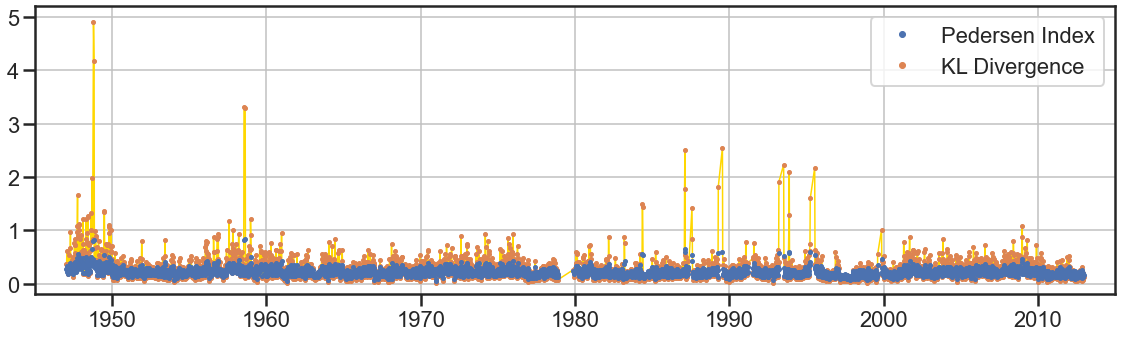

In [18]:
sns.set('poster')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(15,4))

s_y1 = (y1-y1.mean())/y1.std()
s_y2 = (y2-y2.mean())/y2.std()

ms = 4

c_lines = 'silver'
c_lines = 'gold'
lw = 1.5

ax.plot(x, y2, '-', c=c_lines, lw=lw)
ax.plot(x, y1, 'o', ms=ms, label='Pedersen Index', zorder=3)
ax.plot(x, y2, 'o', ms=ms, label='KL Divergence')

xticklabels = np.arange(1950,2020,10)
xticks = [ datetime(int(year),1,1) for year in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

legend = ax.legend(frameon=True)
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(6)

ax.set_xlim(datetime(1945,1,1),datetime(2015,1,1))
ax.set_ylim(-0.2, 5.2)

ax.grid(color='silver', alpha=0.75)

plt.tight_layout()

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
#plt.savefig('images-paper/SI-Pedersen-vs-KL.png',dpi=150, bbox_inches = 'tight', pad_inches = 0)

plt.show()

# Black and white

In [ ]:
dates = agendas_data['Times-week'].index
x     = [ datetime.strptime(d + '-1', "%Y-%W-%w").date() for d in dates[1:] ]
y1     = dfs_measures['Times-week']['pedersen'].values
y2     = dfs_measures['Times-week']['KL'].values

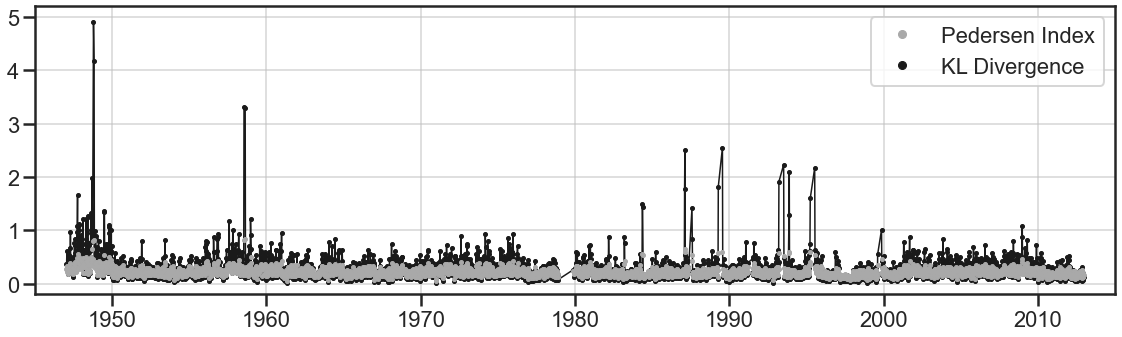

In [39]:
sns.set('poster')
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(15,4))

s_y1 = (y1-y1.mean())/y1.std()
s_y2 = (y2-y2.mean())/y2.std()

ms = 4

c_lines = 'k'
lw = 1.5

ax.plot(x, y2, '-', c=c_lines, lw=lw)
ax.plot(x, y1, 'o', ms=ms, label='Pedersen Index', zorder=3, c='darkgrey')
ax.plot(x, y2, 'o', ms=ms, label='KL Divergence', c='k')

xticklabels = np.arange(1950,2020,10)
xticks = [ datetime(int(year),1,1) for year in xticklabels]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

legend = ax.legend(frameon=True)
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(8)

ax.set_xlim(datetime(1945,1,1),datetime(2015,1,1))
ax.set_ylim(-0.2, 5.2)

ax.grid(color='silver', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
#plt.margins(0,0)
plt.savefig('images-paper/Camargo_POQ-19-0225.R1_Figure8.png',dpi=150, bbox_inches = 'tight', pad_inches = 0)

plt.show()

## Apply measures to opinion polls

In [32]:
def running_mean(x, N=5):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [33]:
month_table = pd.read_csv('MORI-MII/MORI-month_table.csv', index_col=0)

In [34]:
# make the moving average month table
N = 7

new_df_dic = {}
for key in month_table.keys()[:-3]:
    new_df_dic[key] = running_mean(month_table[key].values, N=N)

new_df_dic['month'] = month_table['month'].values[int((N-1)/2):-int((N-1)/2)]
new_df_dic['year']  = month_table['year'].values[int((N-1)/2):-int((N-1)/2)]

table_moving_average = pd.DataFrame(new_df_dic)

In [35]:
MII_names = {
            'Une' : 'Unemployment',
            'NHS' : 'National Health Service',
            'Eco' : 'Economy',
            'Cri' : 'Crime/Violence', 
            'Edu' : 'Education',
            'Rac' : 'Race Relations/Immigration',
            'Def' : 'Defence/Terrorism',
            'Com' : 'Common Market/EU/Europe',
            'Pen' : 'Pensions/Social Security',
            'Hou' : 'Housing',
            'Inf' : 'Inflation/Prices', 
            'Pol' : 'Pollution/Environment', 
            'Pov' : 'Poverty/Inequality', 
            'Nuc' : 'Nuclear War/Disarmament', 
            'LG'  : 'Local Government', 
            'Dru' : 'Drug Abuse', 
            'Tax' : 'Taxation', 
            'Mor' : 'Morality/Individual Behaviour'
            }

In [36]:
# OPTION 1: whole table
issues_table = month_table.copy()

# OPTION 2: only some issues
selected_keys = ['Une', 'NHS', 'Eco', 'Cri', 'Edu', 'Rac', 'Def', 'Com', 'Pen', 'Hou', \
       'Inf', 'Pol', 'Nuc', 'LG', 'Dru', 'Tax']
issues_table = month_table.filter(selected_keys + ['date']).copy()
issues_table['Rac'] += month_table['Imm']
issues_table['date'] = issues_table['date'].apply(lambda x: x[:7])

issues_table = issues_table.replace(-1, 0)

issues_table.index = issues_table['date']
del issues_table['date']

# normalise per rows
issues_table = issues_table.div(issues_table.sum(axis=1), axis=0).dropna()

# replace zeros by smallest value
ep = np.amin(issues_table.values[issues_table.values>0])
issues_table = issues_table.replace(0, ep)

issues_table.head()

Une       NHS       Eco       Cri       Edu       Rac       Def  \
date                                                                            
1985-01  0.479532  0.052632  0.000999  0.058480  0.046784  0.011696  0.040936   
1985-02  0.422460  0.069519  0.000999  0.042781  0.053476  0.010695  0.048128   
1985-03  0.445026  0.083770  0.000999  0.068063  0.052356  0.010471  0.026178   
1985-04  0.456989  0.096774  0.000999  0.064516  0.059140  0.021505  0.032258   
1985-05  0.456989  0.086022  0.000999  0.080645  0.064516  0.021505  0.037634   

              Com       Pen       Hou       Inf       Pol       Nuc        LG  \
date                                                                            
1985-01  0.023392  0.040936  0.017544  0.087719  0.000999  0.140351  0.000999   
1985-02  0.016043  0.042781  0.037433  0.149733  0.000999  0.106952  0.000999   
1985-03  0.010471  0.052356  0.026178  0.115183  0.000999  0.109948  0.000999   
1985-04  0.016129  0.032258  0.026882  0.091398  0.000999  0.102151  0.000999   
1985-05  0.016129  0.032258  0.021505  0.091398  0.000999  0.091398  0.000999   

              Dru       Tax  
date                         
1985-01  0.000999  0.000999  
1985-02  0.000999  0.000999  
1985-03  0.000999  0.000999  
1985-04  0.000999  0.000999  
1985-05  0.000999  0.000999

In [37]:
GLES_over_time = pd.read_csv('VFW_project/GLES_issues_over_time.csv')

del GLES_over_time['politics']
del GLES_over_time['polity']

from dateutil.parser import parse
GLES_over_time['start_of_wave'] = GLES_over_time['start_of_wave'].apply(parse)

# Remove 2009
GLES_over_time = GLES_over_time.loc[8:]

GLES_over_time.index = GLES_over_time['start_of_wave']
del GLES_over_time['start_of_wave']

# normalise per rows
GLES_over_time = GLES_over_time.div(GLES_over_time.sum(axis=1), axis=0).dropna()

# replace zeros by smallest value
ep = np.amin(GLES_over_time.values[GLES_over_time.values>0])
GLES_over_time = GLES_over_time.replace(0, ep)

GLES_over_time.head()

budget and debt  currency and euro   economy  education  \
start_of_wave                                                            
2010-04-15            0.099359           0.000801  0.139423   0.041667   
2010-06-24            0.192308           0.000801  0.136640   0.040486   
2010-09-16            0.100260           0.000801  0.088542   0.033854   
2010-12-09            0.059438           0.000801  0.115663   0.044980   
2011-03-09            0.047111           0.000801  0.093333   0.057778   

               environment  family policy  foreign policy (defense)  \
start_of_wave                                                         
2010-04-15        0.013622       0.016827                  0.075321   
2010-06-24        0.008097       0.013158                  0.013158   
2010-09-16        0.006510       0.011719                  0.005208   
2010-12-09        0.015261       0.022490                  0.028112   
2011-03-09        0.024000       0.018667                  0.022222   

               foreign policy (europe)  general fiscal policy  \
start_of_wave                                                   
2010-04-15                    0.000801               0.031250   
2010-06-24                    0.003036               0.055668   
2010-09-16                    0.000801               0.009115   
2010-12-09                    0.010442               0.030522   
2011-03-09                    0.000889               0.008000   

               general social policy  health care and pensions  \
start_of_wave                                                    
2010-04-15                  0.108974                  0.044071   
2010-06-24                  0.188259                  0.056680   
2010-09-16                  0.166667                  0.084635   
2010-12-09                  0.154217                  0.061847   
2011-03-09                  0.102222                  0.055111   

               infrastructure  labor market  law and order  \
start_of_wave                                                
2010-04-15           0.015224      0.301282       0.015224   
2010-06-24           0.003036      0.181174       0.018219   
2010-09-16           0.062500      0.216146       0.014323   
2010-12-09           0.033735      0.220884       0.043373   
2011-03-09           0.174222      0.247111       0.024000   

               migration and integration     taxes  
start_of_wave                                       
2010-04-15                      0.032853  0.064103  
2010-06-24                      0.022267  0.067814  
2010-09-16                      0.153646  0.046875  
2010-12-09                      0.104418  0.054618  
2011-03-09                      0.082667  0.042667

In [38]:
agendas_data = {}
agendas_data['MORI'] = issues_table
agendas_data['GLES'] = GLES_over_time

In [39]:
measures = {key : apply_measures(agendas_data[key].values) for key in agendas_data.keys()}

In [40]:
dfs_measures = { key : pd.DataFrame(measures[key]) for key in measures }
dfs_measures['MORI'].head()

entropy  norm_entropy       ENI  inverse_simpson  pedersen        KL  \
0  2.759619      0.689905  6.772173         4.390237  0.114520  0.059755   
1  2.694759      0.673690  6.474458         4.129995  0.074670  0.032558   
2  2.708919      0.677230  6.538317         4.029269  0.055227  0.022191   
3  2.715343      0.678836  6.567493         4.044342  0.026882  0.006193   
4  2.885726      0.721431  7.390775         4.816773  0.078528  0.027540   

   survival-10%  survival-2%  
0      0.000000     0.111111  
1      0.000000     0.000000  
2      0.333333     0.000000  
3      0.500000     0.000000  
4      0.000000     0.000000

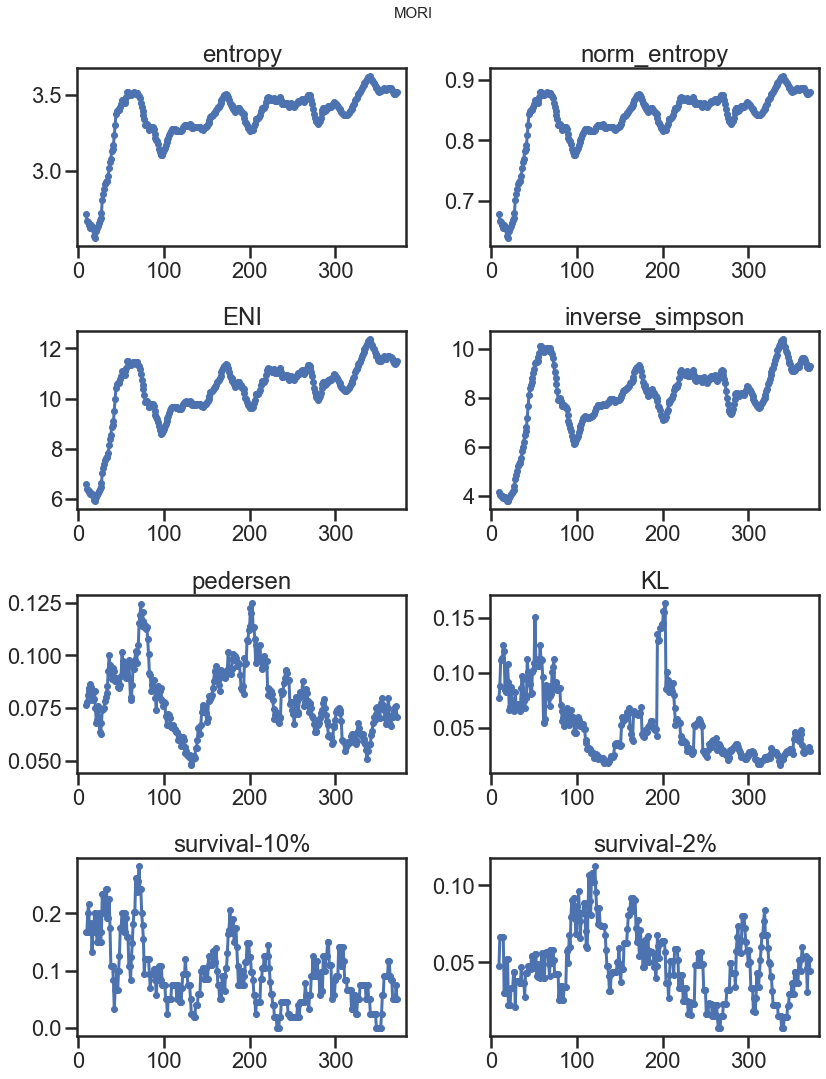

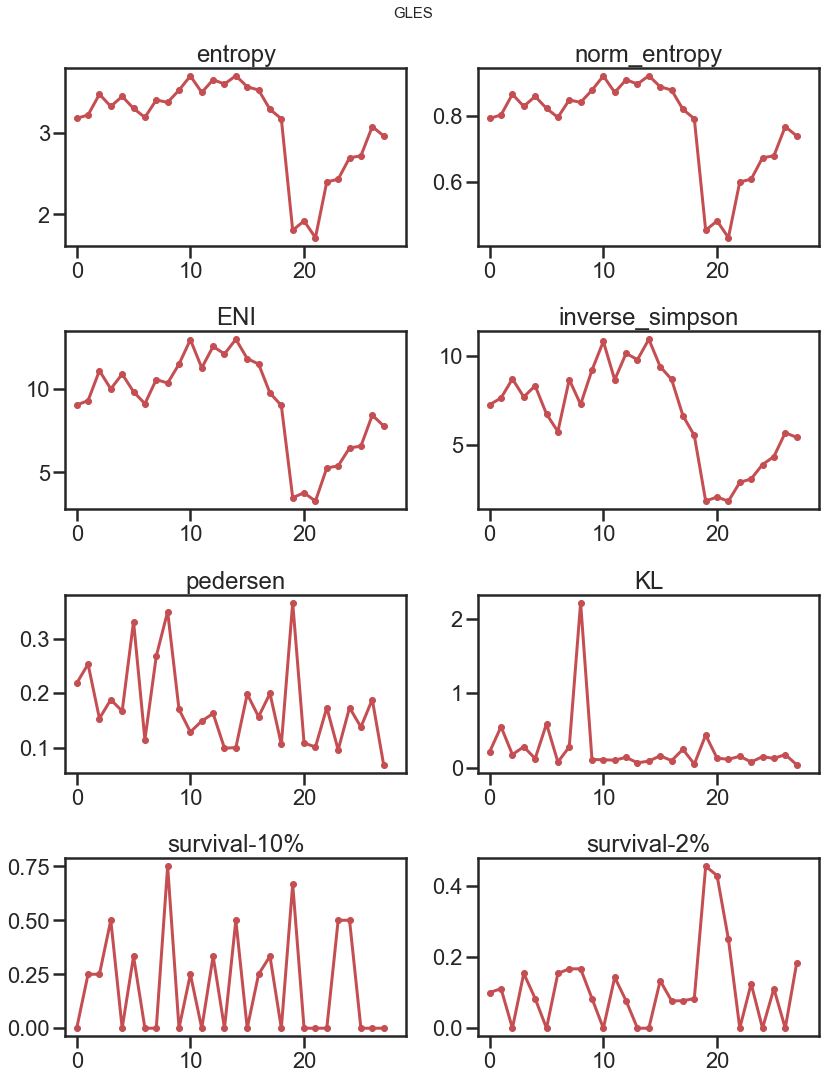

In [41]:
colors = ['b','r']

for df_key,c in zip(sorted(dfs_measures.keys())[::-1],colors):
    fig, axs = plt.subplots(4,2,figsize=(12,15))
    axs = axs.flatten()

    df = dfs_measures[df_key]

    for col, ax in zip(df.columns,axs):
        if df_key is 'MORI':
            windowsize = 10
        else:
            windowsize = 1
            
        y = df[col].rolling(window=windowsize).mean()
        ax.plot(y,'.-',c=c)
        ax.set_title(col)
        ax.set_xlim(-1,len(y)+windowsize)
        
    plt.suptitle(df_key, fontsize=15, y=1.01)
    plt.tight_layout()
    plt.show()

## Selecting relevant periods by hand:

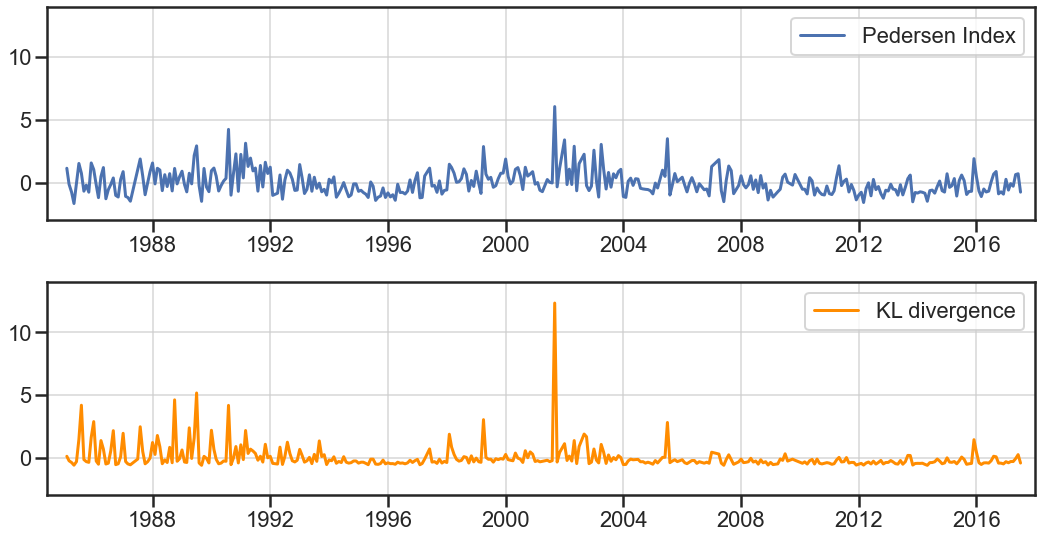

In [44]:
sns.set('poster')
sns.set_style('ticks')

key = 'MORI'

dates = agendas_data[key].index
x     = [ datetime.strptime(d, "%Y-%m").date() for d in dates[1:] ]
y1     = dfs_measures[key]['pedersen'].values
y2     = dfs_measures[key]['KL'].values

s_y1 = (y1-y1.mean())/y1.std()
s_y2 = (y2-y2.mean())/y2.std()

#s_y1 = y1
#s_y2 = y2

fig, axs = plt.subplots(2,1,figsize=(15,8))

#ax.plot(x, s_y2, '-', c='silver', lw=2)
axs[0].plot(x, s_y1, '-', lw=3, label='Pedersen Index')
axs[0].legend()
axs[1].plot(x, s_y2, '-', lw=3, c='darkorange', label='KL divergence')
axs[1].legend()

for ax in axs:
    ax.set_ylim(-3,14)
    ax.set_xlim(datetime(1984,6,1,0,0),datetime(2018,1,1,0,0))
    ax.grid(alpha=0.6)

plt.tight_layout()
#plt.savefig('images-paper/SI-Pedersen-vs-KL-MORI.png',dpi=150)
plt.show()

# Black and white version

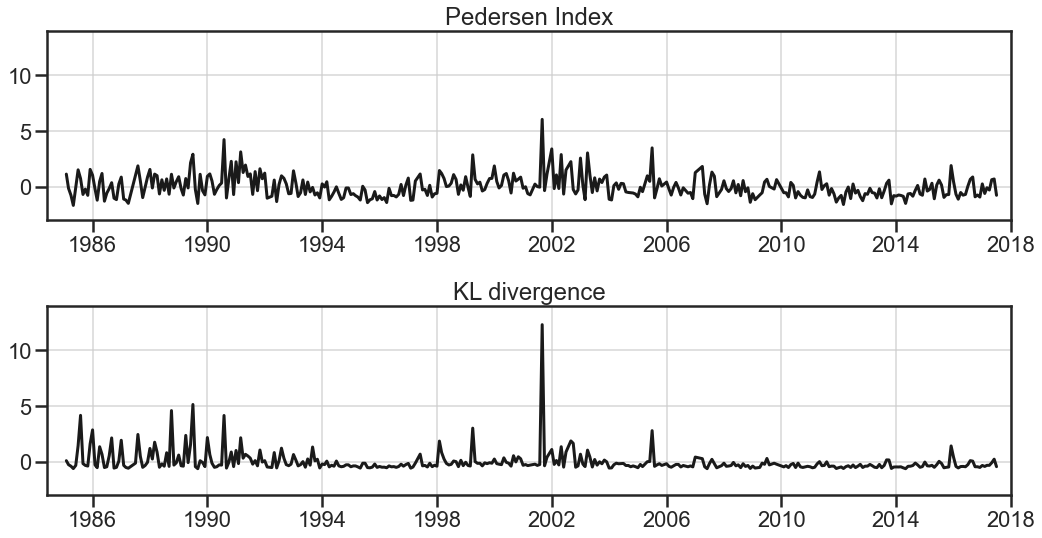

In [51]:
sns.set('poster')
sns.set_style('ticks')

key = 'MORI'

dates = agendas_data[key].index
x     = [ datetime.strptime(d, "%Y-%m").date() for d in dates[1:] ]
y1     = dfs_measures[key]['pedersen'].values
y2     = dfs_measures[key]['KL'].values

s_y1 = (y1-y1.mean())/y1.std()
s_y2 = (y2-y2.mean())/y2.std()

#s_y1 = y1
#s_y2 = y2

fig, axs = plt.subplots(2,1,figsize=(15,8))

#ax.plot(x, s_y2, '-', c='silver', lw=2)
axs[0].plot(x, s_y1, '-', lw=3, c='k')
axs[0].set_title('Pedersen Index')
axs[1].plot(x, s_y2, '-', lw=3, c='k')
axs[1].set_title('KL divergence')

for ax in axs:
    ax.set_ylim(-3,14)
    ax.set_xlim(datetime(1984,6,1,0,0),datetime(2018,1,1,0,0))
    ax.set_xticks([datetime(year,1,1,0,0) for year in np.arange(1986,2020,4)])
    ax.set_xticklabels(np.arange(1986,2020,4))
    ax.grid(alpha=0.6)

plt.tight_layout()
plt.savefig('images-paper/Camargo_POQ-19-0225.R1_Figure5.png',dpi=150)
plt.show()